# Imports

In [11]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from tqdm.notebook import tqdm
from collections import Counter
from matplotlib import pyplot as plt

import os
import traceback
import time
import random

In [2]:
#saving routines
import pickle
def save_obj(obj, name):
    pickle.dump(obj,open(name + '.pkl', 'wb'), protocol=4)
    
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

#quickly plot any data in 2D
from sklearn.decomposition import PCA

def show_data(data, c=None):
    pca = PCA(n_components=2, whiten=True)
    data_2D = pca.fit_transform(data)
    plt.scatter(data_2D[:, 0], data_2D[:, 1], c=c)
    plt.show()
    

In [3]:
#Parallelizing routines

# I mostly borrow this code from http://blog.adeel.io/2016/11/06/parallelize-pandas-map-or-apply/
# https://github.com/rafaelvalero/ParallelTextProcessing/blob/master/parallelizing_text_processing.ipynb
import multiprocessing
import pandas as pd
import numpy as np
from multiprocessing import Pool
import scipy.sparse as sp
#num_partitions = 5
num_cores = multiprocessing.cpu_count()
num_partitions = num_cores-5 # I like to leave some cores for other
#processes
print(num_partitions)



def parallelize_data_cr(df, func):
    parts=[]
    a = np.array_split(df, num_partitions)
    #print(1)
    #del df
    pool = Pool(num_partitions)
    jobs = []
    #print(2)
    #x = pd.concat(pool.map(func, [a,b,c,d,e]))
    finished = [7, 10, 11, 19]
    for i in range(0, num_partitions):
        if i not in finished:
            jobs.append(pool.apply_async(func,(a[i],i)))
    #print(3)
    #x = sp.vstack(pool.map(func, [a,b,c,d,e,f]), format='csr')
    
    for job in jobs:
        parts.append(job.get())
    print(4)
    
    pool.close()
    
    pool.join()
    return parts

27


In [4]:
#Evaluate with ROUGE

from rouge import Rouge 

hypothesis = "the #### transcript is a written version of each day 's cnn student news program use this transcript to he    lp students with reading comprehension and vocabulary use the weekly newsquiz to test your knowledge of storie s you     saw on cnn student news"
reference = "this page includes the show transcript use the transcript to help students with reading comprehension and     vocabulary at the bottom of the page , comment for a chance to be mentioned on cnn student news . you must be a teac    her or a student age # # or older to request a mention on the cnn student news roll call . the weekly newsquiz tests     students ' knowledge of even ts in the news"

#rouge metric based on https://pypi.org/project/rouge/
def my_rouge2(hypothesis, reference):
    rouge = Rouge()
    scores = rouge.get_scores(hypothesis, reference)
    
    #rouge-1
    r1_f1=scores[0]['rouge-1']['f']
    r1_precision=scores[0]['rouge-1']['p']
    r1_recall=scores[0]['rouge-1']['r']
    
    #rouge-2
    r2_f1=scores[0]['rouge-2']['f']
    r2_precision=scores[0]['rouge-2']['p']
    r2_recall=scores[0]['rouge-2']['r']
    
    return r1_f1, r2_f1, #, precision, recall

my_rouge2(hypothesis, reference)

(0.4786324739396596, 0.2608695605353498)

# Load data

In [6]:
ds = load_obj('ds_merged')
ds.head()

,article_id,article_text,abstract_text,section_names,sections,len_text,len_abstract,sent_ext,word_ext,word_inf,best_rouge1_wih,best_rouge2_wih,best_summary_wih,best_summary_vns,best_rouge1_vns,best_rouge2_vns,voted_summary,voted_method,voted_r1,voted_r2
0,astro-ph0202198,[the study of supernovae ( sne ) has greatly a...,[large numbers of supernovae ( sne ) have been...,"[introduction, method, results, future prospec...",[[the study of supernovae ( sne ) has greatly ...,341,12,0.000000,0.897436,0.076004,0.484935,0.146763,"[once discovered , the study of a particular s...","[2001 ; miknaitis et al ., spectroscopic follo...",0.541667,0.167247,"[2001 ; miknaitis et al ., spectroscopic follo...",vns,0.541667,0.167247
1,0905.2691,[it is believed that solar magnetic fields are...,[we investigate the emergence of magnetic flux...,"[introduction, observations and data reduction...",[[it is believed that solar magnetic fields ar...,329,11,0.000000,0.884892,0.073258,0.629482,0.296000,[they move upward and emerge into the solar at...,"[* ) . outside of active regions ,, the obs...",0.533333,0.174442,[they move upward and emerge into the solar at...,wih,0.629482,0.296000
2,1305.7010,[the origin - destination ( od ) matrix is imp...,[the estimation of the number of passengers wi...,"[introduction, the passenger model, the observ...",[[the origin - destination ( od ) matrix is im...,225,10,0.000000,0.740157,0.074367,0.454395,0.123128,[+ when the information is not available ( for...,[the origin - destination ( od ) matrix is imp...,0.502901,0.128155,[the origin - destination ( od ) matrix is imp...,vns,0.502901,0.128155
3,1402.0371,[multiscale dynamics is present in many phenom...,[the classical structure - function ( sf ) met...,"[introduction, detrending analysis and detrend...",[[multiscale dynamics is present in many pheno...,216,15,0.066667,0.949045,0.171659,0.767442,0.556667,[a detrended structure - function ( dsf ) meth...,[the corresponding scaling exponent @xmath0 is...,0.558214,0.272000,[a detrended structure - function ( dsf ) meth...,wih,0.767442,0.556667
4,1701.00774,[the @xmath3-transformation has been extensive...,"[given a real number @xmath0 , we study the as...","[introduction, coded negative beta-shift, lap ...",[[the @xmath3-transformation has been extensiv...,353,11,0.000000,0.867925,0.059547,0.541176,0.236407,"[thus , the previous proposition allows us to ...",[one endows @xmath78 ( or @xmath79 ) with the ...,0.518201,0.180645,"[thus , the previous proposition allows us to ...",wih,0.541176,0.236407


# Calculating best possible rouge summary

In [31]:
def vns_best_sum(text, abstract, init_sol):
    #initial greedy summary
    d=len(text)
    a=len(abstract)
    g_sum='. '.join(abstract)
    
    sent_sample=[text.index(s) for s in init_sol]#random.sample(range(d), a)
    
    best_sum='. '.join([text[i] for i in sent_sample])
    
    #calculate rouge
    best_objective=my_rouge2(best_sum,g_sum)[0]#

    #VNS
    k_max=3
    max_cpu_time=60
    max_iterations=10000
    ni_lim=700 #no improvement iterations limit

    k = 1
    n_iters = 0 # Инициализируем счётчик итераций
    ni=0
    start_time = time.perf_counter() # Фиксcurrent_time = time.perf_counter()
    cpu_time = 0

    while (cpu_time < max_cpu_time) and (n_iters < max_iterations):#(cpu_time < max_cpu_time) and 
        s=sent_sample
        #select random indices to change in initial solution
        ind_change = random.sample(range(len(s)), k)
        #delete indexes to change
        s=[s[i] for i in range(len(s)) if i not in ind_change]

        #generate new indices and add them to the summary sentence list
        while len(s)<a+k:
            j=random.randint(0,d-1)
            if j not in s:
                s.append(j)
        
        #generate new summary 
        neighbourhood='. '.join([text[i] for i in s])
        objective=my_rouge2(neighbourhood, g_sum)[0]
        #print('nq_metric', nq_metric, 'q_metric', q_metric)
        if objective>best_objective:
            print(objective)
            best_sum=neighbourhood
            best_objective=objective
            sent_sample=s
            #print(best_objective,k,n_iters, ni)
            k=1
        else:
            if k<k_max:
                k+=1
            ni+=1
            
        #update the counters
        cpu_time = time.perf_counter() - start_time
        n_iters+=1
        
        if ni==ni_lim:
            print('No ROUGE-1 improvement on more than 700 iterations. Exit.')
            break
    
    #get the final summary rouge score
    sent_sample.sort()
    #print(sent_sample)
    final_summary=[text[i] for i in sent_sample]
    is_sum_sent=[1 if s in final_summary else 0 for s in text]
    r=my_rouge2('. '.join(final_summary), g_sum)
    #print('n_iters',n_iters)
    return r, final_summary, is_sum_sent

In [32]:
text = ds.article_text.values[0]
abstract = ds.abstract_text.values[0] 
init_sol = ds.best_summary_wih.values[0]

vns_best_sum(text, abstract, init_sol)

0.49090908597194677
0.49235473511521666
0.5022156524020083
0.5053598725411519
0.5062893032070033
0.5308056822313565
0.5407166073882482
0.5431711096317364
0.5469522190587028
0.5553602761995424


((0.5553602761995424, 0.11992944826728152),
 ['1998 ) now combine to yield hundreds of new sn discoveries each year .',
  '2000 , and references therein ) .',
  'once discovered , the study of a particular sn , and its use as a tool for any of the applications above , is almost always based on spectroscopic verification and classification .',
  'determination of the type of a sn is crucial for most of the applications discussed above .',
  'since we want to constrain the type of a sn with an arbitrary ( but known ) redshift , it is not simple to utilize broadband photometry ; k - corrections for sne of all types , and at all ages , are currently unknown . instead , we have compiled a large spectral database of nearby , well - observed sne .',
  'as we show in @xmath20 , the type of a sn can sometimes be uniquely determined .',
  'it is therefore likely that analysis based on our database will be relevant to the large majority of sne discovered by current programs .',
  'analysis of fut

In [26]:
len(ds.best_summary_wih.values[0])

5

In [27]:
import os.path
#prepare the data for classification

def create_classif_data(texts, abstracts, ids, init_sol, c):
    if os.path.isfile('./_vns_initgreed_tmp/X_vns'+str(c)+'.pkl'):
        X_sent=load_obj('./_vns_initgreed_tmp/X_vns'+str(c))
        Art_ID=load_obj('./_vns_initgreed_tmp/Art_ID_vns'+str(c))
        Y=load_obj('./_vns_initgreed_tmp/Y_vns'+str(c))
        best_rouges=load_obj('./_vns_initgreed_tmp/best_rouges_vns'+str(c))
        best_sum=load_obj('./_vns_initgreed_tmp/best_sum_vns'+str(c))
        start=len(best_rouges)
        print('Process restarting. Starting from',start)
    else:
        X_sent = []
        Y = []
        Art_ID = []
        best_rouges = []
        best_sum = []
        start=0
    #art_num=100
    cnt_save=0
    
    for t, a, a_ids, insol in zip(tqdm(texts[start:]), abstracts[start:], ids[start:], init_sol[start:]):
        #print(len(t), len(a))
        if len(t)>len(a) and len(a)>=5:
            try:
                #print(1)
                r, s, issumsent=vns_best_sum(t, a, insol)
                X_sent.append(t)
                Art_ID.append([a_ids for i in range(len(t))])
                Y.append(issumsent)
                best_rouges.append(r)
                
                cnt_save+=1
                
                #save results on the go
                if cnt_save%50==0:
                    print('Saving work', c, 'counter value', cnt_save)
                    save_obj(X_sent, './_vns_initgreed_tmp/X_vns'+str(c))
                    save_obj(Y, './_vns_initgreed_tmp/Y_vns'+str(c))
                    save_obj(Art_ID, './_vns_initgreed_tmp/Art_ID_vns'+str(c))
                    save_obj(best_rouges, './_vns_initgreed_tmp/best_rouges_vns'+str(c))
                    save_obj(best_sum, './_vns_initgreed_tmp/best_sum_vns'+str(c))
            except Exception as err:
                #print('Err')
                traceback.print_exc()
                continue
        else:
            print('Number of sentences in article are smaller than in abstract OR abstract is shorter than 5 sentences')
    
    #final save
    save_obj(X_sent, './_vns_initgreed_tmp/X_vns'+str(c))
    save_obj(Y, './_vns_initgreed_tmp/Y_vns'+str(c))
    save_obj(Art_ID, './_vns_initgreed_tmp/Art_ID_vns'+str(c))
    save_obj(best_rouges, './_vns_initgreed_tmp/best_rouges_vns'+str(c))
    save_obj(best_sum, './_vns_initgreed_tmp/best_sum_vns'+str(c))
            
       
    return X_sent, Y, Art_ID, best_rouges, best_sum

In [28]:
create_classif_data(ds.article_text[0:3], ds.abstract_text[0:3], ds.article_id[0:3], ds.best_summary_wih.values[0:3], 150)

Process restarting. Starting from 0


  0%|          | 0/3 [00:00<?, ?it/s]

0.4850948461606114
0.5029069718540851
0.5029239717108257
0.507801413582174
0.5133239783283403
0.5227606412059661
0.5261584405179184
0.5392912123044342
0.5409582639779843
0.5465648805516695
0.5517241329642497
0.5559105381514051
0.5685950363272454
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.45751633506151484
0.4625623911711208
0.4802867334212047
0.4807017494795937
0.48359239580373525
0.4973730248680382
0.49799196287221176
0.504892362912979
0.5119999950012801
0.5131086092631403
0.5257352891633327
0.5290806704517247
0.5357142807171202
No ROUGE-1 improvement on more than 700 iterations. Exit.


([['the study of supernovae ( sne ) has greatly advanced in the last few years .',
   'intensive and highly automated monitoring of nearby galaxies ( e.g. , li et al .',
   '1996 ; treffers et al .',
   '1997 ; filippenko et al .',
   '2001 ; dimai 2001 ; qiu & hu 2001 ) , wide - field , moderately deep surveys ( e.g. , reiss et al . 1998 ; gal - yam & maoz 1999 , 2002 ; hardin et al . 2000 ; schaefer 2000 ) , and cosmology - oriented , deep , high - redshift sn search projects ( perlmutter et al . 1997 ; schmidt et al .',
   '1998 ) now combine to yield hundreds of new sn discoveries each year .',
   'ambitious programs that are currently planned or underway [ e.g. , the nearby supernova factory  aldering et al .',
   '2001 ; the supernova / acceleration probe ( snap ) ',
   'perlmutter et al . 2000 ; automated sn detections in sloan digital sky survey ( sdss ) data  vanden berk et al .',
   '2001 ; miknaitis et al .',
   '2001b ; see also @xmath9 promise to increase these numbers by 

## Parallelize

In [36]:
def create_data(data,c):
    print("Process working on: "+str(c))
    #lem_text=[custom_lemm(t) for t in tqdm(data)]
    X, Y, idx, best_rouges, best_sum = create_classif_data(data.article_text, 
                                                           data.abstract_text, 
                                                           data.article_id, 
                                                           data.best_summary_wih, 
                                                           c)
    print("Process #%s finished" % c)
    return X, Y, idx, best_rouges, best_sum

In [37]:
def parallelize_data_cr(df, func):
    parts=[]
    a = np.array_split(df, num_partitions)
    #print(1)
    #del df
    pool = Pool(num_partitions)
    jobs = []
    #print(2)
    #x = pd.concat(pool.map(func, [a,b,c,d,e]))
    finished=[]
    for i in range(0, num_partitions):
        if i not in finished:
            jobs.append(pool.apply_async(func,(a[i],i)))
    #print(3)
    #x = sp.vstack(pool.map(func, [a,b,c,d,e,f]), format='csr')
    
    for job in jobs:
        parts.append(job.get())
    print(4)
    
    pool.close()
    
    pool.join()
    return parts

In [38]:
classif_data=parallelize_data_cr(ds, create_data)

Process working on: 0


  0%|          | 0/642 [00:00<?, ?it/s]

Process working on: 1


  0%|          | 0/642 [00:00<?, ?it/s]

Process working on: 2


  0%|          | 0/642 [00:00<?, ?it/s]

Process working on: 3


  0%|          | 0/642 [00:00<?, ?it/s]

Process working on: 4


  0%|          | 0/642 [00:00<?, ?it/s]

Process working on: 5


  0%|          | 0/642 [00:00<?, ?it/s]

Process working on: 6


  0%|          | 0/642 [00:00<?, ?it/s]

Process working on: 7


  0%|          | 0/642 [00:00<?, ?it/s]

Process working on: 8


  0%|          | 0/642 [00:00<?, ?it/s]

Process working on: 9


  0%|          | 0/642 [00:00<?, ?it/s]

Process working on: 10


  0%|          | 0/642 [00:00<?, ?it/s]

Process working on: 11


  0%|          | 0/642 [00:00<?, ?it/s]

0.5803468159070868
Process working on: 12


  0%|          | 0/642 [00:00<?, ?it/s]

Process working on: 13


  0%|          | 0/642 [00:00<?, ?it/s]

Process working on: 14


  0%|          | 0/642 [00:00<?, ?it/s]

Process working on: 15


  0%|          | 0/642 [00:00<?, ?it/s]

0.4984462349898355
Process working on: 16


  0%|          | 0/642 [00:00<?, ?it/s]

Process working on: 17


  0%|          | 0/642 [00:00<?, ?it/s]

0.5006369377379934
Process working on: 18


  0%|          | 0/642 [00:00<?, ?it/s]

Process working on: 19


  0%|          | 0/642 [00:00<?, ?it/s]

Process working on: 20
0.5073859937702769


  0%|          | 0/642 [00:00<?, ?it/s]

0.5074821030458831
Process working on: 21


  0%|          | 0/642 [00:00<?, ?it/s]

Process working on: 22


  0%|          | 0/642 [00:00<?, ?it/s]

Process working on: 23


  0%|          | 0/642 [00:00<?, ?it/s]

Process working on: 24


  0%|          | 0/642 [00:00<?, ?it/s]

Process working on: 25


  0%|          | 0/642 [00:00<?, ?it/s]

Process working on: 26


  0%|          | 0/642 [00:00<?, ?it/s]

0.5154494332044663
0.5159461324918669
0.566929128936217
0.5202558585398726
0.5208034383285509
0.49315068006489005
0.5291545139517231
0.5186335354791966
0.48115298852156574
0.5188679196197243
0.49114521350693957
0.4988399022236908
0.5162846753466689
0.5816917679803538
0.5201004975125944
0.5885286733303898
0.5324384738097634
0.5477031752160098
0.561456747792328
0.496385537235564
0.4999999950549971
0.5385427617619806
0.5645161240685987
0.5676646656707377
0.56730768737801
0.5680190880925433
0.573378834637199
0.5766590339434935
0.5826589545712586
0.5828437083009277
0.5850178309252476
0.501187643538318
0.5061124644903786
0.5122897750903472
0.5682926779399465
0.5683962214491647
0.5325778986835321
0.5686512708351186
0.5743329047846438
0.5737704868516529
0.5816326480615174
0.5393419120243614
0.5839793231655083
0.5358851624642293
0.5380710610116209
0.6791131805692159
0.5918618938985375
0.5937106868261857
0.5876777202044478
0.588039862146941
0.5963060636050641
0.5401459804038576
0.540404035422406

0.5048543639736828
0.5325670448189986
0.5436507886515023
0.549618315622997
0.15756951240240938
0.8049645340297898
0.5280728326875918
0.8421052581585308
0.5673249501727968
0.5375722494438923
0.5451761053068768
0.5056603724269136
0.5497771124608934
0.5547226337472944
0.5353159801605839
0.5105566169327405
0.4471744422411243
0.5413533784815423
0.5444646048501817
0.5842349256007396
0.5858267667800361
0.5934426180284332
0.5996533745771622
0.5506756707538006
0.5551724088502379
0.5152671706296253
0.515503871012259
0.5552238756683004
0.5616224599302475
0.5719696919858385
0.4585365804402143
0.506437763366428
0.5180180130866002
0.5637181359961698
0.5306122398979592
0.5671191504150657
0.5767097917044155
0.5493716288122121
0.5505617927781286
0.5641025591681497
0.5739436570105758
0.5565529573579933
0.5582255033525239
0.844529745480307
0.533916844116467
0.5441860415506761
0.5823627238807202
0.5841924349230053
0.5674846576557737
0.5780346770891109
0.458628836718475
0.5680119532559809
0.569659437793662

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.6401515101521609
0.6522593270268372
0.5952813017329983
0.4324324276113952
0.491761719031872
0.5550527854539333
0.5577811969307767
0.564935059968007
0.5661016899235278


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")


0.6504347776316977


ValueError: Sample larger than population or is negative


0.6537785538920377
0.45522387573798456
0.4569288340870962
0.4824902674610516
0.48879836571409613
0.5926680195275448
0.6632653011615531
0.5963003214683605
0.6666666616979016
0.6017897041832951
0.6048237427157418


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5596816926904433
0.5102040767689772
0.5609065106019631
0.5634218239120788
0.6004056745240672
0.5659259209283951
0.5273437450733186
0.603465846181007
0.5380710610270814
0.6615853611013256
0.5394190821589677
0.6986301320665815
0.5458333283528647
0.412639400562665
0.5474613636536411
0.43991852880002985
0.5477272677298554
0.46651269711908433
0.5493273492604919
0.5324459185562609
0.5330882303055392
0.5502183356128794
0.6073926024111753
0.5387205338023898
0.551495011611351
0.4906666616795023
0.49863013201786455
0.5027624259782975
0.5731166862882341
0.5765230262054318
0.5847589374607269
0.5482758571260998
0.5144356905389189
0.5320196994378656
0.6996466381584863
0.5188171993016535
0.5202156284240889
0.5206185517058137
0.5283540752293445
0.5307797487660965
0.7056737539110836
0.710865556712758
0.5563139882413891
0.5352480367771272
0.5409153902935705
0.5719237385531449
0.5744680801396435
0.5546218437536584
0.5743145693508159
0.7206896502452438
0.7249999950398598
0.7349177281124566
0.55064934565

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.553398053261971
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.6088235244160901
0.5562309980618713
0.47308781374326897
0.47976878115761473
0.4812030025270394
0.4863945528592832
0.4900181439449804
0.49683543803842534
0.608843532517007
0.50163933927283
0.46645366994457443
0.4749455295379982
0.5075125158893092
0.5058004596589973
0.5220588190292498
0.5386597892090353
0.5418227170581718
0.5554106863751661
0.5859154881869074
0.6061493363094951
0.6635944651481238
0.5431818131868802
0.546285709289169


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.6833855750159197
0.5619335297694893
0.5678627095174515
0.521920663142224
0.5225603308597031
0.5691823849430898
0.5683607681728667
0.547027022058168
0.5510428051197644
0.5829528108596569
0.5881435207559368
0.5893416878025471
0.5915267735819978
0.46169153742333113
0.5963019981036134
0.4729166617447917
0.4851157612896874
0.4006069752764685
0.4039829253363658
0.5090909041012398
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5131729617883588
0.7012986963430279
0.40731070009186104
0.7070376382454779
0.7072757987380934
0.41160949379783635
0.4175824126521933
0.4184782559511239
0.5150115423486179
0.5192083768417944
0.5807504028306752
0.5246589667463768
0.5960912002119386
0.5255319099571978
0.5967213064762699
0.529968449334355
0.536480681750562
0.5373890951430074
0.6069182339977158
0.6121794821799496
0.4207492745669759
0.537157752717049
0.5549450500854743
0.571839075543376
0.42399999510368
0.4272108794337915
0.43352600658679713
0.6257861585260177
0.6265486676246536
0.5342960240503

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.6546644794523747
0.6570048259179911
0.5331781090885929
0.5366430210049796
0.6198083018126144
0.6355785787926894
0.5997322573884651
0.6058091236307149
0.5772151849472521
0.581632648127115
0.5831134515000245
0.500641843526723
0.6563039673937258
0.6573426523624628
0.6075268767248021
0.6147426931920205
0.6292428148598396
0.5418719162664035
0.5844503971690662
0.5425531865075325
0.6002655992803642
0.5565862658733793
0.526659407491466
0.5297418581296693
0.5610200314358613
0.5432473396298712
0.5629629579646778
0.5533230245082166
0.556249995127002
0.6450742190248798
0.5599999951484498
0.5758091943657149
0.5786801980989519
0.5809859105153368
0.585454540461157
0.5928705390902147
0.6507304066950613
0.5940594009528478
0.5361155649121814
0.5341040412727723
0.5450236916973171
0.5475578356202709
0.559701487537592
0.6010544765700625
0.5882352892384896
0.5779376448894122
0.5868725818762393
0.5888538331846603
0.5955555506197777
0.6537396071883657
0.5924224978998499
0.597727267770687
0.6044864176849747


0.5828970281595595
0.5499058330912432
0.553435109542349
0.5596868834748642
0.6068052880059569
0.6120114344661628
0.6805778441228562
0.6135746556458714
0.6166514131230179
0.5159500647927348
0.5306704661429669
0.5384615337777476
0.37006236514814517
0.3782608646068999
0.3795309119034739
0.38478746705683936
0.3906976694224987
0.5463917476625809
0.5617173474599736
0.39359267235498957
0.399999995003894
0.5267759515302578
0.4009111567426487
0.6314814764853396
0.4066193803434882
0.5293413124737638
0.5339805776166463
0.6332046282055462
0.5804195754861485
0.5852782715230671
0.5899814421430465
0.5939849574179575
0.4131455349078666
0.5824800860350409
0.41818181319431824
0.4217687025017354
0.4289044239105417
0.44090908592159095
0.46776611199198004
0.44137930535246406
0.44496486619660064
0.46788990329096886
0.6362790647701462
0.6363636313637979
0.4729729681519358
0.47489823126503905
0.44803694650715514
0.45070422035387603
0.4660194124767886
0.4393305390226887
0.4728132337713842
0.4752475197584796
0.

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5744125277377006
0.5790408476527831
0.6167315125197392
0.6209598382981868
0.6246185097507683
0.6286286236300767
0.585009135816553
0.5895522338381496
0.5331230234359482
0.590284138034397
0.5361155648543655
0.5906040218605709
0.5383360472225225
0.5151515102286961
0.5399644710232232
0.5457809644840113
0.5156249950469238
0.5204582601537017
0.5962962913341736
0.5963912580781723
0.5246422843810425
0.5510534796272023
0.6019047569233379
0.5538461488479218
0.5588752146840417
0.6467661641568476
0.5337423263527513
0.567986225637559
0.64999999500162
0.6061739894174198
0.6118546795288801
0.5522388010102474
0.6214149089743867
0.6259689872579962
0.5753424607548907
0.6360153206859304
0.6382153199367805
0.5759162253665074
0.5827338079548808
0.6555772944205752
0.553755517879321
0.5550239184486518
0.5880281640146424
0.5882352891328532
0.46863904868165684
0.5073431193687712
0.517985606608188
0.5390624952449884
0.5416116200554578
0.5502793247447413
0.5599999950650645
0.5660377309362763
0.5054347778569531

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.6141078788453196
0.6177105781600885
0.6116504804371583
0.5440612977254528
0.5034722174465303
0.4911764657143599
0.49698794690321535
0.4999999950687777
0.5047801098097826
0.5117187450641634
0.5210727920197149
0.5211864356852378
0.5492063442487278
0.5459317535534683
0.5219298195614998
0.5487646244182487
0.5274725224725517
0.528888883889284
0.5315315265340679
0.5503875919334109
0.5526315739690097
0.5099601545092936
0.5156889446330746
0.5279034641741343
0.5161290273359707
0.516224183822278
0.5191815808426162
0.5256064640971804
0.5414201133573755
0.5338808985137181
0.5355648485690904
0.5421133181260246
0.5438335759927053
0.5513866181744635
0.4671999956712448
0.4760330534479339
0.5617021227020774
0.47634583575707423
0.4774624329699193
0.4831261055642666
0.6008119030248609
0.6058091236555845
0.6145092410979162
0.5670261891457997
0.4848484802810109
0.4872727226647273
0.5925925878862071
0.6002166799752092
0.6077348018479046
0.627875502447333
0.6446280941745024
0.5035971177162156
0.52157598032

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5788336883269504
0.5121495278746442
0.5140712897179405
0.4685714237087347
0.522417149102972
0.4897959134236568
0.6003016541492576
0.4967880035845916
0.5148063731321445
0.5173611061430002
0.5188679195337531
0.5314183073995404
0.5321428521572068
0.6056018118271378
0.6078280840393473
0.610418190202528
0.6175595188430171
0.5356521689436674
0.6226415046191528
0.5448154607528393
0.6307692259257397
0.6491228020363957
0.49275361828654113
0.5024630492630252
0.5418502152705273
0.6532258015455906
0.5426008918625954
0.6765327646012811
0.5483870917746184
0.60045146226926
0.6237845874006542
0.630451410470839
0.5495652124219282
0.556737583670653
0.5060658530155079
0.5117370843368821
0.5196078382184738
0.6238938003145315
0.6278026855845684
0.6320541710728718
0.6363636313637397
0.7079645967840084
0.558064511212279
0.5601317907775568
0.561344532857849
0.5137614629525462
0.5166051611089175
0.7124999950586807
0.7167381924581406
0.7354260039767541


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5630397186841706
0.5176470539975425
0.5204991038285974
0.5267034941382199
0.5797598578059308
0.5800711693848863
0.580406649343825
0.5595854872637894
0.5232558090677394
0.5294117597377481
0.5606060556061324
0.5626204188943463
0.5548387046942769
0.5582417532487381
0.5647558336657336


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5124555111259356
0.5145985352275695
0.5148148098807271
0.5252918238183016
0.5832376529457279
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5268817155328812
0.5347985298760887
0.5468164744557366
0.49372384466347274
0.5036179402335172
0.5233918080749632
0.5250379314193345
0.541935478946098
0.5469798608098735
0.564102559127124
0.4868913809162004
0.4952380903630658
0.4964538959431744
0.4981549767200203
0.49901767681551346
0.5111111062757888
0.5289575240651601
0.5393700738245553
0.5999999950560554
0.544354833768942
0.6484641588507147
0.651488611475244
0.5609284283740821
0.5652173863843366
0.5702811195612167
0.6745762662195347
0.6900175081477483
0.6996336946339681
0.6085997746241715
0.6239620353806169
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.6388888838970513
0.5112582733151705
0.5252525203142537
0.5276073569784335
0.5286624153839913
0.5660377308540012
0.5732484026451379
0.5835962095150714
0.552980127

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.608552626612762
0.36400817511017436
0.368737470131124
0.3739837349973561
0.3887850420287536
0.3984526064574301
0.5748344322103066
0.42147116815591545
0.5858310577594311
0.5940594009910194
0.4255319101324784
0.43144423665798826
0.4336448551128657
0.4369747850303651
0.43715846529414304
0.45599999518432
0.45769230294112423
0.4648437452224731
0.6741016059230187
0.6870228957697041
0.692513363984851
0.4991023290961776
0.6396103846547162
0.4687499952224732
0.49152541883259127
0.5009560180266078
0.5058365709391512
0.5041666617920139
0.5182012798875689
0.5243902389292089
0.5357873160861656
0.5419354788728409
0.5194273980140599
0.5258799123180262
0.588617881203305
0.4019292561699631
0.42832469331030515
0.5925925876237227
0.596491223108649


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5319587580260603
0.5355648486763188
0.5502183356808604
0.5500794863270491
0.5525902619608695
0.5563139881889714
0.5740072152166066
0.5837837787838002
0.5461847339913872
0.5973645631056681
0.4631578902578641
0.4803149559182994
0.5890410909036053
0.54799999503872
0.6309963049655506
0.6325757525878817
0.5974842717801907
0.6039603910553433
0.6095890360980016
0.6422338518990404
0.6544789712348226
0.5482625433341781
0.5994065232058045
0.6009244942315902
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.6086956471746847
0.6108374334334732
0.5190615790163483
0.5637342859393585
0.5729926958069157
0.5821205771517889
0.5674603125220458
0.5850052748517913
0.5679264506028436
0.5690550313689589
0.5744908846112932
0.5749559034069596
0.5750452030437299
0.5451327384290079
0.5958986681237588
0.5066162522303738
0.5807127832784393
0.5490196028450597
0.5132075423139908
0.5465465417934602
0.51485148023135
0.5848670706663155
0.5265306072969598
0.5514018643454063
0.5927505280517911
0.5623003146376

0.5738396574672863
0.5762711814582736
0.268700068299467
0.6099476389802911
0.6127320904907514
0.6139657394009523
0.5830720953441888
0.6231292467033552
0.6427840277782656
0.5845181624818252
0.26943004759171185
0.5574771059738444
0.5654885605539396
0.6459999950423201
0.5658648289089644
0.5917721469229691
0.5711086176309206
0.6585365803956804
0.660455481560468
0.49612402628178603
0.5164319201400859
0.5740956776139392
0.5228758121793435
0.5268456327303388
0.5943536354958063
0.5283018819089762
0.5807228865697779
0.5819070854731859
0.606508870824376
0.5873786357824725
0.66666666166682
0.5882352891321847
0.5935162044833056
0.5979381393300298
0.6666666616797748
0.5535420050579594
0.5626071992331615
0.5824175774629339
0.5886699457510496
0.47631934556700806
0.4804469224336398
0.4870040990480967
0.49078013688913036
0.5892018729342724
0.5896510178672124
0.5961538411567354
0.4923504818506619
0.49784172165233687
0.49855071966607867
0.5019505803206503
0.5054054005004018
0.539893612136183
0.6061349643

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5889763729662596
0.5946843803820598
0.6048109915694785
0.5644916492011396
0.5968749950355958
0.5990016588966254
0.5705229745159371
0.5839160789381511
0.5961199244701997
0.5585585536169955
0.5086206848350179
0.5207373222782392
0.5217391254769074
0.5647348902361944
0.5684754472097364


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5597104895817334
0.6459627280905521
0.6547314529303184
0.6567164129708434
0.7184170422759233
0.5717234213067848
0.531073441407287
0.5320388300004902
0.6882591043775328
0.6905089359005089
0.5496894360061342
0.5555555505596371
0.7030812275259909
0.5566342992075912
0.5607701515337821
0.5761006239801907
0.5815085108982306
0.5851197932816941
0.5731132025689748
0.5720670341278736
0.5789473634305045
0.5424954742777354
0.5501858686526583
0.5584795272191444
0.5506692110862103
0.5597667589065781
0.5912838583912065
0.5916167614803256
0.5517241329548158
0.5985090472433344
0.6021505326854898
0.5359223251461213
0.6053811609389895
0.5621301725596093
0.5365853609374528
0.48037382693005504
0.5397412150643193
0.5499058331210346
0.4830339272074415
0.49578058574153444


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


No ROUGE-1 improvement on more than 700 iterations. Exit.
0.564814809830247
0.4958158946115483
0.4978540722676094
0.49999999502703296
0.5064655122536648
0.5658093747551618
0.5904522563570364
0.5589836611312875


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5714285664530077
0.5626134251966233
0.6022471861421286
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.6060606011458046
0.6530612195015423
0.4736196269588167
0.4737588602535487
0.48450703725673483
0.5069817350782974
0.48717948218634594
0.4875912358956151
0.5907384180827412
0.5929778883917607
0.4908835854650461
0.5134843531563348
0.49279538406099216
0.7055630886831907
0.4985337193629227
0.5014662706825708
0.5219941299201075
0.5191489311724763
0.5330396425779658
0.7184465969823851
0.5515947418004922
0.5557655905386274
0.5153115050552347
0.5154419545498407
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.576074327243448
0.5763097900820098
0.5785714236190761
0.584652857392414
0.5941845715304125
0.5984455908812317
0.4864864815010957
0.7190082595092929
0.5877659524471269
0.5238744834040527
0.5158562318093542
0.4932920486743539
0.5209903071764146
0.562753031460932
0.568888883891358
0.5752808938820858
0.5822222172246915
0.5266029963644893
0.5895316754504855
0.499468645

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5503546051070268
0.5578034633584484
0.5593984913383911
0.48865153062315403
0.49999999507257953
0.5673981141757649
0.5108359083587498
0.5723472619133385
0.5746031696455531
0.5831903895129291
0.5845648554453855
0.5194805144930661
0.5197740063058366
0.5850556389202334
0.5853658487405192
0.5943396176921405
0.6062602915569861
0.5484180200301328
0.5496624830410772
0.5535353485823692
0.513931883590948
0.5176848824784691
0.5210083983630536
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.47425473775952737
0.4857142809997977
0.5020463799214203
0.516129027357135
0.5929456575362981
0.5191637580683874
0.5233644810267448
0.5239005686863186
0.5283757289628948
0.5463743626229565
0.5223140445928012
0.5263157844740446
0.6137667254018222
0.5319148886233088
0.5383022724507371
0.542797489804525
0.5435244111737687
0.5669014034557256
0.426633781084989
0.5345345296103311
0.5503999950215169
0.4285714239717804
0.45300461768761235
0.46951219033057895
0.49261083254046456
0.4991624741408889
0.6137750

0.5697151374313144
0.5614035037872372
0.5773732070275855
0.5505050455586484
0.5226480790219622
0.5304136206120909
0.5652173863163104
0.5064748151630248
0.5108853360884394
0.5545335037179451
0.5592543227200661
0.5300812958133386
0.5423728763616776
0.5565217341489603
0.56971513745577
0.5506072824581438
0.5124450901786752
0.5212121162128559
0.554334549423118
0.5832223652153101
0.5728314189036245
0.5573770442351027
0.5239520908112517
0.5253164507012097
0.5915875119884972
0.5639686634340341
0.5345622069815787
0.580645156334354
0.575488449715272
0.5760286175519153
0.565789468715374
0.6138107366935067
0.5672042960927566
0.5814977923996196
0.5938461488582724
0.602564097564565
0.5419734854350048
0.5770609269122313
0.5176908702678861
0.5227272677505166
0.5668789758958275
0.5741935433883975
0.5788617836182167
0.5428156699055656
0.5838991220919677
0.5887096724283176
0.599589317384966
0.5282331462378692
0.5328330156674845
0.6024844670510612
0.5356454670751892
0.6121297553080384
0.6045548604258024
0

0.5428571378684808
0.5456790073464411
0.6553322979782089
0.6571428521650795
0.6579804510350242
0.5024630496535952


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5113636315613702
0.5558035664859695
0.552179651662528
0.5576923027687253
0.5170067979917258
0.5263157847131315
0.5581395299646494
0.6383701138956708
0.5591397799560073
0.5274431010564347
0.5331412055500835
0.5283018818405839
0.4584103465606582
0.5398058202685267
0.4624277409455712
0.5432595523513719
0.5436893156254318
0.5475177256964541
0.5650224165353998
0.5662650553543693
0.5732087178152386
0.47863247375082185
0.47926266784939164
0.5621370449670251
0.5637426850791698
0.48226949856647044
0.4878048730546104
0.49748743218605596
0.49999999500432535
0.5025125578141967
0.5245901589607798


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5723830685562077
0.5766590339374453
0.585746097509437
0.5253011998297576
0.5276381859549002
0.5857142809030205
0.5880681770159156
0.5910447712445535
0.5027124727888322
0.5104761857687801
0.5175438547300132
0.5270270220806957
0.5318181768637398
0.5357142807765666
0.5501165451426586
0.5550239184564226
0.5555555505556832
0.49438201759816974
0.49757673178982215
0.5017064796976086
0.5585585536122273
0.5628997818949723
0.5668934190838181
0.5336538411654032
0.5357142807148064
0.5672514570109178
0.5705705655794082
0.6207729418844373
0.5092024491804359
0.5193548338295526
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5090090042833375
0.5227655937186229
0.527629228533336
0.5355191206934283
0.6308724782528355
0.6377204834907
0.5249679853856887
0.5479082276302405
0.5835866214136972
0.5880551254287786
0.6405451399040542
0.514563101948817
0.5181598014516121
0.5245097990604577
0.16437717927134168
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.720279715293474
0.654929572528

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5686546414007361


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5693641568873
0.5790209740883566
0.5165394352409858
0.5363765999479347
0.5185185135311512
0.5530864147535741
0.5579078405808232
0.5456919010248553
0.5614035037750705
0.548022593871054
0.5412979301644283
0.5438202197657872
0.5350553456031374
0.6787330266761304
0.5946704017711544
0.5516483467214104
0.5450450400897858
0.605304207269258
0.6223662835516656
0.6268174425580892
0.5707070657124592
0.5718015616026765
0.5744400477311351
0.5910165435606302
0.5495495445942903
0.5495376436262169
0.5517241329424326
0.5642633178990601
0.6514886114691099
0.6518771281246725
0.5545571195492723
0.6701570630708832
0.537037032083402
0.5409523759772156
0.586251616289657
0.672268902591625
0.6897689719403871
0.6903553249733024
0.6932006583885438
0.5649263671628236
0.5741758191767676
0.5669125347671611
0.5932415469794065
0.5794392476142722
0.5555555505987733
0.5976408862293939
0.6096551674138787
0.6172839456172935
0.5873362397345588
0.502659569636466
0.5935769608410013
0.5130315451930131
0.5220125736223351
0.

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5430463526336565
0.5499181619642077
0.5597381292309835
0.5599999950142224
0.5683836539701991
0.5763888838898534
0.5843478210876976
0.5945945896028123
0.5986394507880975
0.6068965467262784
0.6279863431275846
0.6593806871735661
0.6628787829074839
0.665384610427219
0.5839999950998757
0.6053748182363075
0.6111908128194414
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.46710525832756233
0.4776632253497243
0.5487804829119572
0.5499231901821846
0.553259136554604
0.5679012296601129
0.6128133655266487
0.5680119532792179
0.5709876494131992
0.5759999950540801
0.5140073032959717
0.5147783202435453
0.5193508065887056
0.5329883521137886
0.540540535567166
0.5541490808008371
0.5853658487656157
0.5911949636248566
0.521739125712101
0.5306930644419959
0.5473250979673662
0.5492662424459299
0.5571245136848697
0.4708797968586517
0.47420146933697155
0.47959183182267806
0.48210023384122896
0.4944649397832576
0.4979919629117094
0.498727730459893
0.4993464002904866
0.5116851119849796
0.5572005333

0.5965417817654828
0.49850745777282257
0.606606601610259
0.5061728345580419
0.507598779261232
0.6117318386205175
0.5194029801608823
0.6212765907773654
0.521193087658939
0.6264367766329767
0.532374095851602


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.6405405356178233
0.5343283532952106
0.6638772614340319
0.4837962916568073
0.49761904292562364
0.4599542284100299
0.47820965342367727
0.4806007459738315
0.683195587344216
0.6949152492731974
0.5094339572664038
0.5152625102789817
0.5176184640294451
0.5709459409644358
0.5782312875318154
0.45276872477432123
0.4649572600309153
0.5324232031922199
0.5371428521433863
0.5840407420445578
0.7121661671142654
0.47719297750440137
0.4801381643203546
0.5906040218681591
0.48056536606693806
0.5914529864652789
0.4844961190310829
0.4862888432814521
0.49932885417543355
0.591735532222881
0.5993031308934187
0.5056818132341168
0.5090909040999082
0.5373134278473856
0.5517241329975499
0.5696670727159997
0.5759999950003201
0.5109489001394215
0.5239520908229051
0.6013745654567142
0.5269645558662966
0.6044904958714479


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative
Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5331491663514545
0.5346260338588562
0.5365168489957076
0.5462427696928147
0.5605095491669542
0.5105691007227973
0.5155993382104772
0.5167853460525371
0.521599995044557
0.5277310874488526
0.5433789904369436
0.5326460431137446
0.5349650299655851
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5466666616827223
0.5604026795764268
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.46840958122811266
0.4809843351780951
0.4864253344848591
0.5489260093216318
0.5550561747789169
0.5814536291081087
0.5871794821901383
0.5588235244138379
0.49457176826848226
0.5652667373397015
0.49489795419421595
0.5380710612064213
0.541484711367823
0.5268542149583009
0.5454545404556593
0.6007604512900288
0.5447870730232168
0.6081258141380941
0.5457025870894064
0.5377697791779023
0.5501354963559316
0.5492629896862213
0.5576036817660177
0.5819397943454213
0.5639396297186328
0.5490196028442614
0.42465752930292977
0.6112115682617583
0.62337661838738
0.43055555059950096
0.4432432382609204
0.4448462

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5858310577389393
0.5863095188159014
0.5631928996742396
0.5399393276678449
0.6068376018671927
0.5415384565422959
0.5688487534742088
0.5714285664471205
0.6115214130298542
0.5769644729712726
0.6243194142602956
0.5577264604019952
0.5735567920296566
0.5763358728644166
0.5902004404497994
0.4811715431595211
0.5911111061278026
0.4828973793184864
0.48543688820480724
0.43636363169276615
0.44298245132656205
0.45701356980078217
0.6247689414080176
0.6274509755051476
0.5930372099715662
0.6137724500943025
0.5355805197081599
0.5506329063924051
0.541154205371766
0.5494716571778966
0.6126914611906211
0.6175115157887193
0.4592901831599409
0.47639484500653906
0.4932126648234066
0.6361556014651593
0.5937161380449311
0.6002190530757263


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.6172106775000221
0.6399999950888889
0.6511627857409411
0.4493150636931507
0.4626436732903951
0.4740061112652321
0.6226993815032557
0.6249999950007437
0.6346749176006673
0.6385372664879203
0.4790046606719572
0.5999999952088879


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.6527958337526486
0.662269124291811
0.601562495022922
0.6131191382482363
0.6189189139241783
0.4906832248570657
0.5309734464155378
0.5353846104301065
0.5390749551469366
0.5464052237653554
0.5516178686959434
0.5536585316378346
0.5648148098576817
0.5655608165102611
0.5704917982851923
0.5766666616686666
0.4930232508586744
0.5626477492216466
0.5658056531014315
0.572499995032
0.5774278165281309
0.662420377165808
0.6684141496551689
0.4968749950382813
0.5007923880546815
0.5040387672292327
0.59050444611998


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5650793601725372
0.5679824511957525
0.5688282089050932
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5935828827018217
0.6228481953933304
0.6367999950574593
0.5964343548165564
0.6009389621680002
0.6392694015062239
0.6419354789209679
0.6440129400309486
0.6482084640969666
0.658450699226902
0.6039453668334558
0.6113821088307755
0.6804123661341536
0.5101088597388312
0.6220839763740631
0.5770491753864015
0.580790955482371
0.5839080409962744
0.5994831992626979
0.5194401194588933
0.5220125736497766


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.6104078712674649
0.6178160869758638
0.5954606091537092
0.5287713791789556
0.5350318421583026
0.6632996583180288
0.684118668650896
0.5300859550588256
0.5321375137985661
0.618918913992878
0.5335570419909014
0.5394045484151995
0.5960591083442939
0.4558139489086474
0.5957972757089052
0.46153845693327983
0.5909090859355373
0.4811783913855369
0.4883720883093454
0.6028460493971004
0.5976744136177394
0.5475040208013153
0.550632906443679
0.5529225858900044
0.553054657417107
0.5615141906377813
0.5645161240674298
0.5709515809900196


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.6039119755702981
0.49508196252356906
0.6070038861113551
0.5068493103012408
0.6131578897842451
0.625683055129035
0.501291984776389
0.5186500839838597
0.5318761335708907
0.5343511401174904
0.5458089619190711
0.5033288898835996
0.6402116353099367
0.6406685187217279
0.5043731728508954
0.6468085056687289
0.5044510335784854
0.5091863467991748
0.5156249951025731
0.5174644194314921
0.5202614330063138
0.5431400233125604
0.5465287985489901


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5736925465553885
0.5774877601166675
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5475285121938297
0.4292682880428317
0.44067796138322324
0.44288224477932797
0.44781144310529536
0.4639718757107867
0.4677716341890256
0.4687499950733185
0.4896421796737847
0.5606361779426029
0.49466191690676425
0.5938566503236498
0.6042402776977489
0.577287061285066
0.5804416354175582
0.5835866212137268
0.5459119447001622
0.5479797929925518
0.494699641853126
0.4981949410245801
0.5141776888733246
0.5885885836758832
0.5909797773217013
0.5661914410510991
0.6214875983671062
0.5570228041709265
0.5581395299153695
0.5649999950180001
0.6008368153221968
0.6077057745003697
0.4982290391226763
0.5053892169665173
0.6362807608350943
0.5147058777163832
0.5338645370500292
0.5429740743015399
0.5545976962526423
0.5578634965506433
0.6490196028786813
0.562401258840148
0.4326710768375656
0.43847874234433887
0.45365853162831654
0.4637002292749919
0.46919430786640015
0.48175181986253934
0.49406175278744763
0.565

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5950617234206982
0.5607886041292324
0.5703634620703205
0.5717151405005387
0.5778210067712608
0.5780463193301348
0.4960835459179625
0.5892291396894992
0.5940803332878618
0.5026177960505468
0.5037406434052026
0.5089058474315795
0.5727069301235125
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5383678391016571
0.4711111064706284
0.47328243805018366
0.47874015272683995
0.5017300989118306
0.5026177961421624
0.5042881597820466
0.5095320574951415
0.4791418305997975
0.5193929125086664
0.5425531866042681
0.48058251933417384
0.5304659448865637
0.5370370320733198
0.484356889669092
0.3658914691849769
0.3737864039768645
0.5533498711743807
0.5090909041544464
0.5947712368369241
0.597374174436459
0.561576349936543
0.5670103044602243
0.5755584708426046
0.5845737434213297
0.5427807437712332
0.5429362831563218
0.5451894993976575
0.5176470539198893
0.5210918064565387
0.5242966702122567
0.5335085364001652
0.5345501905775563
0.5367156158303463
0.60188087277204
0.546478868290855
0.602892097337

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5853658486743308
0.5827633329236978
0.5875862019212937
0.595041317346514
0.5650224165368296
0.5977011444497948
0.5914396837950949
0.5718349878876346
0.602829157137732
0.5948051898829146
0.5999999950640236
0.6031745982334272
0.5260960284029447
0.6103603553603858
0.5722460608083898
0.5817655521647983


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5110732488355018
0.5461538412204143
0.5270270220316496
0.5315161789888238
0.5564304412388658
0.5609756047772491
0.5674547933391494


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5377855839424761
0.49347258000040906
0.5012986964501265
0.617910442863845
0.5551330749314721
0.5306122399390943
0.5376593229508211
0.5443786932377999
0.6225563860710726
0.5668662625019024
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.6303387285510834
0.5675675626346508
0.6412213691222657
0.5748031446547368
0.5053475886949871
0.505586587241191
0.5128939778474726
0.5301204769366018
0.5583892567648666
0.5612104489281762
0.5490196028712407
0.5536159550997508
0.5524193500757674
0.552742611198348
0.5670995622278444
0.5714285665568487
0.5823927716007725
0.5546218440603037
0.5599999951456356
0.5578069080013809
0.36176470091159174
0.6389891646756768
0.6457564525651885
0.5698323973208156
0.5759768402018092
0.578861783618534
0.5670498034880418
0.5856515323751686
0.6479400699098038
0.5735660798721092
0.5859374950415379
0.6008119029991523
0.6496350314963504
0.5585980235514517
0.5681818132211003
0.3622047194100565
0.5327210054084079
0.365930594369533
0.3671497534547416
0.542056069824

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5835616388956654
0.5852272677566908
0.6082644578099311
0.5939226469859361
0.4858657197327973
0.5230311985741696
0.5236768752731202
0.51905625664316
0.5282485826089646
0.5249999952000001
0.5495608482091406
0.5528662370561402
0.5669099706698398
0.6127527166358124
0.6211382063837135
0.533156493776323
0.6051136313930544
0.5777777728344174
0.5378151210957718
0.542613631397574
0.5799999950130619
0.6129496353087315
0.4850393651769608
0.5913241959163957
0.48939640615271623
0.49013157399936164
0.49324323827343175
0.5008695602301096
0.5807909555454436
0.584192434940489
0.5058365708846463
0.49118387423989124
0.501291984776389
0.5134408552818608
0.533333328338889
0.5877862545459019
0.5754884497070691
0.5810055816013511
0.5045592656615793
0.5230769180991454
0.5929304397012725
0.523396875430377
0.589090904092562
0.6031745981753653
0.5441595391913622
0.597914247607728
0.6099110496421358
0.5343999950021632
0.5481283373389646
0.5484764493490305
0.5497896163625242
0.5593984912446832
0.5540025363919733

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.3346534603578277
0.33631840297410465
0.6466575666516159
0.5524769051598154
0.6524822645108798
0.662790692675475
0.6175438546506619
0.623885913003581
0.6676602036443594
0.5412130589020654
0.5463108271508174
0.5454545405810951
0.5544871745866208
0.5679012295715898
0.3407707861017121
0.5485232018911183
0.601536767814768
0.5681818131900538
0.6081081031279929
0.5454545405313845
0.5833333283334636
0.5561797704229264
0.5161290272878166
0.5185185135381613
0.5861182469288467
0.3422680362782655
0.591525418728828
0.5917667188431371
0.5268965470497028
0.5300462201025166
0.5359877440011821
0.5595854872506646
0.5838509267096177
0.5884194003478636
0.5694444394639757
0.5785380977721557
0.5791139191565855
0.592471353496321
0.593080719937359
0.5523156039607049
0.5973154312857529
0.34999999501682
0.602006684010246
0.6747720314787835
0.6111111061306423
0.6897637745504869
0.6191304298011342
0.5213675163871642
0.35666346575846464
0.5236051452317946
0.5275362268948122
0.3584720811965762
0.554858929169279
0

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5946791812555319
0.5970636165393101
0.6340740691358026
0.6593749950195313
0.4537521768573595
0.47709923183817965
0.4844961192040743
0.36526945609346184
0.3780068678560126
0.3660262842053284
0.3711340156597088
0.49350648875021086
0.5047438282231961
0.3898916917824421
0.5051546345626527
0.5118829934413738
0.5204460918948053
0.3943161584296257
0.4425531866567678
0.47368420555939655
0.47597253511931253
0.4926829218493754
0.39661016449244474
0.40138407805096926
0.5391527550988151
0.5437665733557544
0.5518169533660238
0.5555555505874445
0.5012658177886878
0.506963783325083
0.5185185135627146
0.5414364591068649
0.5439560389711388
0.5525982207708977
0.5605263109059557
0.5698778783903353
0.6008032078642087
0.6503340707369508
0.6184738907268521
0.6222826038198547
0.6257668661776883
0.6643678110940944
0.6650544085474955
0.6674816576003253
0.492424237594155
0.5633001372679981
0.5764705832405277
0.587904355084042
0.49604221146800015
0.500683989595648
0.5069252028116344
0.5081967163804907
0.517293

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5988200542550101
0.6173228297984501
0.6293245420457106
0.6155632935411786
0.4641638176712018
0.4705882303834825
0.7130434733776012
0.4736842056349031
0.7279596928324843
0.7396907167228518
0.4790874475003976
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.6754032208067768
0.6225439454428403
0.6270833284063368
0.6275346802146773
0.692232050069178
0.6836363586810579
0.6941514811137943
0.6943620128077205
0.6967984884279742
0.3944636634429066
0.4044117601941637
0.4077669856660572
0.7602179786763211
0.7628293986207322
0.4176706780409187
0.4236252498663935
0.4819734295653677
0.4259259213984225
0.6974951780525022
0.43784786188784974
0.44315991831898455
0.4541832622573451
0.48761904264663947
0.49345793896717616
0.4777183551384242
0.48398576019351325
0.4845172992360344
0.48833033617307386
0.5758241710198044
0.5804988613616499
0.16727604753374847
0.5810968445847159
0.5009074360859155
0.505576203225149
0.5902864209441867
0.5999999950205458
0.601583108463287
0.6138107367100883
0.61861

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.47496422974697144
0.5076282890368402
0.619329383586787
0.4871060123161551
0.5022288212313188
0.7220279670512159
0.1681105093065795
0.6249999950603337
0.6264591390055112
0.6332665280830198
0.5158501390955826
0.7260155525071621
0.7298245564245769
0.5201900189290289
0.5237515176727232
0.5258358612950732
0.5306122399051416
0.5299999951051251
0.5301507488678318
0.5361111061236111
0.5411140533985325
0.5636672277117846
0.575488449769536
0.544138924088791
0.5457184275111487
0.49856733039630213
0.5507649463331278
0.5774647838040569
0.5007496202804744
0.5534759308654809
0.5561797702886316
0.6666666618031083
0.683812400549573
0.6923076873911953
0.581602368898511
0.5346534605930992
0.5829596362637496
0.53525179377879
0.4821428521515377
0.5462304362041162
0.5547850160856879
0.561354014997583
0.5792349677174263
0.5878003647144845
0.5059880190469361
0.5068702240803684
0.5078864303730758
0.652392942151527
0.5704307285737403
0.5717647010298686
0.5777233733086239
0.5824964081999304
0.5874125824137709


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5621301726776461
0.5671191504895933
0.5685618679367681
0.5802138988720009
0.5804676704709866
0.5689045886418235
0.5693430606940301
0.576208173443084
0.4907749028526301
0.49999999505798826
0.5276752718563201
0.5399239494420911
0.5919999951323023
0.5111111064350782
0.5963938924479601
0.6002804999798965
0.6138613812010427
0.5993150635063451
0.6055363271885514
0.6189624279163213
0.6192893351211204
0.5454545404981317
0.5585585535711555
0.5721716465035742
0.574468080108116
0.4999999950754079
0.5463108272430867
0.5489566564986385
0.5684931457787579
0.5878260820327562
0.5866666616679468
0.6145251347403328
0.6195965368319645
0.5890227526981824
0.6483180378213582
0.5923460849804957
0.6065857836415571
0.6113074155546955
0.6151079087127996
0.5968992198170183
0.5978835928864324
0.5060240914319931
0.5092024490195342
0.5119999950080001
0.5461164999402631
0.5593869682166863
0.5624999950229221
0.5317919025520399
0.4606240665177103
0.4759036096322035
0.47737909028794234
0.48310810314668556
0.649468887

0.5842696579397552
0.6034482709070303
0.6073752661892238
0.5598526654330013
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5700934530110752
0.5708848666008087
0.5747800536793534
0.6461538411964498
0.6490765121721515
0.5769944292122601
0.5795768120114526
0.581261945332506
0.5859213200539031
0.5968109289414232
0.5976470538257718
0.559999995006898
0.6021934147569257
0.6064256978238457
0.6072874444017482
0.6358543367508571
0.6386554571990365
0.6015037544213919
0.6054054004243915


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.6063157848144266
0.6489675466224624
0.6504559220554134
0.562334212560139
0.5662983375634139
0.6190998854936796
0.6401816070111743
0.6683291721350925
0.6195286145319514
0.6511627857092241
0.548212346189037
0.5508849508826308
0.5531914844759728
0.5608108059179705
0.5816618861224456
0.5856515323358108
0.5857988115680474
0.5624999950395538
0.5691964236900362
0.5745454495784316
0.4718309811169039
0.4980544697763026
0.499001991051988
0.5050100150807427
0.42857142370393264
0.4364406729890837
0.4368308301491593
0.43883494645859183
0.5082872879520026
0.5174311877999497
0.5211009125705918
0.5371428522343039
0.44214875533911624
0.5783718054807635
0.5810635488276212
0.5905224737675193
0.5930521041988744
0.44628098674407485
0.6577777727777888
0.4538152560449025
0.45454544955399223
0.4588910083909202
0.4606060556077135
0.46123259937377725
0.45753898980142915
0.4874999950382813
0.6301675927699136
0.49666666167022233
0.5937499950395538
0.4721689009554194
0.47388059203274674
0.5443786932794916
0.5451

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5299600483795596
0.607792202793291
0.5317138952353478
0.5480895866991622
0.6408839729054533
0.6410748510740825
0.6472868167417825
0.5665722330094938
0.5882352892163805
0.593698170869258
0.5993883742086806
0.6006389726370587
0.61016948652743
0.45197739640702084
0.45544553974661317
0.45916114295669297
0.4926470539760118
0.6249999950001953
0.5103042148938568
0.5159999950520201
0.52999999505202
0.4662576638557049
0.4700854651732231
0.4718614669349338
0.47835990391208016
0.6255639047839449
0.6317411352177227
0.5300492561501808
0.5596184369718382
0.5245346820099434
0.5349544023354881
0.5255972646567375
0.5349794188972931
0.5850340086295156
0.5923912993727849
0.6158730109097506
0.6183333283360557
0.6244653500043102
0.6267361061126181
0.5368516783503244
0.5427229996955807
0.6327868802549852
0.6336633613488875
0.5503731293285149
0.5892857094246032
0.5996908760795875
0.5566037685863475
0.5445026128188593
0.6163723867012256
0.6193548337629552
0.5450689239615452
0.18643067506996114
0.62079510204

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative
Traceback (most recent call last):


0.5086505140316807


  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.6096551674138028
0.5104166616669079
0.6057529560904831
0.6183074215993869
0.6226086906529151
0.406060601384573
0.40853658067835363
0.5175141194393439
0.5374149611877574
0.5278106459738526
0.424060145714331
0.4391891843318572
0.44919785603820533
0.6314152361255682
0.6021765367171154
0.6365054552832572
0.639498427662071
0.5296912064836862
0.6389610339788835
0.5441696064512606
0.505307850676115
0.5539033408047844
0.5301724088302616
0.4542372832735421
0.5714285664715046
0.46570396618175663
0.5477706956580469
0.5133333283442223
0.470796455260459
0.471428566502296
0.48175181986973203
0.5396145560702282
0.5454545404724658
0.6396255800882494
0.6410256360659106
0.6517571835413244
0.6601307139800932
0.7011070061247654
0.5209790161318403
0.5185185135496486
0.5355932155389831
0.5407278981118497
0.5425531866224034
0.7119901062985785
0.7213114704434291
0.572972968022973
0.5542784113669631
0.5805592493916147
0.5828876955948484
0.5875862019296648
0.555410686013167
0.588079465268155
0.591700128927598

0.4048582946050583
0.5386221245589062
0.545454540546793
0.5927099792190597
0.546460172047537
0.44854070162137416
0.4069611730520476
0.45192307192436104
0.45410627519387203
0.49590163434434625
0.4559068169657338
0.4968944049380811
0.49999999500439896
0.5074626815737336
0.6110183589633251
0.5139664754920259
0.517823634813738
0.5261323992987046
0.5224963666122208
0.5270863786527872
0.5314465358864859
0.536891674755341
0.5284974044554216
0.4074074024102419
0.40755734993569254
0.4168937279848763
0.5378787829104253
0.5505124401461986
0.5550527853742189
0.5606299162653111


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5434380726856887
0.544401539420626


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5516178686518789
0.5599999950056449
0.612676051339578
0.6757215569706072
0.6758147462865819
0.4876783349762887
0.423751681952936
0.5076282891088623
0.6761061896937898
0.511013210882847
0.6783831232971236
0.4405405355827612
0.4414168887686448
0.44382801166664426
0.47397259777128914
0.4817708284114584
0.4840425482480761
0.550284625011288
0.4869565168756144
0.4893350013965168
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.4940238994403264
0.4979480114484403
0.41809290454991904
0.5023255764041104
0.5557729891411263
0.5617529830528881
0.5651302555244359
0.42409033377455296
0.5163204697774921
0.5200594303640528
0.540935667516159
0.5531914843639657
0.5179063313073258
0.5290697625791391
0.5208633043910357
0.5538881260032497
0.5246376761923546
0.4561983421085445
0.5549132898018645
0.5565476140476191
0.45714285214795564
0.5361155648543655
0.5387205337262071
0.5480426996286143
0.615126045439503
0.5747460037675183
0.5813252962331706
0.632218839990392
0.529569887687341
0.533532036743

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5754527115167262
0.536105027828886
0.5428253565145801
0.546275390033962
0.5472747447237013
0.5912653926081795
0.5930880664255062
0.5934782559756381
0.5561613908633364
0.6011173135099154
0.5857359585821162
0.5063694217516431
0.590163929431127
0.5936073009366408
0.5587892848755288
0.5626477491461699
0.5647921710697271
0.5158227799455217
0.5233082658889028
0.42231075221218717
0.5323308222798803
0.7068607018721393
0.42918454448230764
0.5389830459026717
0.4311111061941728
0.4473118230802174
0.5124999950012208
0.5755053457847731
0.5614035037990768
0.5735294067690312
0.7210584293996104
0.5161290272593653
0.5762331788571308
0.5777777727827639
0.5799522623168871
0.5827338079662026
0.5192629765898167
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5749559033128973
0.5207667681631435
0.5774155945880163
0.49597423022666165
0.49834983007504713
0.5799256455593483
0.5153583568307145
0.5229201987960371
0.5852782714947027
0.4572047

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5985282043443699
0.5462012271452004
0.555084740838211
0.5622317547189118
0.4864864817236839
0.4943457141119269
0.495606321980844
0.5623762327861191
0.589614735399499
0.5780590668100734
0.5855855806084125
0.5962521244917564
0.6027874514547342
0.6016260112869324
0.5247813361130141
0.5250737413148163
0.4818652800390615
0.4900133106190237
0.5071770287246171
0.6062602915844527
0.6110183589733584
0.6190476140685016
0.5153583569034003
0.5261323992832255
0.5268817155000578
0.6642134264891514
0.5575620718927485
0.672932325840918
0.5588235245519135
0.5607264423545116
0.6804326400348066
0.5884861357937089
0.5974025924565695
0.6398713777036528
0.4923076874926036
0.500651885641921
0.5046480695026005
0.5219399489303373
0.6442307643010869
0.6482982122388617
0.5584255793054743
0.5586034863099111
0.5640362175237688
0.5999999950709825
0.6043478211369566
0.5095541353223255
0.6510851369366306
0.6610169441755245
0.6643598566034291
0.5851393138992994
0.5168236828680063
0.5212619978356958
0.525587823575122

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.539518895497219
0.5493716288477966
0.5692599570891049
0.5845272156318504
0.5891016150299866
0.586259536993229
0.5952755855517887
0.5389876832016559
0.546722449752786
0.5561959604658705
0.5999999950003893
0.6045112732004749
0.5969230719288048
0.605095536401274
0.6074313358734318
0.5787545738276377
0.5891181939237352
0.5937499950195314
0.5614567476680767
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5659823997257937
0.5802650907594771
0.5845181624571677
0.5849673152640545
0.5943536354404333
0.5996908759944484
0.59748427195819
0.61458332842038
0.46004842156523174
0.4641975262397806
0.4749340321908091
0.4872521197855693
0.49283667134194314
0.5058823480326989
0.48124999503051763
0.4860426879441115
0.4899328809065471


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5550847409063489


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.6132177632222874
0.6339754766885146
0.5759280040686252
0.1612326895459486
0.5802469085853986
0.603680976602326
0.4479999954070756
0.47575757093406795
0.4944532439247441
0.6075334093490166
0.5987261098573979
0.6054421719827388
0.6294963979284199
0.6083743792423987
0.6379928265952391
0.6469565168241967
0.6097271599117989
0.6140350827208373
0.5139664756067227
0.5212464540631898
0.5341246241615231
0.502384732788159
0.5057096198749764
0.4951456260782251
0.4977099187133618
0.5023112431152823
0.5100671091446332
0.5122806967721762
0.6055312905270474
0.6474820094392113
0.6452762873592802
0.6459853964711093
0.6591760249650719
0.6593001791695411
0.16214952948513525
0.6146220520053006
0.5624999950118152
0.5664335614423689
0.515050162277827
0.531468526488337
0.6272493523267756
0.5845799719996663
0.5879629579747783
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5931642728829429
0.6004464236055337
0.6488413497828235
0.5352112627256498
0.5424954742914696
0.5470383226602241
0.55956678209

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.6559999950175233
0.6644951090154803
0.5264586110367124
0.5267489662124677
0.5381526054773311
0.39477976732503217
0.4043715801621096
0.5444887068613726
0.42084167864161187
0.5335235330668843
0.5549450499633197
0.5582733762962167
0.5608308555352253
0.438923390663769
0.44444443964277086
0.4497816545263248
0.45322244843426507
0.5596330226748591
0.5818181768758965
0.5854483875922252
0.5949367038807885
0.6008583641098565
0.5356622949500498
0.542521989221971
0.5479041866814873
0.5527156499668263
0.5652892512006558
0.543633757630705
0.5441176421387977
0.5481481432201483
0.4547206119187262
0.48163264830412333
0.4851063781540065
0.49023860686049864
0.493392065610336
0.5498575449758931
0.5606407273283099
0.5571847458163846
0.5637426851011663
0.5610859679048342
0.5676328452612663
0.39878542010172685
0.41935483372299687
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5457463835850452
0.5522875768173033
0.5656565607384167
0.5694635438573853
0.5722460608146934
No ROUGE-1 improvement on 

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5864197484722222
0.612513716448674
0.6708229377211274
0.56936415694999
0.575384610421728
0.5772230839504383
0.5779967109307839
0.5689149510988039
0.5820433386881884
0.5841269791451752
0.5979971337760669
0.6072992650742821
0.6090775938295652
0.5700483043162942
0.5818181769215764
0.5841924349230053
0.5888501692636187
0.5776805202780957
0.5788617836237161
0.4170471795091846
0.6729986381591733
0.6776405985733883
0.587326115589966
0.5902668710039456
0.5977742398485496
0.6107954495545342
0.6195965367908961
0.44043320807172004
0.5666316844223742
0.5729729679793368
0.44999999508730865
0.45841034625315624
0.5792474294370386
0.6817576514793414
0.6854082948842761
0.6034115088713
0.4342105213419754
0.5996860232802408
0.6028708084109797
0.6331360896746001
0.6440677916175888
0.5882352891245484
0.5901116377435398
0.697850816744699
0.5901639294281645
0.600619190053341
0.6091205161734874
0.6122881306083922
0.6140651751252911
0.7030625782345068
0.4859584811764548
0.4906600200928958
0.4936061332542305


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.6501457675962823
0.4651162741550367
0.4716636148062392
0.4781783631517055
0.6555555505759645
0.6968085056604022
0.4420024372004932
0.45608628159534287
0.45731706817073176
0.45891472368362485
0.47604327166248217
0.6268656666467552
0.4822256518788655
0.5943238682132994
0.6020408113973924
0.6121739080926126
0.4866385323013683
0.4882758571142545
0.618296524987699
0.6212121162181181
0.6314152360628761
0.5957943875607313
0.6339869231059102
0.6782106732144367
0.6831395298857913
0.6067146233167999
0.6376811544203028
0.6079404416545574
0.7097625280088207
0.6411960082945553
0.4891461599911201
0.4938650256750348
0.6448275812331153
0.4947526186895158
0.4999999950000001
0.48360655237713324
0.4968421002658393
0.5486542395564086
0.5788043428333236
0.5971428521435101
0.6193078274657351
0.4615384566962101
0.4630969560372874
0.4999999950031251
0.4687975597431247
0.47328243780040796
0.5031249950031251
0.522546414196962
0.5234159730191472
0.6326889230216116
0.5650224166513755
0.4856711866175276
0.431924

No ROUGE-1 improvement on more than 700 iterations. Exit.
0.474708166403125
0.5608342939572942
0.4948186479871943
0.5090403288513449
0.5186246368637368
0.5671641741055915
0.5693950127951775
0.5277361269399784
0.5308641925310548
0.5331278840603894
0.47999999515488
0.48447204479748296
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5436241561551282
0.5565529573200881
0.5780104662557716
0.5582255033254637
0.572450800033282
0.5777777727846366
0.5828571378575965
0.5360501517402542
0.5979729680469321
0.6425702761395605
0.5812917544753996
0.6464088347820962
0.6527777727796682
0.6581560233688044
0.6021897760349514
0.5382262946953588
0.6120218529374489
0.5400313921748582
0.6219739242415101
0.6130500709443886
0.6153846104426037
0.6206896502137362
0.6230088445892397
0.6323529361862025
0.5675675625821768
Saving work 24 counter value 100
Saving work 11 counter value 100
0.6368715033848993
0.464977640397476
0.47024672952281443
0.47926266787053357
0.488888883920383
0.5408804981454454
0.53

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.53587115188714
0.5402124382641654
0.5496894361292486
0.5997130509829995
0.5999999951271366
0.6008462573833505
0.549999995127002
0.6074498517634502
0.5687203742595381
0.572815529064369
Saving work 9 counter value 100
0.5756097511759404
0.5794066267813078
0.5824915775360225
0.5903814212604199
Saving work 13 counter value 100
0.5869947226208222
0.6191780772611748
0.5911179124598216
0.5961538412488187
0.6019417426566019
0.5678627095202748
0.6229508148685704
0.6142208724758023
0.6500777556309969
0.6591639822294539
0.6732673217956301
0.5927152268714642
0.5685425636142918
0.575260799810324
0.5613305563983343
0.5814307408398954
Saving work 5 counter value 100
0.5968028369398901
0.599999995029794
0.6003616586647222
0.6003824041779848
Saving work 3 counter value 100
0.6268221524531445
0.6309523759610616
0.602807592032436
0.5643896926599695
0.5682074358204251
0.5799086708034915
0.6061068652844941
0.5017584945281877
0.599567094599169
0.5441441393231069
0.5030229696845725
0.5601503710586382
0.618

0.5261382749414333
0.5346215731362589
0.5430463526336565
0.5436241560848611
0.5319148887015521
0.6297577804719772
0.5493230124647105
0.5573122480022341
0.5615141905860344
0.5686900908471049
0.5709677369354839
0.5118174359221245
0.5380952331718821
0.5819935641525109
0.5487804828948544
0.5601374520475668
0.5880398621151532
0.5170975763199387
0.5637342858457562
0.595238090238616
0.6566473938795416
0.5638297822342941
0.5242214482884096
0.637436757241454
0.6426116788559418
0.5665528960286085
0.5759717264488258
0.5643153477239642
0.5776965215155963
0.5679347776489028
0.5833333283367241
0.5734071972420025
0.5603271933792516
0.5608465558500603
0.644247782611011
0.46283309493804703
0.47407406933096297
0.4822694988829938
0.49034174859494545
0.4916540164604024
0.5609756047561344
0.5632653011224583
0.5922208231060329
0.5636856318564054
0.5779467630927151
0.49170436928345734
0.5015384567323551
0.5780346771254933
0.5822306188457018
0.5923076873082184
0.5313588800199863
0.5333333283428188
0.570707065

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.4624447669574724
0.5878877350976265
0.5969696920138201
0.597243486612806
0.5199543850374645
0.46764705406038065
0.46917292753082707
0.4738461490109349
0.6009389621567346
0.6123778451662617
0.6134301220781223
0.6177369981221185
0.4820846856429246
0.48813558826865844
0.6212361281546913
0.4885764449332687
0.6256239550726603
0.6285714235746064
0.613935964870319
0.6162570838483282
0.24151538600760367
0.621931255231396
0.628378373378892
0.514634141348156
0.5196451154055848
0.5596707769174755


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.4962178467942718
0.5218476853879592
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5255292602566032
0.5297845323891083
0.6307448444590003
0.4981818131871736
0.24174052722008785
0.5038880199748942
0.24311182685394123
0.5326797337064805
0.5008756517426951
0.5361842056615738
0.5099457454557584
0.5363321750041308
0.5644329848267616
0.5658409338426522
0.5714285665088165
0.577266917243141
0.5564648069260503
0.6310517479215498
0.5848563919854931
0.5850340086754964
0.5694200302068502
0.5740402144038449
0.511475404859769
0.5208333283342979
0.5212765907449325
0.534969320158079
0.5369458078115521
0.5863874296702393
0.5273311847482967
0.5280528003001885
0.5048169514339492
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.6341463364796087
0.6423841009681593
0.647359449855907
0.2436708814044725
0.24440894104701497
0.587257612781056
0.5413005222407888
0.5432525901572061
0.24683543836649782
0.5506216646273927
0.5547445205541052
0.5874316890549136
0.5069860236112208
0.508235289

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.6046511577907401
0.4967602542078379
0.6065088707417896
0.514403287252282
0.5732087177414815
0.61072901839672


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.2419753058696879
0.4091778156955935
0.4246031699566169
0.43153526497951145
0.4580777049075572
0.48140043281796896
0.4844444396024693
0.24398480088557692
0.4918032739808688
0.49230768748218817
0.5104408303669771
0.5938864581252503
0.5984427093385433
0.6059907785675265
0.2793746815764762
0.2826310347366142
0.45132742903431755
0.4543795573890458
0.4572490659421512
0.5243128916430146
0.5327510868876452
0.5333333284913582
0.46994535054004477
0.47222221753936905
0.6065162857822188
0.61356931654802
0.6419400805937311
0.47251687084652805
0.5263157848752643
0.526748966562262
0.5271966480561441
0.48023714935337225
0.5089974243376663
0.5324384739636353
0.5122897751048068
0.5780525452319468
0.5146666616769423
0.5536159551684381
0.5653333283490134
0.5674931079507319
0.5798449562403222
0.5884244323052905
0.5904761855996599
0.5918699137103048
0.5914786918054535
0.593350378676487
0.4865384567872782
0.709969783523334
0.7147239213811208
0.5170603624722895
0.7222222172358923
0.5236768752228801
0.603773

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5547785498118355
0.6097946237954124
0.5654205557792166
0.5611374359087352
0.5742379498705681
0.5868644018087475
0.5675675626309757
0.5749385699436762
0.5666666616686667
0.5621230348358728
0.5814977924441577
0.5697258591618094
0.5700365358263371
0.570480923692978
0.5365853610520358
0.5467455573116908
0.5433070818659712
0.5435684598969543
0.5480093627113625
0.5964125510563254
0.5512528424329471
0.5972072989943018
0.5522388010815327
0.5561224440609384
0.6037735799108404
0.5150602360293585
0.5235109668175432
0.5276461245671331
0.5314685266262801
0.5344827537410821
0.5525114105755718
0.5567451771350229
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5664487968431895
0.5701357416653018
0.5574712593693025
0.5731707267290007
0.5745992551880206
0.587096769206868
0.5780487755094885
0.5889830459840025
0.5175643978932589
0.5196662644324009
0.5316159201415025
0.5351270503797249
0.5319396002026653
0.5337995288878022
0.5375375326061198
0.5381903593563666
0.5384615335070296
0.54609101025

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5520833284071784
0.5602836830076455
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5551601373983992
0.4653465297828951
0.46650123582089054
0.5567010260370094
0.48620236036828235
0.5235457015485993
0.5331179271628376
0.5343999950194689
0.5618811832016469
0.5407166073882482
0.5648854912376254
0.4875491431616593
0.49649368365159957
0.5750315209141783
0.5824742218471677
0.5457364291503637
0.5898305035909222
0.5052355972768359
0.5144508621092002
0.526984121985941
0.5633802767704822
0.5646500543809392
0.5679012296010976
0.5780487755307555
0.5468509935137482
0.5361620007862976
0.5405405355420698
0.5574912842687784
0.5463709627485205
0.5724508000538914
0.547667337808261
0.5432098715539266
0.5740402144065186
0.5485829909596125
0.551223929746599
0.5113835327262524
0.5533980532524462
0.5494505444549979
0.5277777728603035
0.5503999950006273
0.5513866181650963
0.5539452446133063
0.5538461488468197
0.5481049513967821
0.5549549499822418
0.5514157924176609
0.5538461489109586
0.554098355

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.6630824322945492
0.5759768401584985
0.5791044726121186
0.5796178294132116
0.667820064247794
0.6079779867476713
0.6714285664492348
0.5460829443625105
0.49850745771441307
0.5032258014516129
0.5061728345155084
0.6724436692189627
0.6736474644955518
0.5069124374076512
0.513219279609819
0.5325778988177017
0.5173501527311448
0.5386819435437723
0.5817490446176755
0.6055776843637404
0.6086956472485201
0.517857137887082
0.6113416270901366
0.6147426931947284
0.5543478212060728
0.5595091976442922
0.563131308278747
0.558139529929178
0.5670498035606577
0.5253731293562042
0.5721716466034116
0.4637168093962566
0.550680781706075
0.5550387546974341
0.5553822102939782
0.46543001218760754
0.5714285664975561
0.46666666191880585
0.5756578897734158
0.576728494176295
0.4771929777082795
0.489208628303724
0.4945054896869005
0.496323524587546
0.5729303499105024
0.5771276546738131
0.5980253829097182
0.6036671318518904
0.5846645318037339
0.5888324823271808
0.5890182978566505
0.5913043428315462
0.6485849006666352

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.6149584437572994
0.5134099567281016
0.6218236123639908
0.6647398793972402
0.6267281056090005
0.6676427475635225
0.5387755052094129
0.5402061805695824
0.677419349885536
0.6293245419636367
0.5629629579663238
0.5746691821457186
0.5785440563029757
0.6296900439559411
0.5815324115085245
0.5863453765419108
0.6308943039611872
0.5517241329494906
0.5609348864959686
0.5623901531723711
0.670542630688961
0.6820083632009244
0.6871508330077088
0.5425101164656855
0.6298701248706042
0.5631578897536011
0.5750962723112645
0.5425742524445839
0.6308724782309919
0.5754838659967202
0.6883910337012042
0.6315789423710721
0.5302782274354778
0.6352941126573548
0.5427135628544734
0.5494880496145559
0.6177285268597925
0.5894736792837951
0.5752961032962
0.49110319804555425
0.504604046712046
0.5066413613306497
0.5201612853655861
0.5211122504335303
0.5316742031464345
0.5497075973680792
0.5334773168181968
0.5352422857492869
0.5413363483427367
0.5531475698447539
0.6095617479887622
0.5544217637158129
0.616451927607960

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.4881889715565131
0.493991984472042
0.5059920058092806
0.5095367798660249
0.6096422967182893
0.46341462917679954
0.4693877501084184


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.47806004156070503
0.4798994927048876
0.4904701349702683
0.49803407116765064
0.5027322355342426
0.40776698546655615
0.4186746938641766
0.429197075396409
0.4700973526119766
0.4724637632295316
0.4808575754507996
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.16300227146856094
0.5341246240836849
0.5475504272766987
0.5478260819565639
0.5526992238528692
0.5659410962172992
0.5743855060510202
0.4927953841700787
0.4972677547617502
0.5056497126625891
0.5817174465321783
0.5909090859105438
0.5924855441329481
0.5081240718997927
0.5183098542388813
0.5173501530659963
0.5236051455138242
0.528761057191636
0.4869831500298541
0.4983498302065702
0.527972023107059
0.5151515102143711
0.5198776708950333
0.5228346406990638
0.5304212118854852
0.6602475879124892
0.5481481432140605
0.5863453766706272
0.54953270533713
0.5553398008510511
0.5585937450220491
0.5012919849344991
0.5869262816038348
0.594752181635203
0.5958083782593496
0.6002971718512173
0.5058064468856276
0.5093525130912065
0.53097344657

0.4960317410381236
0.5682819334891034
0.5812917546125268
0.5936739609817608
0.5957972756256026
0.49719625672418555
0.6399999950035555
0.5663082387645972
0.5217391254366125
0.5663716764633097
0.568306005954194
0.5107212425772033
0.5157480265054406
0.5703905490730004
0.6047197590620949
0.5729926957579154
0.5745856303775833
0.6117936068305877
0.5911047295994929
0.4250363851273283
0.45957446309477396
0.5047518431844017
0.5136017362168038
0.6281406985389258
0.6294416193810715
0.5772811868219364
0.4662756548553934
0.5967588129273966
0.5223613545710619
0.5751879649333627
0.6017029278370354
0.6073926023934508
0.5943627400980468
0.6295336737630541
0.6326797335658593
0.6340818972471813
0.639053249485531
0.6069221210818574
0.5246478823241917
0.5274336233185999
0.5144628051996321
0.6101477149853007
0.5147864135845743
0.519774006437384
0.6134889703729639
0.4672618998072563
0.5232558090541104
0.5240384566022849
0.6080156352740919
0.4756446941552204
0.60999999500098
0.5448028624492878
0.5495652124905

0.5854214073324652
0.5870307117561715
0.5277401844598452
0.5301038012336635
0.53466761472838
0.5679676936749457
0.5794655365877976
0.5833333284458334
0.5860465066409952
0.5904486202462507
0.600924494245835
0.4256480168523086
0.5714285665446713
0.4270205016492322
0.622154774995084
0.6244203968693459
0.6352201207932835
0.44287396440504384
0.484251963675135
0.4465786264698821


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.44696969197020714
0.44699871786080003
0.4940238995361185
0.49488752067999053
0.6032689400779371
0.5031446491752699
0.537987674783804
0.2715700093361521
0.5469728552173326
0.5485232018311703
0.5494071097897952
0.5497075975253924
0.5544554407069112
0.5560344778166804
0.44893111141327346
0.5714285665133995
0.451690816270158
0.46691634955905625
0.5589887590577264
0.5624999950079095
0.5743380806626819
0.5833333284278647
0.6480620105169642
0.649681523665666
0.5443959195132733
0.5523520437002771
0.5583596165431042
0.564036217588435
0.5676392523479374
0.5777202023312036
0.5885416617384169
0.598675491743485
0.6174999950101251
0.6198243362883714
0.5644699092710241
0.27531285091671587
0.5696784024799665
0.5709728818417364
0.6078947319031858
0.6100795706503248
0.5790349368258672
0.5385620868084583
0.5493910642554306
0.5723577186365788
0.5796610119744902
0.5555555507166339
0.5828970281819761
0.5898778309742972
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.662337657344274
0.663115840

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5897810170244127
0.5963302703004798
0.5425361106276523
0.5463743626417252
0.5505226430885407
0.44554454957574974
0.4508474527145074
0.47565542572009706
0.47637050540213915
0.4810126532553326
0.49087893375400504
0.4921465919153045
0.5027932911002223
0.5605786568446318
0.5492537265615951
0.5652173864610259
0.5696400577432952
0.5727136383893511
0.574074069239874
0.5821596195586315
0.5993485292955363
0.6329526867719265
0.6389351032228593
0.5527777729890433
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.6491803229548508
0.6758620640026756
0.5891238621619006
0.6165004483635089
0.6166666617029494
0.619905208290308
0.6202783250214815
0.5149863710699093
0.5245441745487235
0.6254752801896081
0.6287367356090423
0.686971230247852
0.7052631529193599
0.7124773910303491
0.7351351301452805
0.5400313922473132
0.46614582864583337
0.5041459320956302
0.5317138951917841
0.4814814768987656
0.5363128441904513
0.48523747929332406
0.4902723688606944
0.4946808463377095
0.5074626816655826
0.509745

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5718231994565567
0.5819935641525109
0.5937961545297811
0.4522207221206814
0.47008546531988377
0.4712812912040361
0.47530863708966814
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5322245272644915
0.5344129505298398
0.5427974898174259
0.5435244111604258
0.5446224206293169
0.512908773081132
0.5183823479834154
0.6042553141675369
0.5454545404680385
0.5490196028536034
0.4930069880143895
0.4999999950000667
0.5212765908217016
0.5295169897008779
0.5283018818084728
0.5287769734178485
0.5492662424128794
0.5646551674294925
0.5683760633966143
0.5714285664310628
0.5304777545169074
0.5720338933310293
0.6222826037001198
0.632167827167842
0.5396825346870345
0.5470692667611028
0.5477477427481536
0.5759059696356149
0.5768087165933163
0.6047032424822153
0.6328437867332144
0.5368619988026059
0.5486381273032901
0.5419968254911958
0.5466237892618976
0.6332453776025996
0.5502471119986756
0.6404494332022866
0.575203247032541
0.5820433386547897
0.5889830458573552
0.6427586156908063
0.5758241708

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.535372844157658
0.541910326562779
0.5439999951411201
0.5496828703368809
0.5560344778121284
0.5163776444597399
0.517958407259551
0.5209125426814759
0.5212355163670042
0.5228519147746225
0.5371428522930795
0.5225505396688831
0.5268292635555027
0.6244841766301568
0.6275071583515325
0.556910564110979
0.5661156974807049
0.5333333284398345
0.5363128442308293
0.5911764656353374
0.5973254036565555
0.6030302980545914
0.6162162113611761
0.6370370320778711
0.546144116403407
0.5515463867767896
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.562189049778378
0.564617309975268
0.5732984243344825
0.5430711562240319
0.5478927154486135
0.5374771431694904
0.5393258377597525
0.545801521763082
0.5489443328525904
0.5499058330990457
0.5499999950391272
0.5546874950275422
0.5840938672466763
0.47513811663244576
0.4981273358913718
0.5951086906539831
0.5999999950006005
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.6466876921658591
0.6504559220740294
0.6529318492033124
0.575163393815840

0.6629370579981027
0.6695526645864958
0.6761363586830127
0.5068493102756002
0.5221774145158242
0.5355648486667994
0.5519412333015419
0.6779184198095035
0.6846590859557399
0.7035928093827316
0.7098865428167349
0.7112461956134922
0.5604838661043998
0.5333333283432099
0.5617529832014572
0.5419354788826745
0.5478991546642186
0.5810276631494792
0.5857740536670403
0.5872340376241738
0.5078533981908392
0.5133689789893906
0.5150684881672359
0.6273684160624046
0.6347305339226538
0.6064516080133194
0.6156405940754318
0.6390728427612824
0.646464641526375
0.6619964924013851
0.6666666616668262
0.5383360472038939
0.6704761854763538
0.6743294969163695
0.4696969652358179
0.4958217223550407
0.5028571381451429
0.4957264909032801
0.5474613637832648
0.6370656320746562
0.6376237573778257
0.5088757348718532
0.5507900628212119
0.5161290274999355
0.5601851802576304
0.53250773509379
0.5414012690021909
0.5639810377035557
0.5671641741194525
0.5982694635914565
0.5501618073945602
0.5669781882932037
0.6015624950542

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5559400180867354
0.5575620717824551
0.559550556834213
0.5602755403715856
0.5212903179512676
0.5224111233666741
0.5624999950418776
0.5291607348825295
0.5457463834878612
0.5633484113209446
0.5659955207671077
0.5594855255900993
0.5665914171549156
0.5704545404826705
0.5641025591090073
0.5662337612459438
0.5676392523200755
0.6202686153965422
0.5797503417538056
0.6314325402109637
0.5617977478538321
0.5841184337933047
0.5757575707703297
0.576104741347098
0.6390374281872516
0.5795644841275054
0.6495956823580183
0.5888888839013889
0.5921625494269687
0.6574202446637338
0.6666666616706567
0.6675938753987245
0.6787709447283169
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.6813509494792361


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5973333283720533
0.5983739787742218
0.6053097295132901
0.4939393890408173
0.5128983259038272
0.5172932281935214
0.5238095188611238
0.5314900104462237
0.5348101216368071
0.5471124571038238
0.55108358640795
0.5586776809711906
0.6129032208070297
0.6082337267816914
0.571895419864849
0.6120805319462729
0.572881350940477
0.6877579042303451
0.5617283901581791
0.622837365245148
0.5808580808399504
0.5375375325379433
0.5753424607581747
0.595600671827898
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.540192921063678


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5515151467598257
0.6285714235850011
0.5403624332588771
0.6125211456011636
0.5620914983517109
0.5629228637903323
0.5518341257953497
0.5630498483751859
0.5635838100359601
0.5749318751519056
0.5780821868192533
0.5815217341756632
0.5852272677418405
0.6294573594199387
0.5656877850103559
0.579527554236667
0.6151260454320459
0.5981873061784304
0.6009389621450771
0.5572755367980141
0.5897858270778318
0.6078098422797121
0.6097240423808497
0.6203208506721669
0.5944170722107632
0.6447368371291228
0.6017699065059912
0.6314398893887958
0.6041055668502594
0.6060606010610193
0.6484641588283498
0.6364883352270526
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5051094842751346
0.5196374574054636
0.5203761706665619
0.5251908348487851
0.6430594850994712
0.6571018601449542
0.5290322531477628
0.560121760601322
0.6146788940842522
0.562691126498892
0.6085470036206589
0.534810121688231


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5218417896346436
0.525686972353901
0.5410256360330375
0.6217457836696694
0.48618784044122587
0.49710982167045353
0.49851631552870945
0.5362563188173436
0.4657932995917105
0.4823348647006496
0.49032257583246636
0.5650459872729879
0.5783475734061818
0.5053272403387938
0.5826086906951902
0.5086887787910325
0.5966514409776462
0.5105691008658868
0.5436156713724727
0.510924364875362
0.5126475499290487
0.5163511138579399
0.5502645452648652
0.5185185135883345
0.550458710597782
0.5508819488685843
0.544520542973588
0.5448154607423378
0.5461689537690531
0.5577689193028683
0.5468451193305282
0.5491651156709499
0.557312247987002
0.5685483821084808
0.5676741080102432
0.5706666616666667
0.571812075537138
0.6264274012906866
0.6452702653251119
0.6470588185638941
0.5236486437694029
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.4321907555729487
0.4372092977548946
0.5721392985977143
0.5811732555971927


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.586666661707769
0.4455958501479235
0.6008462573485771
0.455830383881432
0.6061493361420313
0.5027932912117288
0.6080691592666246
0.6081871295029668
0.538599635985934
0.48565965085676477
0.5028248538649495
0.4705882305669939
0.5009940307909997
0.5438596441982149
0.6116373427969992
0.47101448790485195
0.4804469224880622
0.5029585749383775
0.5227272678281574
0.528735627271271
0.5633802767618032
0.5762081734636062
0.48679244792766113
0.49520153058646266
0.5039062450598145
0.6574172842421087
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5648148098765433
0.5851393139441575
0.5978090717309176
0.6045801477444905
0.6124999950500001
0.6199999950080001
0.5846774143665453
0.5855670053128708
0.5872689888445793
0.6062992076235353
0.6234817763864349
0.6322313999617514
0.5697538050856986
0.5717439243950072
0.5826771603763534
0.590243897439768
0.5200945579736935
0.5211640163029101
0.5325936150519102
0.5929304397121941
0.6064814764892245
0.520114937573697
0.5240174622833279
0.52615844045

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5440494540417431
0.6168716997533367
0.5986842056562175
0.6138279883525902
0.6306620159680828
0.5445205429979828
0.5486725613980109
0.5897435847536573
0.5608308555427538
0.6226912878838216
0.573943657001835
0.5308641926845299
0.5355756742643119
0.5298165088499496
0.5368956694129455
0.6232558089547389
0.5351089538736817
0.5598923234493315
0.6315789423688328
0.5509964780658294
0.5531369988463526
0.4861337634157155
0.4882943094220423
0.5629053127710236
0.5658409337233231
0.49315068007941637
0.5077720157436592
0.5183999950839808
0.5283018818148278
0.5749999950206633
0.5414551557761229
0.5424836551924473
0.5445544504978816
0.5676328452793532
0.5905096611121168
0.570700631949499
0.5714285664302243
0.5664739834453206
0.557956773000413
0.5617529830490786
0.5674044215595384
0.5699114995037358
0.5780730848619221
0.583941600887967
0.5637393719560787
0.5655976627814517
0.5749999950469239
0.5823170682566646
0.5779967109407061
0.5868465380048856
0.5895404070796487
0.5702479289162095
0.6239999950047

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5574162629590671
0.55791961677291
0.5685534542391837
0.5699481816123924
0.57483443214652
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.6550048541222337
0.5762711814536053
0.55803047568554
0.5663082387447347
0.5697115334755225
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.643478255879017
0.6471449437611606
0.5218417897923778
0.5273631792226678
0.5760517749522419
0.544927531236967
0.5541838084780815
0.5790251058813212
0.5930599319421529
0.6673819692495027
0.6299065371650975
0.5606694510902976
0.5774834387690365
0.5776487613310556
0.5819208989707619
0.5890804547782073
0.5797950169632298
0.6314720762457369
0.6385169878093974
0.5797872291020046
0.5825503306211433
0.5025380661781096
0.6237623713082051
0.5962373321980142
0.608567203272671
0.6276488346079397
0.6420950484397829
0.5928057504011595
0.5839793232556472
0.5124182958641891
0.5175808670278782
0.5899470850117929
0.5287009013451411
0.5148514802465546
0.5233918079272255
0.5287009013776801
0.6534859471604868


No ROUGE-1 improvement on more than 700 iterations. Exit.
Saving work 11 counter value 150
0.4351144994604044
0.4385447350050905
0.21633237344526127
0.4397905713553028
0.6938775460309509
0.2204261525295023
0.1383835335289701
0.22087745378380771
0.44493391604261673
0.4466230890409672
0.44776118929085035
0.45170067530884356
0.3006923790087867
0.6986469815018254
0.14067849039213853
0.5784832401648581
0.5831842526113269
0.4524495627283675
0.45373133828362666
0.47076022891966757
0.4728340625485973
0.5952813017187693
0.6014760097607605
0.47360482154692435
0.30167597271730595
0.30296127067218936
0.4888226477570901
0.30465115782014607
0.31009614885658404
0.5058823479418686
0.511904756904762
0.5142857092862684
0.6989795868472773
0.705570286777505
0.5753694531700552
0.7068062777247061
0.5762355365398756
0.579281178935565
0.583505149651419
0.5857923447270686
0.5864978852991197
0.6090225513912602
0.611320749717622
0.220946910576945
0.600886912962547
0.6049107092899244
0.5824372709864499
0.55241934

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


Saving work 18 counter value 150
0.5552407882101615
0.572463763196348
0.5853658487043146
0.5626822107445029
Saving work 20 counter value 150
0.5786350098368392


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5436013541202712
0.5536585316239144
0.5991561131555763
Saving work 15 counter value 150
0.6008968559870946
0.55665024133648
0.55172413293811
0.5696846340454669
0.5842931888593844
0.593576960742842
0.5574272538233481
0.5968468419028743
0.5984848434848805
0.6022871614552877
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.6057007076053228
0.6089049288245934
0.48366012573823103
0.622871041234512
0.6260869515226729
0.6390243852489292
0.6418835142082369
0.5418439666553595
0.49293563084168573
0.5474293939987237
0.5479651112898865
0.49630723292962053
0.5015479826782103
0.5495836437511785


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5524044341375752
0.5725915825715385
0.5794655365165841
0.5053929072393466
0.5595238045837869
0.5631768903567389
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5108514140404292
0.5233333283427223
0.5331010402961673
0.5814606691839731
0.5878962486143062
0.5892597918158246
0.617234463982233
0.5937961545304793
0.5952380902396897
0.6252587941924395
0.6309148215106354
0.6350606344708375
0.6393971962953325
0.6053412412929585
0.6459627279398515
0.6559829009887502
0.6587215551321297
0.6615886783528011
Saving work 7 counter value 150
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.6067746636342539
0.6096096046100155
0.5368663546765964
0.5420560699729507
0.5518102323138524
0.6207906245810728
0.5631067911311345
0.5632183858066209
0.5692995479074541
0.5714285664352233
0.577075093865689
0.626907068544805
0.6284074555592837
0.6331360896773572
0.5660065957230227
0.6653465297085385
0.5769554197718222
0.5834767592270435
0.6053357815690493
0.582574767495726
Saving work 1 counte

0.5211267557102042
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.47264769749608565
0.5303243955653786
0.5222929886812123
0.5248990528858852
0.5393258376969844
0.5227272677281162
0.5353925304194432
0.5660377308608265
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5400843831864552
0.5493562181804786
0.6255506558033126
0.6408839729527869
0.5479452004944643
0.5034324893231887
0.5583333283333334
0.5685279138034993
0.5693693643695155
0.5044247738378104
0.5095238045585317
0.5691318278181058
0.5714285664340903
0.5104408303237763
0.525939172137314
0.5310734413340853
0.5214105743496565
0.5755395633562574
0.5046296246643519
0.5440993738914395
0.5529715712275238
0.5855379138747516
0.5069124374346451
0.6127946077966535
0.6206896501724734
0.562176160825794
0.6241830015479624
0.6310344777586802
0.5101010051010101
0.5714285664703204
0.5741239842300986
0.5105386367125362
0.5221674826877624
0.5223880547026064
0.5629228637448478
0.5674931079479999
0.5746799381039196
0.522935774

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5671191503558259
0.47647950943909595
0.504716976276255
0.48477466009877734
0.4842767245657312
0.5094339574083304
0.4991023291449126
0.5207547121189747
0.5224171490918764
0.5261044127339076
0.48826290580577536
0.5112107575539424
0.4987775011651951
0.4930232508255033
0.5008460186962361
0.5970149204316803
0.5127020736969103
0.6003824042699678
0.5032938026548351
0.514999995072
0.5114854469299547
0.5016949102625109
0.5116640697964078
0.5125786114833398
0.5245033062621465
0.5263157844741305
0.5137318206215534
0.516233761324541
0.5207667681647767
0.616236157407647
0.5222405222571781
0.5152224775898513
0.5213270093555851
0.5551020359496044
0.5554311260524499
0.5267958902298574
0.5556831178644445
0.5319148887046538
0.5570228041248673
0.5643340808065265
0.5480519430628775
0.6142208724955771
0.5290423813185212
0.534846024266094
0.5430242222946394
0.5337001325520455
0.5348506351167219
0.5436241561296931
0.5259740209740787
0.5328947318425923
0.5701219462232767
0.5225225177371966
0.530232553304056

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5061425011598923
0.648351643390291
0.5834738567252006
0.3671641741501002
0.3685800554587399
0.37632776437983706
0.37920488799329466
0.39047618548344676
0.5704697936919759
0.5724059243255682
0.56279069283894
0.40445859373225085
0.4065769756123523
0.41274658076830445
0.4171974472354355
0.417721513995804
0.4185303464428034
0.5558659168252005
0.20122417334038253
0.5657568189014156
0.2036306195463465
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5665722329623061
0.5906137134295091
0.5966514409669316
0.5993690801770966
0.5785813580450363
0.5586457024629166
0.5646437944862192
0.5513413456205026
0.5596153796185096
0.5685884641852069
0.5903083651256574
0.5919282461839169
0.5806451563245596
0.5955056130381519
0.6025200408620589
0.6112412128249484
0.5682926780041941
0.5689223008146621
0.5691905955418267
0.6342105213859073
0.6453407460663378
0.5764854564962657
0.5847347945178895
0.592493292600105
0.645861596126804
0.6582278431178924
0.6096938725803053
0.6126126076358764
0.507936502

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


No ROUGE-1 improvement on more than 700 iterations. Exit.
0.547983305162285
0.5525946654128793
0.5560165925220909
0.5612104489346091
0.5702364345085993
0.5826558215812165
0.589041090906962
0.6089238795395459
0.6129032208181582
0.6868965467529132
0.5319371678998712
0.6936416135021635
0.5356750773960894
0.5407821179567182
0.5576470538381731
0.5644768806471665
0.4829629581344308
0.6147959134143327
0.6157826599771392
0.5469522190598971
0.6215139392409645
0.5546218437412048
0.5602716418594436
0.48682170053482365
0.4967948668651895
0.5782556700376408
0.5670225336458365
0.5606060556723599
0.5786801980463867
0.5775656275443863
0.5835411421322007
0.590381421207286
0.4600550914424486
0.5866336583664593
0.5888456500026749
0.6238859130119695
0.46357615399514057
0.4744318131897276
0.4852941126472319
0.5281173547002649
0.5525946654881789
0.5636363586529386
0.5815831937077104
0.5819975289611249
0.5832290313348507
0.5484536032943779
0.5511482205063611
0.5521023717981746
0.5593869683095521
0.5672268857

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.4893882598917396
0.5795795745994644
0.5754385915555831
0.5873786358087767
0.6751412379384915
0.6771428521428573
0.6820143834894675
0.491925461069434
0.5023923397953345
0.5207439149314882
0.5973377653876927
0.5984654681460745
0.589242048816632
0.5961538411934
0.5861513637601813
0.5970149203895015
0.5114503767286289
0.6010362644316962
0.5115646208570874
0.5241935433988034
0.5284552795611079
0.5335120593561372
0.5235602045733396
0.49190938029969905
0.49945235003734545
0.5521191244736784
0.5067567518810365
0.5584112099746704
0.5116851118831293
0.5190651856838672
0.5847750815627208
0.5752895703399622
0.5775193748997206
0.5781249950641631
0.5803921519319493
0.5238709629121666
0.6561576304710136
0.5386666617904357
0.5485232018127834
0.559999995123769
0.5655737655851175
0.6572864271609304
0.6592065056818406
0.519948514955485
0.5223880547257495
0.5273885300429553
0.6016528875787175
0.6016806672777346
0.5902777728320313
0.602870808440655
0.5908256830875517
0.608801951017121
0.6130136936330105


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5508474527567511
0.5597484226947609
0.5658536535424153
0.5824800861041545
0.5921521948085698
0.6019417426029787
0.5540334806935264
0.5218617721511655
0.5286343562391838
0.6194285665149388
0.6338028119597082
0.4612794564540608
0.5316091904029594
0.4689413774471104
0.4848484799122707
0.5317919025159544
0.5321637376943334
0.5714285664587112
0.5339232988421612
0.5764895280207241
0.6344485699859808
0.5646687648213736
0.48545454052874387
0.668953682822804
0.6831858357092334
0.6862385271242488
0.5855263108318907
0.5531914846314478
0.5674418556541093
0.5694980646327017
0.649446489510968
0.6602687090292182
0.5437158420018513
0.5469845672308108
0.5480225938702161
0.4944048780126856
0.49535603215175067
0.5031578897382604
0.5521796515634789
0.5023999951155201
0.5092127253812334
0.5634266836767097
0.5674740434546401
0.638993705701515
0.6406460246123079
0.6060606011792483
0.6066837997236009
0.6098535236866601
0.6221628789007506
0.5590230614957775
0.5383304890514239
0.5398550674640307
0.51125401440

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5955678620391188
0.5982658909552608
0.5994065231998169
0.5602165037957523
0.48037676110792105
0.48341231728847067
0.571428566450053
0.47420416652934444
0.49112425541822763
0.5604026795657854
0.494047614105017
0.48218526831782715
0.4970059830757647
0.4900497463408084
0.49740932147856326
0.5044510336359395
0.504201675677016
0.5109890060012379
0.5147679274930221
0.4928366712652195
0.4933135165657311
0.48747152139227173
0.49532709796139407
0.5093457895501791
0.5196078382314495


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.49354375401320266
0.5246338166020983
0.4573863586480259
0.5200945577886201
0.5492227929662542
0.45772594252458587
0.5255681768196346
0.5451977351155479
0.5028735582633522
0.4011887022866719
0.4157303321165651
0.4268656666462464
0.42774565975830303
0.4441260695222125
0.4447717181313593
0.4507462636611717
0.4518167406592145
0.47963800405169615
0.4892307642307693
0.5267857092910732
0.5322128801942346
0.5273972553677989
0.5390070872290127
0.5483405433597989
0.5445378102430055
0.5486725614299633
0.5082212207270072
0.5122699336559996
0.5221518937342273
0.5610561007208444
0.5676126829090221
0.5492227930113561
0.5678119299397991
0.5696969646986226
0.5688350935569587
0.5754716932738518
0.5829307519708744
0.5605263108942174
0.5922165771324522
0.6159420240002758
0.551378441184666
0.5066312947643339
0.509803916662822
0.5238678040577149
0.5605633753173974
0.5705967926855366
0.6222222172277778
0.6266416460340247
0.5719063496090648
0.5785953128197672
0.5538020036085787
0.5285714235769843
0.52970296

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.6085470035487766
0.49408283525598723
0.4999999950004565
0.6112054279404245


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.44336569116237784
0.45783132055539594
0.45907472829466445
0.474336278392983
0.41558441086375447
0.4194444396125
0.43478260376579325
0.5565749186837528
0.5582137111918989
0.5613445328490362
0.44977510751391925
0.4514106533379193
0.45859872113493455
0.46106869734239264
0.4665579069169623
0.48434925365399284
0.4894651489818723
0.5229793928045188
0.5264847462196333
0.5014836745428332
0.5261538411691835
0.4986449816196636
0.5069551727676186
0.47686832260071427
0.48351647867105424
0.5295950105858349
0.5316455646243091
0.47695390318159375
0.4795081920441415
0.48290597815289665
0.5106989965262587
0.5118343145865429
0.5827160444159122
0.6757990817613385
0.6842105213162208
0.547655063103948
0.5560675833418044
0.5237365953367776
0.5326953698085871
0.561881183232802
0.5728900206508003
0.5813953438372517
0.5900383091886496
0.491379305577066
0.4966740528357285
0.4977168901198891
0.5090090041713335
0.5861111061222608
0.6014184347199436
0.6921943985511051
0.5462686517679216
0.7004608244945153
0.5552

0.5808147126738628
0.5883940572345429
0.5463576109283037
0.598885788984994
0.5582776490837512
0.5994397710164459
0.5128205078373502
0.5477706957063675
0.5483870918308533
0.5505804262104624
0.6046511580151768
0.6086956472782566
0.608695647213382
0.46394983839304843
0.6296296246313444
0.46399999510599677
0.6234021582936298
0.4658901780904261
0.6319444394461593
0.5034843157184894
0.5270270220681901
0.5488215438515345
0.5323193866896478
0.5394352433302585
0.6332945235223565
0.5434565384739137
0.5490981914085284
0.5497435847493176
0.6340326290333134
0.6342042705346957
0.6210392852961427
0.6318681268726981
0.485089458304171
0.4898785375743743
0.4925689971476869
0.6322930750631205
0.6339410889696264
0.5164690332404644
0.5170067977337591
0.525745252467263
0.5530546574391808
0.5138721303253444
0.5209424034806133
0.49330783452021554
0.5406896502203663
0.5431711096032472
0.5445859822697169
0.5465648804961949
0.5496183156106987
0.5500794862638605
0.5562499950023926
0.5056179726896857
0.55491328984

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5725190790350214
0.5725971320273837
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.4311543760856235
0.43191196199035436
0.44262294582418854
0.46731234376689207
0.48205127709155166
0.48249999506328134
0.5383848405799551
0.541709572832535
0.5039164441128852
0.5502092000823909
0.5162127057965383
0.5215469564124172
0.5228031096507428
0.5378378328460556
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5232357954512518
0.5398457533929528
0.5441941025508743
0.5551470538624568
0.5975232148798513
0.5534729828918531
0.5553097295311156
0.4421768659254118
0.44981861661365435
0.453531593576589
0.5362997608396636
0.46840148205242543
0.4722222172682635
0.47780678353305295
0.5407821179791892
0.5422612464662541
0.5446327634241501
0.5491525374354497
0.4839948733957089
0.4890038760103694
0.49518568963663306
0.5717391254637287
0.5717592542605722
0.5073041118779421
0.5097024529832025
0.5747663501404326
0.5513513464642573
0.5529542871612921
0.5786314475831149
0.5556805349996268
0.5

0.5609284282756118
0.5638945183270865
0.5437201859237036
0.5487603256726181
0.5649122757372116


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5846774143841864
0.537162157206903
0.5106382930007948
0.5274725224974802
0.5284810076782567
0.5379061321893939
0.5457746429031939
0.5325238458361574
0.5154362367847936
0.5379188662578192
0.5595854872555565
0.5392245216012281
0.5629921209994421
0.546762585037876
0.5517241330426741
0.520775618397764
0.5618320561149583
0.524544174635747
0.483108103287071
0.5714285664332966
0.49280575048910513
0.5730337028652388
0.5889830458518566
0.5978494573667245
0.49501660650103213
0.5160142299818898
0.5222437087586845
0.6044624696702311
0.6144329847062174
0.5783132481705493
0.5877318067745895
0.523255808977826
0.5389221506974078
0.6399026714986001
0.6453264995275436
0.6525759527505676
0.5320600224352258
0.5421348265714951
0.5426136314605259
0.5646123210442318
0.5664062450037385
0.5852941126970589
0.5679513134589322
0.5731225246618444
0.5990922794450256
0.5111371582319076
0.5820312450109864
0.5138721303304664
0.5249679848931326
0.5276705227999319
0.5336927174455287
0.5351351302058439
0.60089685602284

0.5322359346783557
0.5464949878567584
0.6678899033115732
0.6740740691204391
0.6835937450109865
0.6288416025750997
0.6409638504251998
0.6201743412235252
0.6204287465909941
0.5425652618366551
0.5475372230333709
0.5567010260116071
0.5596221910385848
0.5690476140929706
0.569405094164627
0.5301204770398239
0.5313028716152325
0.535593215471359
0.4268774661059383
0.42857142424614747
0.4473118235125449
0.46255506158231297
0.6874999950529845
0.468619242479561
0.49209931824977454
0.5753424607548264
0.5413290065504388
0.5466892990405309
0.5549738170894439
0.5382059752273706
0.5492227930352196
0.5854993110426099
0.5902097852313952
0.6893939344226355
0.5920679836830406
0.6899224756348777
0.6970296979759633
0.6361828977239348
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.647177414475339
0.5749999951402813
0.7069988088042901
0.5767326684217541
0.5815423465787198
0.5831201997136007
0.565295165013937
0.5703971069720054
0.5331452701761158
0.5335320368016241
0.5719557145964109
0.55821917320

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.4980132404017369
0.5086705154417539
0.5089820310841641
0.43979057099386526
0.44052862939267207
0.4444444394697284
0.44493881593667917
0.5019304971046281
0.5171939428157775
0.5110782817343001
0.5120481879184661
0.5313531303562287
0.5200553201137875
0.5409836016057512
0.5281385231772685
0.44541484219971017
0.447859490094262
0.451612898250361
0.45303866906221424
0.5325778987376515
0.5433333283680556
0.5333333283686621
0.5372262724021951
0.5583892568599973
0.5661450875118826
0.5535999950720001
0.5620914983192897
0.5646258453610188
0.5335753126294052
0.5471014443016174
0.5605786568719692
0.5665399189579148
0.5774946871822614
0.5880640416389212
0.6168831118833279
0.6169154178866859
0.5796545055581139
0.5896414292649325
0.5137055790556624
0.6029411714878893
0.6082089502339051
0.6252353999028235
0.5249999951194216
0.5308498204679618
0.5336481650857461
0.5561861471604991
0.632061063723839
0.6387596849355689
0.5422535162071018
0.5438373520670231
0.5463917475858223
0.5470737863628772
0.54855642

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5215827291915694
0.5379442795967818
0.5739910265133021
0.5472636767880795
0.5795275541176268
0.5150976859426633
0.5154264922778252
No ROUGE-1 improvement on more than 700 iterations. Exit.


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5526838918178999
0.5702479290243366
0.5940594010047915
0.597872335527139
0.6024915012667872
0.5903187673912093
0.5977584011451453
0.6041666617730035
0.6134094101418599
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5843749950705078
0.5889763730152645
0.5018726544039053
0.6149802841884857
0.625172885775995
0.5056179727559653
0.5094736792775625
0.6034285664596637
0.5139186246009658
0.6150234691929787
0.5225225175371317
0.6162927931226958
0.5305263108565097
0.531380748211691
0.5364806817439997
0.5409622837506025
0.5471447493605217
0.40236685909597003
0.40399999516928004
0.40740740253619884
0.5371428523428572
0.5587044485534923
0.4156378552110959
0.6202964602551199
0.6208476468049374
0.42692307215502956
0.43724695871428815
0.5606617597448097
0.5609756047801923
0.4916030485493386
0.49175411807700353
0.6256983190574577
0.5071942396043165
0.5100182099370606
0.6270718182485272
0.5335628177287068
0.5438282597586414
0.5524861828481697
0.5639639590204693
0.5792850546195395
0.628820

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.579792251866095
0.5805207278927327
0.5507955887717702
0.5547073742223971
0.5655172363878717
0.5901639294728286
0.5584255793856595
0.5649432485658085
0.5692695165100661
0.5846560797039907
0.586357034187744
0.44210525825737396
0.44251626404656486
0.5975948146453631
0.5977229551691039
0.6318181768535382
0.6336405480209021
0.571428566450053
0.5724020393069603
0.5813528286393793
0.6096866047033891
0.6156824732266569
0.5053995630905589
0.5122494382375088
0.5170067977398307
0.5267489663031552
0.5366972427191524
0.5498783404990499
0.5530864147555556
0.4449064400216112
0.4549356173950525
0.5538461488867529
0.557823124270443
0.5971830935993256
0.600284490025799
0.6009244942425114
0.5719769625813345
0.5831702495832967
0.5957446758533274
0.6117318385866937
0.5966228843801766
0.599033811510187
0.6197564226346177
0.6222222172361497
0.6085578397949575
0.6236559089836976
0.6266416460327574
0.6293436243526485
0.504258938994396
0.5149911768165008
0.5179856066418017
0.5202108914731546
0.644562329301972

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative
Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.4807197893604655
0.5343320799210101
0.5385587813655842
0.4808877878934077
0.5087235946436568
0.5737051742892971
0.5767195717274503
0.5796703246703674
0.590728471828569
0.5232227438476226
0.48258705971451826
0.5165562865389676
0.5246195115643402
0.5255972647322625
0.5551470538562392
0.5655430661813183
0.5260323109811798
0.45440494097499107
0.46357615395624097
0.5776965215451407
0.5274151386034399
0.48267008487547813
0.5790408476380973
0.5854545404958678
0.48320412938027896
0.6222222172312214
0.6311475359877218
0.6394849735422462
0.6448801692972789
0.49454544960628843
0.7196819035676991
0.7250509115044322
0.739957711701925
0.4799999951209877
0.48307691815266274
0.49760765054371475
0.5111111061564626
0.6044776069628538
0.49475261873860676
0.5129032208389699
0.5179153044719308
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5214408183301019
0.4993141239439938
0.4999999950018905
0.5261323991814275
0.5278810359098824
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5

0.5231539376678922
0.5340750993988329
0.5942857093177144
0.42953019634651096
0.4349881747072861
0.4968354381439274
0.5486018593152141
0.5571847457644843
0.49756097068411675
0.5591715926583454
0.5177664924991627
0.5259515521150371
0.5682888490041379
0.5361551978332075
0.575949362088808
0.6016483467149197
0.5451263487938068
0.5522123843903204
0.5811209389799951
0.570422530223418
0.6057571915101012
0.6066837996312475
0.5730129340018656
0.5393258377730086
0.5836909821760495
0.5055865873924036
0.506437763415957
0.5125184045592476
0.525525520633787
0.5880503094662
0.5399448986799628
0.5367965319592128
0.5403817866207811
0.5421348265370535
0.555023918489249
0.5529953867136699
0.55571634815844
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.4372294322295309
0.560801139549694
0.44067796110492685
0.576642330767489
0.5772058773532116
0.5777777727777778
0.4863309304084054
0.5030120432887575
0.580110492263362
0.5077881570532119
0.5837837788260045
0.5869565167769378
0.5955678620599903
0.

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5400457616124084
0.5435540019822992
0.5598377233231161
0.5323992945906805
0.5385996360194554
0.5603271934816265
0.5604838661043998
0.5636743165952033
0.5494761300532743
0.5510688786152188
0.501597439222203
0.5576470538315295
0.5601906982218743
0.5054151574695357
0.560292321431367
0.5075757525760447
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5674603126197563
0.596774188685045
0.5983606508526775
0.6042553142199186
0.5138888839296394
0.5870967694484913
0.5307443315847133
0.5311475359926903
0.47718382847321655
0.5194346240027969
0.5237258298291642
0.489971341894689
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5268817154486711
0.5386904712762189
0.5539906053656805
0.5499124293596205
0.502202638324482
0.5054263516719429
0.5062937013819747
0.5105782743453602
0.5125628090875372
0.5155709292598868
0.5164319199552313
0.5283630420413514
0.5296950191249817
0.5317725702689569
0.5342237011960391
0.5112359501396604
0.5300146363309747
0.5901116380180552
0.607272722353

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


Saving work 24 counter value 200
Saving work 13 counter value 200
0.6103703654320988
0.5280437706612571
0.5049309616235038
0.5791106465884639
0.5832449579464021
0.5079030509191529
0.532751086703915
0.540322575665973
0.5469387705242817
0.60888406871521
0.6172566321947931
0.5496367989979423
0.5616264245458847
0.5138004196917613
0.5141612150834675
0.5161290272648603
0.5536992790095752
0.5781057760618122
0.5211809963404583
0.52855245186796
0.6107091123081339
0.6224188741222232
0.6185997860908949
0.5348542409503295
0.5381629963432738
0.548476449300113
0.4736129857954557
0.6215921433468151
0.47462276616294186
0.47943261930228864
0.486263731505253
0.5015105691189384
0.5045044996127661
0.5085803382785772
0.5498652241297288
0.5541838084533185
0.5194805145450857
0.5142857095965931
0.5308219128293888
0.5241935436360057
0.5294117598872883
0.540772527338667
0.5326633116194036
0.548672561480452
0.5495652124040229
0.5703422003304227
0.5710659849158701
0.5603448225862069
0.5123010081830272
0.518740624

0.5270270220447042
0.5631768903413312
0.5350052199080854
0.5280437706612571
0.53846153348658
0.5448717900821829
0.564299419187374
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5454545404614863
0.5969316547079592
0.6055045821626969
0.5491803228809462
0.5528913913345442
0.5450346371315652
0.5495818349661491
0.5766233716412211
0.576671030399695
0.6032110042122928
0.5331753504502651
0.5699067859722236
0.5702811195212981
0.5734071972225505
0.5558139485793403
0.6203592764480333
0.5650118154036518
0.6299401147713866
0.5724637631674019
0.5795644841644291
0.5979020929219033
0.6139705832363754
0.5337915184870279
0.5340782073054898
0.534772177255232
0.5211864359207126
0.5233644810795703
0.5372460446715908
0.5706447140131078
0.5919540181371384
0.5975232148729501
0.525821591336816
0.533980577581299
0.541772146922096
0.6037735800401499
0.6149253682327468
0.6226415044784621
0.6312399306140167
0.6384364771038421
0.6411483203919325
0.530841116621539
0.5335892465323957
0.5423728763667948
0

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.6079136641788728
0.630797768657825
0.6251943962607238
0.6305732434137796
0.6310344777686683
0.5553662641830229
0.5589660693719873
0.5624012589049363
0.5760517749923022
0.28187919141480117
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.44475137653841457
0.4514285666897959
0.46270927978565923
0.48309178252467966
0.48797250361710426
0.4919786046326747
0.501672235849711
0.5778938160522527
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5884444397432099
0.5024793339006899
0.5120481879454566
0.5149136528867411
0.5220228335700924
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.6007751891158134
0.6099009853766494
0.6184738908352285
0.48027841738403104
0.6380952331024944
0.640394083670072
0.6460481049741382
0.6181172242602905
0.4810426491133678
0.48557691814629367
0.597069592315156
0.6162790649229501
0.6265560117958542
0.4906976695259331
0.6239837349301219
0.508518998939071
0.6233269548945816
0.6291262086270903
0.6416666617323135
0.6620209009241611
0.66666

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.3283828333005071
0.5019304969472728
0.5030674796625977
0.5236270705573906
0.5242463909719687
0.5283018819189051
0.5152671705961192
0.3293718116430398
0.5176470538328336
0.6064689976983604
0.6534883671224717
0.5284974045101882
0.5287049350591532
0.5184135930958439
0.5238095190789754
0.5266362204966536
0.5287671183930945
0.6066225115647209
0.5323992945209959
0.3374777925143311
0.6085753753596224
0.5312934582305435
0.3383793360521882
0.34005258045136233
0.5345501906406546
0.34146340965956096
0.5497237520014653
0.5194805145252839
0.5587786209653984
0.4434654869239113
0.4942263231752263
0.49645389590172645
0.5596465340607886
0.5086419704374334
0.5368421003080334
0.5394495362985607
0.5441941024617261
0.5406427171202219
0.5591766673895301
0.5701492487549121
0.5673076873139073
0.5685618679099228
0.5189504323181668
0.5795795745994644
0.5206463146458491
0.516605161155213
0.5209125425979848
0.5235404846749729
0.5256916946391914
0.5322896231901686
0.5514403242181919
0.5928237079520348
0.57741934

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5594405544420876
0.6384976475910865
0.5611510741372729
0.5381944395720004
0.5390334522994431
0.5475285121421446
0.18014866257645692
0.5403624332337991
0.5451504966790082
0.5472972923009497
0.6471494557250339
0.6505636020863965
0.5312499950152841
0.5360303363402757
0.537059533284711
0.5682888490085739
0.5761047413178471
0.5580645111542144
0.4931506802468673
0.49675324195585263
0.49917897712214976
0.6003062737296821
0.56500802071064
0.4991999952264193
0.5107083971564044
0.5277777728841146
0.5422535162259473
0.5402726096254429
0.6088939517014181
0.5439783441208818
0.5723472619083758
0.5571245136318081
0.5476477634091099
0.5487804828134741
0.507131532333202
0.5137614628899251
0.5214152650200266
0.529886909588502
0.5382059752333861
0.5470085421349113
0.49717513644977507
0.4999999951887348
0.5796178294291857
0.5384615334718692
0.5464895585738616
0.5655526942462712
0.5672436701030672
0.5084745713569531
0.572207079468702
0.5111821036752443
0.5761772803195189
0.5247813362272523
0.531531526614

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative
Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5709459409605552
0.573426568428774
0.5451388839431424
0.6007416513659526
0.4650283504237049
0.4767441810657413
0.4792079158007254
0.5757575707843907
0.5799739872080167
0.6043770993776146
0.5499124293721342
0.5495327053541794
0.6469864649418656
0.6493184585141475
0.5318471289113657
0.5965834378446646
0.4798711711338785
0.4897959138569578
0.5975443333356166
0.49001814417620504
0.5037313385868235
0.5064694962448537
0.6043165417783345
0.6048387046783227
0.4873646160184546
0.48816028650906934
0.5341812352193024
0.5531197252654779
0.558773419259887
0.5693693643940589
0.4826325362430943
0.49537892300736985
0.499121260541696
0.5052264760132454
0.5065176859626382
0.5838709627887618
0.5939597265618667
0.49230768733165686
0.5106382930233013
0.5251396598918747
0.5325670448659738
0.6505101991238027
0.65468548926035
0.5724637631372086
0.5804066493544849
0.5038461488701184
0.5088757346552604
0.5097276216881407
0.5177865564679968
0.5215605700938993
0.6586021455468841
0.5498154932432158
0.55576559052

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.6332453775899639
0.6342756133776175
0.6374999950010205
0.5991189377663064
0.6049382666117971
0.6115941979442975
0.5421903003341189
0.6182380166446495
0.5430016815628084
0.5553538971098252
0.49354004679189295
0.5188405748029407
0.49793672131739236
0.49855907282325246
0.6228070125823332
0.49930264496412113
0.5064377632575456
0.5092460832139439
0.6587887690313291
0.56679388814026
0.6666666616822388
0.6746626636845596
0.5238095188734765
0.6391571504041945
0.6399286937535151
0.5154061574957435
0.6430517661172034
0.5172413743252494
0.5730658975888722
0.6453965310074963
0.5216049332727959
0.5724059244566256
0.588988471339053
0.5258964097204807
0.5297741226290115
0.5319999953699202
0.5330490357623398
0.5221489111284235
0.5294685940614904
0.5315227884353237
0.53793102961596
0.541484711367823
0.5236593010008559
0.5762711814715541
0.5765765716287008
0.5784615334935386
0.5817610013071576
0.5867507836596544
0.5386819434433398
0.5654648906983427
0.5670498034826266
0.14873513852947545
0.59516615818

0.6006097511042536
0.5937499950109862
0.539101492509157
0.6894075353985991
0.6133720880563819
0.6165413483957715
0.6304347776104317
0.6430594851399178
0.6442166860966925
0.5988790982853217
0.6078280840456141
0.5191040793537716
0.5195822404702126
0.5263157844905215
0.6082234240290674
0.7614338639813838
0.7615480599229739
0.6085011136089411
0.7853535303550976
0.5575221189566311
0.792792787792801
0.5714285664647869
0.5910543081063909
0.5928338712234084
0.5306633242413468
0.5328185278702201
0.5388739896587699
0.5987460765206221
0.6045016027222114
0.6133133832207877
0.5344295942141839
0.5355648485803164
0.538378373385537
0.546052626581857
0.6176470538248644
0.6226734298579083
0.5366614615928214
0.6394984276178006
0.6145910046309184
0.6146788941052007
0.5419734856247493
0.5451807180548701
0.5518292634384296
0.5400981947480051
0.5541795616881213
0.542907175404075
0.5612903176557753
0.5652892512491771
0.545722708981953
0.5746388393821643
0.5976230850122075
0.6238973486511011
0.604982201410823


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5591882701024062
0.6676300528094825
0.5329428940354007
0.5525902618863442
0.5580029319150167
0.567526550416896
0.5695216857936577
0.5720771800312565
0.5734766975090249
0.575829378886958
0.5692541807203539
0.49392712055197685
0.6769662871349893
0.5705521422620348
0.5094066520234314
0.5790297289710792
0.6777777727779322
0.5369318133471075
0.6830680123726808
0.5596330225940579
0.571890140419928
0.5732898972992818
0.42019543476063415
0.43111830944892027
0.4385964862283164
0.44336569081822563
0.4499999950093889
0.45283018368043687
0.5816326480633071
0.5866209212442887
0.577528084907436
0.5799769800483872
0.4605041966869007
0.5870307117250056
0.5985915442967666
0.5823665843324217
0.5966101645566473
0.5988304043912043
0.6011975998090717
0.6081582150294966
0.5503355658797903
0.5687426510124124
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5834305670884705
0.6203592764557784
0.62682926330232
0.5840490749904326
0.5851851804106387
0.6224627826441393
0.6298342492141953
0.6447368371

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5619834660858685
0.5538461489250822
0.5617128414470939
0.5406249950176271
0.6256410206463001
0.5443037924796208
0.6157965144465414
0.544891635890069
0.6290598240651034
0.5699614841660996
0.49528936247760624
0.49595686836244296
0.5439024340846224
0.5230769180967285
0.525345617379988
0.36510500309540905
0.4054877999416735
0.5286839098141135
0.4080370893317631
0.5388235246359862
0.54660347052542
0.544802862582558
0.5528455234575187
0.5479768737345051
0.5567765518356017
0.612903220905522
0.6265432049223156
0.6363636313968515
0.5530864149024539
0.40953716206920565
0.5619047569146385
0.5633074886303241
0.41369471697005095
0.5768707433384238
0.5830985865651658
0.4147727224228839
0.5618556651206625
0.42352940686855545
0.424148601860221
0.4285714235866609
0.5835616388572341
0.5896739080836855
0.5911047295842606
0.5627376376741027
0.5672042961077871
0.5729584957049081
0.6325088289222617
0.5790960402034857
0.43625191517905815
0.5960665608154336
0.49435896976254573
0.4369230719777988
0.605678228

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5839874361317894
0.5943238681305795
0.47297296809583644
0.5339105290784574
0.4165029419938938
0.4174950248511319
0.4216867420112579
0.43786981752117304
0.44308942591050304
0.44534412457309575
0.4596774143756504
0.5395799627264779
0.5925925876080248
0.46421662948194653
0.5928237079587522
0.5473321808897355
0.5505226430845951
0.5669014034507663
0.5704099771750852
0.4794701938260252
0.48773841473082435
0.5348101216792182
0.48608533832500933
0.4923076873656805
0.5557404276572878
0.562607199139013
0.5513698580395595
0.5530434732773385
0.5547703130301914
0.5291607349968941
0.5866666616746667
0.6100151695152217
0.5869218450853536
0.5889967587658278
0.6255639047867488
0.5350140009415532
0.6289308126102607
0.5504322719431273
0.630718949253706
0.5529411717204153
0.5346187507473571
0.5911949635552393
0.5694915204541224
0.5779334450987452
0.5851851801854596
0.5717092288890347
0.574036506218417
0.5811088246194065
0.5947955340558451
0.5954465799388422
0.5907626158552588
0.5973223431426085
0.718309

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.6103896053921931
0.622296168056567
0.5943279851358251
0.6444444394444445
0.6463999950003201
0.5166994056326787
0.5254745204885425
0.6354941501779485
0.5571204958072693
0.5300492561055304
0.5605095491547831
0.46251993174912054
0.4837049696618602
0.49557521656825126
0.506422013611649
0.47908744793411795
0.4906832251070562
0.5607196352398014
0.5300751830293545
0.5669781881743676
0.5166475267002444
0.5359749689318363
0.5190311369897392
0.5399567984585458
0.526439478058992
0.5303030253416438
0.5351270503565771
0.5425867458013812
0.5460317410416226
0.5334872930411918
0.5592185542749802
0.5721153796876156
0.573410399742484
0.5780885731964074
0.5789473634984318
0.5501519707577999
0.5575959883283491
0.5622895572931901
0.5631659007039516
0.5414012688855531
0.5533769013234228
0.5646359534948746
0.5670261892046791
0.5687499950469238
0.587499995046924
0.5586956471785446
0.5943536355156769
0.595092019604285
0.5596707768960525
0.5874125825204168
0.5915492908738347
0.5068226072500941
0.5070993865903

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.714957661987683
0.5268414432069777
0.5066225115760823
0.5301204769310436
0.5457516290151758
0.5835777076787696
0.5866261348538446
0.5287356271907668
0.5312499950016615
0.539893612021312
0.6465816867877154
0.6501766734527838
0.7418936396218296
0.36012861243034094
0.6531585170538172
0.716305367297048
0.6578631402601857
0.3611584277285537


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.6585662161425246
0.5421853338750291
0.6599999950020001
0.5534950021612492
0.5762711814617847
0.6613088354332551
0.6719056924461462
0.6650998774996446
0.665876772256688
0.7128427078435561
0.67164178604589
0.3639455732521751
0.7142857092884344
0.5885634540283881
0.718475068318083
0.7197640068056752
0.559411141220587
0.5702036392001277
0.3728222946603091
0.384615379615653
0.5982658910755455
0.6051437167017378
0.6053042072080238
0.39784945736661914
0.5770308073406227
0.60589059815331
0.6191860415471625
0.7239436569724657
0.5714285664683114
0.576457640787093
0.5783664409366062
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.4418604601494051
0.5881057218940792
0.6186829965872204
0.48376962850812205
0.48730963967710583
0.4911180723254161
0.5888650914021342
0.5924324274670798
0.5931642728601871
0.5944134028350178
0.6265734216474547
0.6272855084296004
0.6320346270786198
0.6328011561422394
0.6396255800254574
0.6489028163178427
0.49289099031209543
0.5102260445176998
0.64592592092778

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.46060605563339585
0.5490196029114218
0.5570247884125265
0.57368941142761
0.5737051742886027
0.6853766567454385
0.5754245704293709
0.466321238523853
0.6706056080247159
0.6823899321077095
0.5119170934471475
0.46824407969423504
0.5469613211485074
0.5475177256389117
0.5623100254550033
0.6307151181796267
0.5571797026576834
0.5599999950666188
0.6449184391894323
0.6908077944484836
0.459234604208294
0.46205733078313893
0.4677137822347706
0.46830985429186917
0.47703179725224437
0.49446493972814914
0.5018867875086509
0.5946791815949707
0.4698492412392364
0.4734799432542354
0.6023294461674249
0.48986486017736497
0.49315068021884984
0.49345793906989266
0.4981949410454979
0.5165048494639647
0.5195312450881958
0.5245202508777466
0.5957972757864629
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.4959677370187306
0.6034255550504184
0.6035182630021553
0.5130260471943486
0.5333333283833334
0.719653174194928
0.5355648486027906
0.7248520660060923
0.5406427172853157
0.7267175522552766
0.55118

0.5492227929632714
0.5574193499076463
0.57599999503872
0.49999999547499546
0.5114045571960358
0.5540983557417362
0.5759717264689908
0.5250659582617428
0.535135130299087
0.5397260225415276
0.4044943770365007
0.584659908169833
0.5886287576064586
0.5897858270409203
0.5949579782529483
0.5865522124558076
0.5884057921018274
0.5948275812083829
0.5399448987178699
0.6180124173776571
0.5965909040949446
0.5545722664428173
0.4050235428851391
0.5592705117485519
0.5658263256466117
0.602305470505361
0.5105105057069231
0.6255924120707083
0.6262295031969364
0.5268138752505748
0.5401709352089415
0.6306027770911758
0.6027397210358417
0.5661538413130889
0.575999995105997
0.4458598676926043
0.44884487953425045
0.582434509794896
0.5942491963859486
0.605657232998912
0.4704049795308664
0.4845528405877983
0.5829015496083119
0.5917001290225786
0.6070921936612445
0.6129496353523731
0.4856660995819127
0.48658317925953903
0.49235992711251264
0.4948805410961106
0.5747460037808313
0.5765230262531214
0.57885614754617

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.6321243473391568
0.5493460118300931
0.5541561663877063
0.5396145560421663
0.6381909497968802
0.6512890044981948
0.5799700997144971
0.563482461748515
0.5878693574060163
0.5417515225447049
0.5576407457093777
0.5601131491798524
0.5637065587244712
0.5887708600116515
0.5683593700119212
0.595092019594264
0.5956790073944521
0.5695488672162256
0.5773195826668506
0.5698630087220868
0.5714285664399092
0.5834896760878986
0.5863770927369274
0.5908629391630602
0.5596816927951016
0.5702364346142166
0.572230009129589
0.5982905932988394
0.6033755224299214
0.714285709396255
0.606882163927188
0.7283950567771681
0.737179482200033
0.40766073388971136
0.41160220510595685
0.4155844106864564
0.4176136314857067
0.56353590664895
0.5643994161431345
0.5663716764221944
0.5798657668933832
0.5836791098504196
0.5734265684629665
0.5890227527817653
0.5921938039612425
0.6078431322950749
0.42016806236812376
0.42120343350641626
0.5744125277439686
0.583106262089369
0.5868945819179634
0.5277435216008004
0.531645564682294

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.6281833566800512
0.6308492151371615
0.6335174903988144
0.5491803230414466
0.5559105382437303
0.5570032524181691
0.5342281830042251
0.5434173619895019
0.553191484362857
0.5547226336847169
0.5628930768947036
0.5312977050570946
0.5592105213644825
0.5624999950118152
0.5644371891834611
0.5704809237314807
0.5704917983303414
0.566610450364881
0.5785953127607074
0.5677179912902682
0.5689354225997705
0.5550387546900307
0.5571204957834646
0.5639344212489116
0.5849056554730827
0.5943238681581156
0.569395012807842
0.57297296798156
0.582582577586235
0.5876923026923551
0.5783132480476122
0.5799256455582427
0.5949177827478266
0.595488716807779
0.60124610091944
0.5164835115438958
0.5682182936816368
0.5282331462498133
0.5508021342439018
0.5306930643140085
0.5349301347250411
0.5750798673372189
0.43765902846350574
0.4377457358246145
0.44204851279517005
0.4423592446144226
0.44683714197993296
0.577181203126661
0.4518716530435529
0.45614034614973026
0.582064292864599
0.4729344681166549
0.5950413174036747


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.6168741305732035
0.6183843961365524
0.5756578898322803
0.6288209557017516
0.5777777728321427
0.5783132480601729
0.6547455246043263
0.6029411714998271
0.6040061583334323
0.5744680802060691
0.5756385019577661
0.6136034682770624
0.6307922222294615
0.6372239697651984
0.5544217637630733
0.5719298195911973
0.579310339953389
0.5763358729791389
0.5780590667499867
0.5856353541177866
0.5796269678182167
0.5763293260941073
0.5798611061487873
0.5910064189949975
0.6490825638224897
0.6594594545042003
0.6610407826396926
0.5875370870332134
0.5094066521432268
0.5188405748326402
0.5909712673668177
0.5986013937092278
0.5257731910123287
0.5270935912630736
0.5367088559210383
0.6510538591747885
0.546961321021947
0.525641020793031
0.5197568339724782
0.5205047268948343
0.530779748832793
0.6551724087941957
0.5353675401333101
0.5507649463756842
0.5520231164113402
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5369774869820929
0.4815789426305056
0.4926372107610451
0.49863759738311975
0.500707208724

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.6311926556960527
0.6317907395077913
0.6430062580639032
0.6201550337684515
0.6255924120644191
0.6451612853619277
0.5499999950347222
0.5530546573955559
0.560509549161787
0.5608247373110853
0.570175433602647
0.5533230243844734
0.5593719283315919
0.5647298625129656
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.47988077016513386
0.5723542066754056
0.5940803333988888
0.6153846104387707
0.48426812121079205
0.5050215160702253
0.5171898307731014
0.5873684160643547
0.616422942191135
Saving work 11 counter value 250
0.618823524435045
0.6233128784395651
0.5625920421684839
0.5651491315821564
0.6296743014032051
0.649350644352992
0.6349999950005001
0.656842100274881
0.5677233379994435
0.5635036446627525
0.5679758258246548
0.5700787351574929
0.5732283414567053
0.5812220516470956
0.5818181768259414
0.5832012628289562
0.5572979443654265
0.573951429882705
0.5852186978887955
0.5894428102932983
0.5878693573648988
0.5745613985149277
No ROUGE-1 improvement on more than 700 iterations. Exit.
S

0.5800711693782375
0.5873605898132281
0.4999999950633745
0.5025125578662717
0.5835777076120777
0.6062846530550327
0.5251215510018941
0.5297805593911223
0.3771428521524536
0.5853658486671923
0.5953079128906702
0.5996955809983576
0.6079136640679185
0.5316846937561305
0.5553822103432382
0.5373608854113705
0.559068214692429
0.6127366559312243
0.6232394316197803
0.5913043429928168
0.5960502644218031
0.6159844004932192
0.6267465020051713
0.5654281049445012
0.5676998319467547
0.5695142329081477
0.5361366573677004
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.6285714235730231
0.63585951442287
Saving work 25 counter value 250
0.5672082668038899
0.5705794898129289
0.646209381285759
0.6518518468672841
0.5700325683705929
0.5787781301438158
0.6306913947122273
0.5848142115680877
0.5936981708494565
0.5969125164733193
0.5851528334356706
0.5240963806793894
0.590361440783314
Saving work 3 counter value 250
0.556249995053174
0.590643269859957
0.5533333283627223
0.5664335614385179
0.57657657

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5014925325640455
0.5030302982552801
0.5031055852474827
0.5169628384235349
0.523887968743571
0.5383244157040681
0.5798211955110596
0.596627751163261
0.603973504943327
0.5588615733063333
0.5592543225828324
0.5603112790844508
0.5644955250636694
0.5953991831032318
0.5994475088159703
0.5373961169874005
0.5433525962132464
0.5449275312863264
0.5368421003047708
0.5477941126584803
0.5492227929829585
0.5514834156394349
0.545702587210384
0.552011090802457
0.5544554406237884
0.468992243188285
0.47999999508712005
0.49064448569222996
0.5564648068997995
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5598650878287157
0.5793357883677375
0.5701598531505605
0.5519203365623856
0.5732142809515945
0.5578034633534783
0.5641790995802629
0.5813734664623543
0.4990892484070061
0.5019607794247598
0.5106382930012086
0.5191146832091139
0.6145454495623803
0.6185185135268176
0.6261859532557277
0.5883424360058527
0.5981481433265432
0.610628014441672
0.5806451563178461
0.5878489276930337
0.59183672969671

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.6499261397764489
0.504992862337765
0.5057471214448739
0.5745654113248327
0.5816135034643369


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.4882860617964761
0.5062586876288928
0.6202531595697806
0.5072886247529517
0.6226175299538724
0.5238828917645496
0.5919999950657424
0.6493150634969038
0.4896836264238292
0.49152541876715666
0.5945454495901488
0.5992647009181039
0.6034639877497676
0.6087768390954814
0.5006729425953131
0.5052083284595067
0.5685131146015268
0.5093333284294757
0.5825825776231638
0.5116279020443484
0.5245398723013663
0.5261489648911873
0.6158301108375696
0.5349544022970965
0.5876923027152189
0.6220095643835994
0.6199616072938134
0.6290076286465358
0.6323987489348901
0.507987215537313
0.5146579755247801
0.5289855022480178
0.5309090859101488
0.6201550337657743
0.5324232032193155
0.5407278979646711
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.6240457965390276
0.6276391504799939
0.5418181768192397
0.5508317879759876


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.536731629188854
0.428430399908787
0.555172408814566
0.5629370579508168
0.5719424410463357
0.530769225879816
0.5451936822421982
0.454445659148907
0.5478260819636211
0.45726969536760864
0.6290956699710222
0.6344085971505738
0.4631147492164615
0.5585831013125052
0.46506777403256133
0.5634588513732058
0.4656084608105876
0.5682137784255056
0.4660397025127068
0.6434108477217249
0.4805653661041536
0.4909310712317799
0.5208333283390639
0.5244565167394628
0.5271739080438107
0.4661957569953191
0.4684931458338901
0.4694167803054174
0.4745269237483818


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5297157572824484
0.5365205793304164
0.5405405355405771
0.4774869060859955
0.4814422008033746
0.543367341953125
0.5485564254496389
0.5498007918138161
0.49292928806650343
0.49488752068314795
0.49999999508280824
0.5183374034241786
0.5331664531556811
0.5367741886003414
0.5409836015694707
0.48335744804597464
0.6075650068284069
0.5040983557738385
0.5533596788289148
0.6093189914202314
0.6140567150986512
0.5721997251484572
0.5574272538613397
0.5641677205563727
0.5668874122200255
0.567493107950087
0.5542784113610912
0.6349999950011251
0.5177228736887333
0.5200433319999671
0.6432038784962062
0.5580774316071451
0.6497109776777307
0.6626794208414415
0.5683890528139985
0.5739570114540797
0.5840092650867048
0.5898058202922342
0.5992691789683418
0.5686591226411873
0.575803976679104
0.5767441810912326
0.5786963384278172
0.5649432484885243
0.5526641835002588
0.5862068916167709
0.5882352891748407
0.5703422003409364
0.5983146017606679
0.6020557952955079
0.6065088707403453
0.6414523399997712
0.645901634

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative
Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.6500655258032634
0.5581395298990979
0.608695647178996
0.6092124764267247
0.6105263107895755
0.5887708600116515
0.5705614517587461
0.5974025924160905
0.5990179982830862
0.5908419447967728
0.5918057613186856
0.5641952933827324
0.4852216701741429
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.4872139924589303
0.4690431470312473
0.4863221834576547
0.49037226736809153
0.49651324475450764
0.4983748595757158
0.5873221166055539
0.5013262551193283
0.4994571068392591
0.509433957412944
0.5122806968135427
0.5280728326560914
0.5290697624997043
0.5343283532438852
0.536779319072286
0.5480225939581937
0.5506807817121174
0.5602605813192183
0.5450819622172299
0.5467625849313585
0.5473887764659227
0.551521094141055
0.588699075271869
0.5212399491148516
0.6022099398094153
0.6080892558579546
0.6085714236011838
0.6089552188870128
0.6100151695087743
0.6177715042073204
0.552062863392993
0.5608040151116589
0.6273381245212567
0.631123914332276
0.5593984913147833
0.6332378173773205
0.57401812195763

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.3786816219560989
0.38028168516564176
0.49553000783312057
0.5825825776621216
0.5924764840667349
0.5939968354747948
0.533333328407228
0.5375494021803184
0.6188257173508181
0.6305792923035438
0.6326923027385356
0.49616367792776744
0.49678249185412665


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5513513463723887
0.5626666616965689
0.5667125122055365
0.5984848436333685
0.6286186882702861
0.6316680730049091
0.6379310295663645
0.6430423459882315
0.6512562764809778
0.6694825715872611
0.6709129461937829
0.5955451298856392
0.5969084373840666
0.57671957175541
0.5812672126418202
0.6509090859425621
0.6573556747198035
0.5903448225965661
0.6334841579083148
0.39102563619843034
0.4019933506036357
0.4046052582931527
0.4099999951175556
0.42233856399976855
0.6171428521676917
0.619883035947547
0.6018957296540116
0.5933734889847947
0.6315789424407825
0.6564748151594283
0.6569200729754455
0.5858123521089229
0.5899172261492062
0.6005830853793913
0.6330150018302255
0.6441631454930656
0.6533523487803241
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5935999950720001
0.5962933069098314
0.5115151466962279
0.5182389888382898
0.5343915294592817
0.5404699689721794
0.503128906257415
0.5171503908368781
0.5250338245356616
0.5358711516623116
0.6273764208816088
0.5579399091689845
0.56155507060

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.617511515737752
0.5732009875618655
0.6294307146659806
0.577065346422024
0.5393258378033078
0.5405405356996349
0.54083484088366
0.6335797204668999
0.5018050494801184
0.5468164745074275
0.5771543036543628
0.5901639294477291
0.5072992653809474
0.5115384567541421
0.5152129768793947
0.5837696286041021
0.6100860960427493
0.6200762340161681
0.6256544453580289
0.5997638675622414
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.4244274761347707
0.44027303260998973
0.44791666171736355
0.4502617751507787
0.454695217512763
0.5186640423328612
0.5195312451907349
0.5366876261200989
0.5404255269910369
0.46345256128538226
0.4802342559067417
0.4899328809916783
0.49226005711580684
0.541501971457139
0.546558699591208
0.5663716764550867
0.5871271536326333
0.5155555508260521
0.5218702818153238
0.5244299625489396
0.5244865670449651
0.5305466189339958
0.5379746787069882
0.5969645818639611
0.6010928911762073
0.6269070685471905
0.6290550020780575
0.6420118293230717
0.6354285664300409
0.639722858745

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.6232394316241973
0.4633730787720312
0.4667832120335958
0.4819047570237823
0.5105386366941079
0.5107344582768937
0.6280701704441521
0.6232876662929255
0.6315789423908564
0.6350364913634184
0.5122950770821857
0.5238095188634959
0.5153764531294159
0.5447154422462747
0.5744680801110024
0.5295404764447043
0.5266457630510707
0.5296610119667482
0.5756676508006147
0.531979690479961
0.5555555505875556
0.5668934190550236
0.5868544550978644
0.5533333284282471
0.5696821466024234
0.5721392984886513
0.5463917475782645
0.5502645452727777
0.5657894686885929
0.5792163493442533
0.5868055505585092
0.5337486970033288
0.5888501692199128
0.6022913207014876
0.6063651541296656
0.6350364915038096
0.6513994861885477
0.6701986705486953
0.6289881444987366
0.6295620387957704
0.5767441810471007
0.5796178293961723
0.5338725936365747
0.5398772956558396
0.5428276524136786
0.5542427448494337
0.564389692717503
0.577415594568501
0.520743914998373
0.5319465032412586
0.5337331284931748
0.5156249951186075
0.52332195182502

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5218800599691613
0.5374149610655863
0.5395683403522723
0.5876662586362035
0.5919610181701114
0.45248868289428973
0.4559270467737733
0.45977010996982864
0.46700507115256773
0.6042944735314182
0.643253229754306
0.5666666616689164
0.4829821668359212
0.4923599270972931
0.551948047085143
0.6514084457064571
0.6642468189568546
0.6814814764858711
0.6862745048445983
0.5201938561057101
0.5252854762717521
0.5280289280942027
0.5371621571649585
0.5395188953438789
0.5561138979442158
0.5608108058976102
0.5451559884448112
0.5504273454280664
0.5411585316615971
0.6882453101625509
0.6907216444845953
0.6933797859413129
0.6043165417690597
0.5741324871153559
0.6062407082244679
0.5210727919703909
0.5480540061574141
0.5303643674748808
0.700964625247878
0.5413223090503552
0.7022653671871891
0.5462184823950463
0.5541195426827759
0.5543709971340375
0.5714285664304127
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5712132580882023
0.5716475046490803
0.573493970932727
0.5490909041100166
0.5739750395

0.6306913947026723
0.5795918317954186
0.5822784760447934
0.5863570342001303
0.6516290676818299
0.6524390194266806
0.6588486090807008
0.6331658241932476
0.6385169878191976
0.6549450499459245
0.665938859630752
0.6793650743774475
0.6794462143918542
0.6861471811511451
0.5383707154223045
0.5422885523655355
0.5596919078175667
0.5787965566164481
0.5409652026358108
0.5454545404549802
0.5538089430159564
0.5851648302034779
0.5874125824380263
0.5454545406223109
0.5514285665265715
0.5548780438143684
0.5940594009590897
0.5584218463272398
0.5620328799529899
0.596125181289665
0.5988700515164864
0.6014184347332228
0.5952813018397174
0.6052631529764261
0.6135458117617183
0.6168582326096211
0.658922909479053
0.6054794470956654
0.6196078381779317
0.6199261943655453
0.6233766184734323
0.5718231995618648
0.5791726056560732
0.5810218928836273
0.7038988358995827
0.5156482813248905
0.64216633934655
0.6572580595369406
0.6721991651314545
0.6952789649571737
0.5579831883169832
0.5739436569823075
0.608024686361073

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5658093747790562
0.5861513637695163
0.5933014304205492
0.5999999950087931
0.540276642699662
0.541666661674014
0.5316455647662635
0.5351629453084978
0.5443262361374084
0.538194439485195
0.5395683403403033
0.6041335403254972
0.6213921851846387
0.43130989961395955
0.6107594886889621
0.6219312552330032
0.4343891358576242
0.44582042896490903
0.46128500363404434
0.5413005222720464
0.5509641823456369
0.49127181567353434
0.5194805145192598
0.5289017291416352
0.5315315265445626
0.5422535161567645
0.5352941126719724
0.5370370320400853
0.5412130587650714
0.49382715566529506
0.4993065138791286
0.6249999950174214
0.5131375529933662
0.5396518326499594
0.5485485436319204
0.5590062062295051
0.5425531865145115
0.5441941024945259
0.516339864285371
0.5191347703750544
0.5577617278606036
0.5547945156007226
0.5233644810092586
0.5678119299142931
0.5308056822227712
0.5679442458712168
0.5763888838891301
0.5333333283391632
0.6290598240868436
0.5415282342035409
0.5793742707824843
0.5698924681240767
0.548104951

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.489525904631939
0.5806451563414037
0.5495978502825436
0.5523012502534776
0.5541838084780815
0.49612402604410794
0.6572580595168608
0.5842696579404432
0.4999999950188276
0.5053635230107356
0.5072463718760357
0.6035714236051658
0.6043165417911212
0.5125858074852726
0.519138751055293
0.5241038269341969
0.5285895757088265
0.5307189492565767
0.5321100867503423
0.5919661684291264
0.5986696180866369
0.6496240552320652
0.6666666617017187
0.6013071845823782
0.673202609392755
0.6745762661878771
0.5225806402112905
0.5320196994685628
0.5813333283675023
0.6190476140647937
0.5836575826065835
0.5236363587951076
0.5267034942196176
0.5293005622136857
0.5849582122944422
0.6213235244269707
0.6759259209809861
0.6868044465406772
0.5840707914612647
0.5849923380465234
0.5897810168979062
0.5844346502271646
0.6018237034528506
0.6096422969182658
0.5319999950460802
0.537499995017014
0.5890804549339824
0.598561146079644
0.5962732869914839
0.6044303747949548
0.6274509754272515
0.6302367891915422
0.64192949408311

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5659823997148288
0.5814307408194157
0.589540407044688
0.6468531418854835
0.6537102423747956
0.6630630580767145
0.5164835116512366
0.5757575709034372
0.5190839645764379
0.57841726127658
0.5338808985261986
0.5039193679141865
0.6009852166749982
0.5392781266489063
0.5487528294677629
0.6062602915784817
0.6069651691623695
0.6243567703125432
0.5562130128238585
0.5643153477249876
0.5690376519261744
0.5732484026573988
0.5443983355365646
0.5469940680713901
0.4859813034189187
0.4874274611510388
0.5964343548084657
0.49036777088169897
0.5776892380901097
0.505005556745661
0.626198078133236
0.6266233716740282
0.6349745281246164
0.5922920842949365
0.596949886071549
0.6008968559865471
0.5986842055268028
0.5116279019851389
0.5845588185651628
0.5921985766287536
0.5147864134052491
0.5943060448869063
0.5714285664956544
0.6060606010767476
0.6062992076003628
0.554994949813712
0.5623721833398782
0.5785288220777918
0.5795206922774955
0.5907553501997156
0.6003717423224527
0.6003824042550517
0.6013071845438187

0.6134714976177401
0.4432624063616645
0.5204991037860202
0.5247706372301322
0.4736472192166541
0.448669196604476
0.4499121215474378
0.45229681480022227
0.6051401819925594
0.6179196654742846
0.6187499950236329
0.6286329336508
0.4597315386242174
0.46536411579668674
0.5186862917365772
0.5082266861928619
0.5981735111168449
0.5306122400282253
0.6009615335337694
0.5468749950686647
0.6130653216654882
0.551181097422965
0.5642994192719598
0.4724689115338093
0.47299813285894116
0.5430107477164992
0.4746008659088496
0.1287393126718135
0.6115214130286323
0.6212871237386349
0.12935323056382
0.6153846104511835
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5499999950610804
0.556962020328572
0.5581395298852421
0.6266666616986667
0.559420284857131
0.5595238045239868
0.5647425847184951
0.6374193498988555
0.5294748074987738
0.5353075121018209
0.5232704355341641
0.611111106193056
0.6133333284112692
0.6163521963000199
0.567760337374405
0.5689404884705754
0.5726872196698731
0.5421686697369448


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.6362098088885453
0.643356638358844
0.45211930427114944
0.46204619962067994
0.5843971581343393
0.4622496098100432
0.47342994669239
0.4254473113049733
0.4818481798186997
0.42562928564992225
0.4328018173589801
0.4368931988864408
0.5848275812378028
0.4564315304074482
0.4671532798425004
0.46271510043015546
0.4689922433060664
0.47295596996637795
0.5022421475150315
0.5125858073890528
0.515050162318095
0.5195729487701524
0.4758454058100831
0.5872092973298068
0.6049204002153803
0.48780487314667276
0.4896373007867662
0.4909090859934222
0.5655976627966239
0.5898617462413729
0.5238095188246187
0.5257142807157552
0.5261780057015982
0.5331564938823182
0.5365853610284884
0.5376044519595597
0.5357798115279186
0.5485232018729193
0.5386063980171727
0.5404339200508853
0.49536423347397046
0.49935316455837303
0.5774278167711714
0.5283950567286695
0.5340050327841686
0.5619834662249847
0.4999999950494639
0.5013477039419577
0.5730880880237357
0.5755968120712522
0.5816618861411238
0.5495652124439471
0.602305

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5835777076209786
0.580060418004582
0.5977653581709763
0.5999999950472609
0.6048502090064938
0.5977011444469558
0.4370477522171563
0.44144143671576985
0.4427710796063017
0.5640138358879804
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.6239067005531284
0.6280487754882232
0.628304816151448
0.39263803215240406
0.39953810137381396
0.4037339507833492
0.40816326047066304
0.4103194053832803
0.5852981922299318
0.46341462915303394
0.47173488778769535
0.48289737930925597
0.486707561471389
0.41231592539381984
0.5805515190311783
0.5812220516878739
0.41689372797136365
0.4952380902421769
0.49609374500007636
0.5760286175698364
0.49999999501953135
0.4435897386856016
0.43422732580940127
0.31397173792921595
0.4423592443349338
0.3316582867205935
0.33450703743428883
0.4546649096544591
0.46380696555858236
0.4649243416586034
0.47556142174732
0.5758754814588412
0.5009416145935077
0.5963488794193764
0.5052631529648547
0.47919655167788167
No ROUGE-1 improvement on more than 700 iterations. Exit.

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.6809015371327899
0.68407959699203
0.6938775460205383
0.41917502317418776
0.4401650569228179
0.44386422483403665
0.44680850568936736
0.4479999950486756
0.4510309229180837
0.4538258525783029
0.4565826280673839
0.45675675179415637
0.4588957006669126
0.46547314087192
0.5428571378626984
0.467362919351008
0.5450121604508616
0.6125760599103885
0.4731774365651838
0.47819971371816405
0.48076922579474096
0.48531684199355485
0.4888178864008003
0.610792187988047
0.6204465285690576
0.4864048288390942
0.6357142807795919
0.5021770632178479
0.5053272400558788
0.6126482163533254
0.6147704540875933
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.4882108133273828
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.6081300763437637
0.6163934376592853
0.6202321674988243
0.6284722172271051
0.5304592265544594
0.5318725049768456
0.5030084187382723
0.5245901590254577
0.5250965201651072
0.49028400097962066
0.5278450314632496
0.47524751984275254
0.5387205337395908
0.48809523313509784
0.5412

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5025380662238141
0.5116279019936453
0.5121951169519632
0.5127436231899642
0.5189681285370532
0.5305514108031922
0.5434782558697582
0.5474683494335845
0.5545171289568231
0.4907063147225716
0.5550660743068953
0.5639534833889942
0.5672082667964716
0.5731166862942559
0.4700854657374763
0.4724220577504903
0.4730913595216801
0.6027820660979578
0.4959785474756162
0.4965893539690559
0.5059880190070011
0.5315712138701616
0.4893616972184498
0.5320196994351288
0.5529411715432959
0.5550527853949665
0.5566037686027552
0.5598755782282218
0.5449936579706067
0.5497382149646733
0.5540897048239363
0.5757121389815437
0.4957983146045477
0.501501496663826
0.5030487756283928
0.6055900571119942
0.5756240772437529
0.576168924158164
0.5846153796473847
0.5897035831660263
0.5954922844886295
0.5970515920720016
0.5306122400246566
0.48330058445814245
0.48412697918438213
0.49537892292769264
0.5827232746617391
0.5052631530548477
0.5076452550751902
0.4625850291950114
0.4655172365400714
0.6322008812778594
0.606837601

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5894428102616937
0.5592515543544505
0.560088197908464
0.5104602460631817
0.5236051452204868
0.5622932695732932
0.5186385688101312
0.5240464295388729
0.49647886837061106
0.5293132278673098
0.5692883848155474
0.5706806234915437
0.4970645742798167
0.5929203489920903
0.5019455203191571
0.583883746697752
0.5871313623267616
0.574999995129784
0.5903307838882739
0.5945241150064
0.5972222172347222
0.6036671318186286
0.5350553456276469
0.5893587946091582
0.6023391763549468
0.6059701443022499
0.6069802681759507
0.561357697421995
0.5981012608372557
0.6015999950093313
0.563535906626057
0.5667396011753948
0.5701657408964074
0.6135135085421476
0.6219686112654228
0.5893824435949006
0.5265957396808866
0.6314152360707126
0.6144756228277067
0.598639450874867
0.602771357658716
0.60570070763421
0.6129496353106363
0.607518792043236
0.5762195073067092
0.6105263108402285
0.6197183048797392
0.5636856318939711
0.564606736587276
0.5722543302634987
0.5337001325565863
0.6460587276341406
0.6477987371510225
0.6166

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.64775413220037
0.6531713850135045
0.6553808898610236
0.6588845605096554
0.22604422206985195
0.5504587106412667
0.25132475019603556
0.4231311656796259
0.42363111892632616
0.4343749950095704
0.44087590741183874
0.44651162291333457
0.4476190426372387
0.44991789324068915
0.4529914480031818
0.55975793756583
0.45949925862428725
0.4693877502115005
0.48598130346969076
0.4899057823995334
0.5623100254136143
0.5628930767650113
0.4954838660630511
0.5638629233558972
0.570480923692978
0.5048010924286986
0.6454767676548743
0.5070027961412016
0.5152722394196212
0.5365853609436347
0.5412262106941882
0.6499372597632591
0.6509803871599471
0.6550802089037792
0.6513629792492112
0.5153203292860856
0.5524238958822221
0.5326231641689289
0.5533498709428358
0.5588972381158097
0.5732283414602766
0.5426695792680838
0.5737439172042271
0.5781512555116731
0.5692307642323801
0.660427802487203
0.5608974309105852
0.4817518200060101
0.4908536536622547
0.5170731657841762
0.5465346485877072
0.5621970870935196
0.56342668

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5762195072810549
0.5779816464586316
0.5806451563677292
0.5850556389231654
0.5308056823631296
0.5907692258449704
0.5331179272765235
0.5356576813670854
0.6092307643065089
0.6183574829564283
0.6199021157423843
0.5322834595697192
0.538961034082476
0.5424836552437097
0.5432937132350018
0.545454540553241
0.5200458142592658
0.536209548168689
0.5368916747523839
0.5402843551916824
0.5298329307386037
0.5331664531835008
0.45920745428377374
0.4628099124182719
0.4674698745622297
0.4755944881336966
0.48275861569749257
Saving work 17 counter value 300
0.4844124650723163
0.5012853420492861
0.5026315739479225
0.6452599338919751
0.6512345629470071
0.654952071697731
0.506297224233134
0.5091351960097383
0.5104294428826378
0.5149544813483473
0.8154269922588775
0.5209176738135177
0.6206896502203663
0.623087616737665
Saving work 16 counter value 300
0.5256797534005715
0.5258358613634391


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5309491009206309
0.5346260337897961
0.5408804982492781
0.5442708283989802
0.545918362434923
0.560105675368773
0.5494505446192293
Saving work 8 counter value 300
0.5633802768635461
Saving work 21 counter value 300
0.6326530562353696


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.509652504689687
0.5156445507566562
0.5196850343933633
0.6334310800524162
0.5434482709307968
0.5470851968031174
0.5613496882532274
0.5227881987649953
0.5244565167453702
0.6473149442146441
0.5326633116412781
0.6570972836976159
0.6644951090169128
0.6711409345987231
0.47517730031506916
0.47765005906835717
Saving work 24 counter value 300
0.5921052581735307
0.48500651408352025
0.4862745049786322
0.4986449815733948
0.603960391053546
0.5377942949483224
0.5418227166625363
0.5036818801604197
0.5097451224590404
0.5389408049736998
0.536842100263712
0.5547445205952796
0.5588235244678202
0.5485362045618126
0.5608465558970914
0.5645805542990173
0.5541795615703689
0.6153846103882156
0.571428566431344
0.5392670108104562
0.556410251450526
0.5412371085256471
0.5608465558650725
0.5512649751100442
0.5683060059334784
0.5734463227127023
0.5616045795617443
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5812220516425649
0.5035765329113941
Saving work 13 counter value 300
0.525525520535671
0.536

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.4745762665667936
0.4827586159501297
0.5178947318793573
0.5635528281040035
0.5278969907317321
0.4851485101033124
0.4883303362350887
0.5709677369380334
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5152057196347939
0.6032388614128243
0.51542649238573
0.577223083938464
0.5910447711429718
0.516245482479571
0.5179856066304152
0.5202951980402637
0.536496345466261
0.57877813005154
0.6015037543996269
0.6048284575201537
0.635071085100115
0.3682926787563653
0.451939286899721
0.45890410472983917
0.5916398664261124
0.5954692507016056
0.5993485292351113
0.6398713776743417
0.644844512209707
0.5421903003284461
0.47554805587105325
0.5488721755190373
0.4767025040438201
0.5691382715699937
0.5095541351324598
0.5118279519994451
0.5177865562726336
0.5186640421614863
0.6062111751244166
0.6118012373056596
0.6143999950415874
0.5973645631193019
0.589442810311358
0.5919003065422018
0.5207956551095619
0.5350553456068818
Saving work 15 counter value 300
0.5853080520894635
0.5703703654543897
0.5982

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.4627906926956193
0.4633569690075952
0.46699266003813944
0.4731707267092208
0.4794701936965572
0.48064084949959096
0.5777777728233072
0.5778364066474058
0.583783778804821
0.49481864785833174
0.579047614075211
0.579203104830697
0.48319708901975833
0.5502762382724338
0.4970059833060428
0.4999999950001226
0.5526613767958252
0.5032397359737648
0.5059717649607128
0.5989417939944796
0.6040268406508217
0.5843293443024009
0.505050500051653
0.5813953438541104
0.5220417584056934
0.5228604874342676
0.5353675401457755
0.5421348265176431
0.5279805303046987
0.5182186185179236
0.5571428522224774
0.5433525961888135
0.5571616244412481
0.5328638448185986
0.5656836411138945
0.5209176738485579
0.6121546911524313
0.5869565167469419
0.42458100076698607
0.5339578404887869
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5341317315630967


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5280437706996582
0.5412621309488407
0.533875333793377
0.5990338114436464
0.5508684813659342
0.5607476587090575
0.5523114305480077
0.5613078970365806
0.5556886177906415
0.5289928740761409
0.5424083720603273
0.5574425526024426
0.5644820246842163
0.5655471239872807
0.5783132480617201
0.5596107006210004
0.6188925032010951
0.6210350534669635
0.6363636313724388
0.6139954803365114
0.6174801312158689
0.6202090542345895
0.5902503244197258
Saving work 14 counter value 300
0.5906040218709427
0.5914285664292246
0.5629053127695431
0.5971830935947631
0.5858064466139106
0.5738705689244306
0.46785713821588015
0.46904314723625345
0.4888888840363229
0.5224171491976639
0.6111111061114262
0.5237191603318343
0.5289575241748783
0.6342412401398962
0.6365422346872215
0.5308641926531357
0.5394736792614073
0.5885167414801917
0.5886610324546994
0.6012422310594808
0.6015424114656591
0.6125907940882283
0.6419437290311746
0.5015290470663712
0.5038402408493609
0.6203592764383378
0.6428571378752334
0.49329758221416

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5588822305807547
0.572597132046119
0.5473684160551757
0.5521472342638508
0.5788819826233865
0.5797468304738344
0.5925925876438348
0.5982478048016843
0.5997392388199678
0.5527065477339875
0.5634218239170823
0.5656877847991802
0.6415584365733177
0.5999999950222225
0.6557376999181821


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative
Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.6104725365316945
0.6136645913190387
0.5314285664448979
0.5331369612508216
0.5351270504115417
0.5850556390894777
0.5922165771828414
0.6034482709571939
0.6162162112653194
0.6176470538562393
0.5320600223347213
0.5081723577394249
0.542815670035326
0.5140186867052922
0.5551948002203155
0.5195246130257897
0.522045850387416
0.5284810077551676
0.5348460242434113
0.54480286238666
0.4444444394445547
0.45302012925070945
0.45578230795848956
0.4573268871124181
0.45977010995235673
0.47038916592577323
0.47120418354211785
0.47227190922724904
0.47339449055224314
0.5441389240983412
0.4825291131533966
0.5467372084121075
0.6201022097605995
0.6284722173092689
0.48347825592583743
0.642735037840602
0.6594594545085627
0.6597222173092689
0.6666666617420746
0.5524861828453209
0.48359239573930396
0.5088339173916796
0.510739851914947
0.48474575774225803
0.4874213786477988
0.5269761556591296
0.5285895757315592
0.496774188551717
0.49831649334149586
0.4999999950276207
0.5034482709086803
0.5055643829179485
Saving w

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.42458100064593024
0.4283765298725267
0.46239553823756024
0.47953215876530386
0.5022341327139243
0.510909085981091
0.5109890060534825
0.5170067977525826
0.5185185135366298
0.5223529361864637
0.5155038709882218
0.6053475886204124
0.49299719393620195
0.49787835431212235
0.49925261085528017
0.5045317170609523
0.6109175327471366
0.5351758744823365
0.5437665732831443
0.5086206846898947
0.6115702429342259
0.6150121015432759
0.6174661696744628
0.5115020248633545
0.5145348787473383
0.564635953410358
0.5789473634222508
0.5699039440073626
0.5841694488997763
0.5931818133194473
0.6012269889144191
0.5830720953135289
0.5170067978081726
0.5292479059255827
0.4804877999851279
0.4858199704327519
0.4885126916112638
0.5143678112885206
0.49561951948226907
0.5148809475248459
0.5287713792242333
0.5890410909300526
0.5307346276931101
0.5906040218681591
0.5335413366537758
0.5986159120053639
0.5352112626056461
0.5421686698262176
0.5442622901183015
0.5570469748860976
0.6019417425770572
0.6123128069969905
0.54830

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5515320284265331
0.5647425847041845
0.5438066416637307
0.5650793600795667
0.5615141906672372
0.5834738567439692
0.5801713537866243
0.5975308593426613
0.6020671785493661
0.5658536535413577
0.567723337976854
0.5422993442554854
0.53825857021324
0.5770392699334161
0.4884488400261413
0.4937388143686176
0.5574468035368041
0.4972577646835491
0.561555070610956


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5141843922197074
0.5179856065545263
0.5269016647798955
0.5794392473372251
0.5800316907211908
0.583717352914316
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.589743584790505
0.5528455234570839
0.605686027281831
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5306122399190422
0.5240893019881497
0.5312499952498903
0.5338208359815381
0.5354523179594516
0.5402504422755945
0.5436893153906307
0.5331010403404193
0.5435073581393132
0.5345132693680008
0.5688350934819797
0.5541284353774936
0.5737439172667455
0.585895112541096
0.6062717720137432
0.6091549245836639
0.623853206009326
0.5565862658781981
0.5632183858046712
0.509049768756296
0.5704099772013944
0.5146443465012212
0.5196182346874273
0.5270121229007754
0.5493827111415943
0.5444319410081727
0.5527638141146829
0.5576592032681502
0.567010304285495
0.5735567920254951
0.5475504273005757
0.550595233102723
0.5538461488508876
0.5606361779026043
0.3960395991448682
0.3967280114971082
0.5702005680936528
0.5779334450894213

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5171503910181634
0.6252285141956292
0.5188284470348131
0.5271966478716332
0.5300146363771923
0.5313432786498552
0.5318817990750009
0.5335320367980705
0.535168190763591
0.5376344036432195
0.5396825347007307
0.42016806232893156
0.4270152456063907
0.632825714146604
0.643717723071208
0.5696969649271185
0.5399129123705083
0.5936305684006978
0.540935667605075
0.555214718968723
0.5974025924160905
0.6053882676109413
0.5578446859858199
0.5626016210232535
0.4372294322977455
0.4504504454833212
0.5981794489599417
0.6024096336420381
0.6109588991726779
0.6124661197356072
0.4543325477031081
0.6229508146780058
0.5500982268679486
0.5524752425593373
0.5524974465957371
0.5323193870591277
0.5624999950221328
0.5529801277113395
0.5738831567106554
0.6124401864110763
0.6181818131878425
0.45495494998782565
0.4604316496785881
0.563025205087763
0.4607594886763019
0.6322008812720994
0.569678402394321
0.5238784320817793
0.5245398723044244
0.5584562946597935
0.48027443755661414
0.48359239570517926
0.5774058527455

0.5966183525444001
0.4586356990886015
0.47798741645133697
0.6076794608215698
0.6097152379235092
0.5025252475436182
0.5025640975747535
0.5148005098095338
0.5319148886175872
0.5111561816130905
0.518664042159788
0.5219206630602203
0.6702819906920963
0.49729729256742156
0.534883716082342
0.5404339201769313
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5531249950632813
0.6273187134050147
0.5559210476532203
0.6291739844596477
0.559865087757622
0.5301724088302616
0.5363735020889583
0.531942628642045
0.5347313187252499
0.53599999500032
0.6182965250737394
0.6719817717704609
0.6729633952361903
0.4809741199142822
0.6747279272892361
0.5429638804566314
0.4976377903416703
0.5388951472080878
0.5513654046281714
0.5442020615936128
0.5647058773567091
0.6210191033740212
0.549062839563605
0.5579793291022237
0.5637426850588148
0.5714285664285785
0.5732984243227982
0.5848563918709653
0.5755395633467327
0.6295081917665144
0.5808019391115397
0.6030150703982223
0.60859188050444
0.5327695510881468

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.47239263308498636
0.6314398893797912
0.47272726776326907
0.6344647470303499
0.6473028995872815
0.601336297910824
0.60498220140587
0.6079613942788629
0.4733542270496556
0.47589424099891414
0.47909967367500345
0.4834437037811939
0.5764362170079329
0.5110220391383771
0.647398838934019
0.47737909023225705
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5121951169894119
0.41463414154566647
0.4223826666302832
0.4347826037857212
0.44760212661263404
0.44821091788169287
0.5835748742309786
0.45614034593466557
0.5131845792183264
0.5206611520509401
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5321100867789116
0.5385427616448542
0.5434782558724245
0.5564074429750627
0.48615384144927815
0.49529780090447234
0.5068493101925785
0.5578378328420981
0.5610561006112933
0.5118483364803127
0.5335515499814906
0.5351170519797319
0.5359712180653176
0.5097451225334859
0.5317220494690174
0.5693430607136606
0.5562130128653147
0.5608628610143852
0.5755626959944066
0.520593075904345
0.53

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.591170820351384
0.5992509313605185
0.6066134499606178
0.60074626369041
0.6011342105254055
0.5695364188424302
0.5724020393035939
0.604477606973992
0.6067415680646383
0.5536062328970358
0.5674044216079577
0.627137965366642
0.6274509754003053
0.6289156576506315
0.5400981947935424
0.5410958854787483
0.5464098024019065
0.5722145755076449
0.5862068916505428
0.5907859029334392
0.597142852170449
0.6080476850207779
0.6196531741936985
0.6126373576977419
0.5532645998752967
0.5583038819648143
0.5607142807451531
0.567944245922131
0.6290550020891978
0.5915492908035708
0.5591985378628472
0.5708501974725041
0.5633027473444997
0.5738045688281085
0.5762711814536053
0.6350148318026927
0.47943261923742264
0.6374622306517831
0.5737556511725804
0.48358208461657387
0.49529780066641443
0.5007974431797197
0.536332175125298
0.5109243647479134
0.45893719344675493
0.46077209992726537
0.4681933795039139
0.5776965215625199
0.5176470538927337
0.519319933202583
0.583493277167414
0.5275707849218532
0.531249995109116

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.6030828466444661
0.6186359220010317
0.5985130061659596
0.6030534301180731
0.5913043428752213
0.5526315740197298
0.460260968035697
0.5675675626141531
0.570858278454827
0.46960666992290334
0.4729891909752137
0.47869673707624333
0.48079305595924143
0.5261584404579488
0.526813875126382
0.5348460241756396
0.5081433177043317
0.5188571380060475
0.5255813904738778
0.5429017110701153
0.5468998360175008
0.54172014906857
0.569230764235503
0.5696594377275256
0.5383783736144689
0.5496688693739554
0.5649582787649752
0.5464683964953497
0.5514511823451523
0.5495327052866801
0.5607008711391744
0.5223463638288445
0.5228951206058531
0.5699999950451251
0.5283582039980398
0.619318176832243
0.529819689991055
0.5727411894931862
0.5434482709922854
0.5767441810492159
0.5519203364853332
0.5735849007002571
0.5771248639268716
0.5778732496310286
0.5784204622205616
0.5796703246704806
0.5582655778109739
0.57020056814903
0.5705794898460467
0.5781466065057803
0.5940298458140344
0.5746753196761681
0.5725338441745078


0.5439783442030613
0.5562742512841385
0.5604395555061286
0.560583936623752
0.6093366044120702
0.5205479402075907
0.6131025908662284
0.6303501895798574
0.5206896501733652
0.6546961275991271
0.45454544970591815
0.4607046021872269
0.466392313368596
0.46861924196510724
0.4710860317611368
0.48449039386161474
0.5023255764068988
0.5047021893644422
0.664010619171477
0.5169867010994286
0.5280728326560914
0.5308641925446294
0.49871022742174337
0.4999999951886549
0.5068870474986445
0.537931029599962
0.6401062367005815
0.5511363587180801
0.5515239428096081
0.5150905383081589
0.5565749185661046
0.5610142580781142
0.5188968285395138
0.5365344417850341
0.6007604512841735
0.6042884940276402
0.6438529734595942
0.5419222854236976
0.5462097561872351
0.6081632603091213
0.487804873177227
0.6088794876192181
0.6144578263256237
0.6178861738638544
0.6205450683889966
0.546762584997096
0.5544554405842566
0.55799999505408
0.558375629558587
0.5652620710847561
No ROUGE-1 improvement on more than 700 iterations. Exi

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.6419753037160215
0.5871121668400157
0.5093945671171238
0.711566612871386
0.588796180938202
0.5161290272686827
0.5221445171506349
0.5783132480708376
0.5811240671272951
0.5309005247530921
0.5953360718855338
0.531493696277383
0.6051136313999549
0.5383360472204999
0.5416036259450107
0.5490797496691634
0.6014492704066899
0.6098765382373114
0.5846817641566385
0.5849268791394889
0.5859728456788356
0.5894495362860871
0.6043478210930058
0.6100307012850946
0.6116700151775847
0.5337539382182408
0.6153846104702949
0.6270718182654682
0.6314285664605714
0.6215921433147062
0.6191051945596693
0.5263157845161011
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.6630824323337959
0.5763358728684955
0.5795454495541352
0.6010544766078683
0.6032315928875196
0.6524216474557837
0.7321178070959481
0.6210392852530277
0.4642857095748583
0.46499999520503127
0.4733419977458777
0.6060606011086646
0.6136783684035519
0.47648902321316616
0.48296295797798633
0.613827988362259
0.5546492609235995
0.4911764656

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5695488672461877
0.6036960936132463
0.5767350878954718
0.587398368992849
0.4921052581595915
0.5634920586309524
0.5644171729198033
0.5846153796490468
0.5747126386841064
0.5077573998091036
0.6046511578894637
0.5943012161709524
0.5981112227026599
0.5991678174690339
0.6172248753841774
0.6195786815073806
0.6295454495512656
0.5086092665238894
0.520261432911581
0.6390804547727573
0.5829457314368127
0.5371024685747107
0.6231578897671801
0.6443417963873882
0.5457875408294759
0.5217391254797763
0.551330793495352
0.5553319869517306
0.5588822305294402
0.562383607692089
0.5673758815975053
0.5285412212206733
0.5307855576365055
0.5310492455371891
0.6478555254822955
0.6519721527735909
0.4401913825736591
0.4423076873192493
0.6249999950156994
0.4508474526273485
0.5848142114797698
0.47116968198746634
0.47668393282718996
0.5894039685191989
0.48427672458155335
0.5247657245850158
0.5121951169572898
0.541586068566084
0.5754385915755001
0.5783582039830698
0.515497548022748
0.543568459742687
0.54893616521602

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5546558654718976
0.5260416616707696
0.5378421850255549
0.5430894259001389
0.5463917475794453
0.5751765843937924
0.555102035837651
0.5792682877649095
0.5851703357797561
0.5884732003455605
0.5499124293338569
0.590336129502529
0.5919477643365015
0.5953177207619603
0.5324137882249133
0.5335195481781156
0.558139529884604
0.6019210195819671
0.5377229032220698
0.5659163937924546
0.5714285664749837
0.5608108058165177
0.5654450212011732
0.5679012295993954
0.5729729680257123
0.4749679027470458
0.5662805613177436
0.4846870790095053
0.5675306907757278
0.6048034884698281
0.5677966051695313
0.5805369077897392
0.5690607684825326
0.5764546634786064
0.5014164256469035
0.5038639826372583
0.5139116153016842
0.5046480694329015
0.5058977670303297
0.5817555888240645
0.5191815807840086
0.6152173863270558
0.5218542997021536
0.528150129102919
0.5345997236734056
0.5754884497448016
0.5924596000296537
0.5976627662878309
0.5083135344010417
0.5205128156122618
0.5249266812417764
0.6232114417445109
0.62626262126721

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5297450375059186
0.5151515101543497
0.5365853608559359
0.5996275555402973
0.4518918868998919
0.5446293444714263
0.47216035134805884
0.47398843430989346
0.4800936718229135
0.5542168624702878
0.5567651584303749
0.5568760561580303
0.5202108913352751
0.5208681085927854
0.5210083984247441
0.48109965135886446
0.4879999951692801
0.5131086094521596
0.5216554330971979
0.5225048875195791
0.4664948403673345
0.5256916947425362
0.4723346778971409
0.5324675277031266
0.5394112012748454
0.49113232810215735
0.5314685264981174
0.5429071754136444
0.5474974414689273
0.5349544025276929
0.5488958941169239
0.5385878440492773
0.5461254562661185
0.5586592128933304
0.5661016899939099
0.4731457750551083
0.5595337169222984
0.5714285664357406
0.5763293260547856
0.5846422288598784
0.556138505272553
0.5700824450601485
0.5528031241446976
0.5907384180801721
0.5927209655931445
0.6079447273562602
0.61347517234118
0.4980340711499239
0.5012919847725498
0.5058977670870144
0.4865718752683503
0.49744462892947433
0.50896056

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.4662309318962793
0.4862579232310518
0.49047618548537414
0.5084745713811585
0.5117270739932989
0.5256124672151429
0.6235632134443123
0.6325678447105791
0.554660524422739


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5315904090204623
0.531868126935974
0.6978818233184069
0.6458333283475063
0.6493506443565108
0.5477477427867219
0.6530612194914173


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.538631341641741
0.5450236916936952
0.5496828703769294
0.5587583099148973
0.555035123866198
0.5646766119303979
0.5664160351115884
0.563706558709247
0.5686274459806998
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5735475846800747
0.5770653464837524
0.5772357673613957
0.6516613026195162
0.6529284114911938
0.5848214236241431
0.5855855806303265
0.5913461488518168
0.6552094472107076
0.6623093631957321
0.5812672126314613
0.6745181962949073
0.6761800169560718
0.6098080974474568
0.6778523439933136
0.48250459912768917
0.493307834428525
0.6828142971956221
0.5068226071117798
0.5094339573160557
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5277246604323491
0.6098654659006818
0.6146341413433671
0.5415019713021607
0.5418326643361216
0.6301369815212288
0.6316939842336291
0.5895316754413786
0.6377777729166668
0.6394557774249156
0.6525139616116851
0.6566473939323064
0.5036144530664829
0.515151510312245
0.5217391255772463
0.6229508146892706
0.6348448637433143
0.637755097044

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.6387665148272819
0.5765182136326903
0.5263157847238574
0.645435239180314
0.5429687450305176
0.650224210247039
0.5438596442706065
0.5477941127346454
0.5489443328561272
0.5806451563424962
0.5852348943822712
0.546583846005025
0.54828659943144
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.6519823738581189
0.563380276755396
0.5687203742029354
0.5652642885353107
0.566120213678617
0.5766174751943476
0.6019184602443801
0.6038647293123819
0.5690235640346791
0.594674551213718
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.575813377649652
0.5761212838544246
0.5727272678286961
0.5065359428066128
0.5129032209165454
0.5319865270482604
0.546409802383872
0.5839874361924149
0.5891719695710274
0.588313408109986
0.5524475474771384
0.5553602762210397
0.5928802540274695
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5942408328096219
0.5944881840863334
0.47773278868093233
0.5663716764373719
0.5730129340047356
0.4957264908142487
0.5295404765900723
0.5377777729438025


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.6928571378852679
0.6367583162752863
0.6374622306524677
0.5452162466745567
0.6409903664119851
0.5428571378752332
0.6015538241689775
0.555735051543281
0.6053811609981098
0.6092865182843417
0.5565500356849424
0.6114352342468979
0.6449787786010576
0.6175115157887193
0.6041666616813368
0.606694555682061
0.5571616244692216
0.5637065587582509
0.5639686634467138
0.5449101746552405
0.6520467786261158
0.6587887690029651
0.5753424607715896
0.5856353541297962
0.621830204579839
0.6247086197499471
0.5893587944748544
0.6121842446303946
0.5601851801914843
0.6215022041316065
0.6277712902562329
0.6289752600506937
0.6346604165832096
0.5721392985761801
0.6248216783118473
0.5493171422011096
0.5475040208542142
0.5509181920468449
0.6377142807732246
0.5551948002749727
0.5503759348619367
0.5581395299402325
0.5602716418965701
0.5684210476473376
0.6393442573326241
0.6428571378826532
0.6432038785094025
0.5263157849287046
0.4848484799532928
0.538775505541728
0.4885764449695918
0.5587392502577155
0.48928570932882

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.49888142702260657
0.5029239717899116
0.4430176516771487
0.44407345088012584
0.4547008497920374
0.5119047570599773
0.5169082076952789
0.5246305369811206
0.20622836888351445
0.45598845135252747
0.2083040064810492
0.4573990984358334
0.4660493779561519
0.5014749213759018
0.48318042339061434
0.5067873254109367
0.5131375530270014
0.48881788655753355
0.20853080082254247
0.4906832250432565
0.5529953868452411
0.5627009597129373
0.5518341258257724
0.5648854912714177
0.573943656971831
0.4921135598725732
0.5016949103555876
0.6657929178444061
0.6774193499731544
0.6823204370881918
0.5822454258121604
0.5855379138712677
0.45759999523328
0.4878892684723004
0.5830258252902634
0.5892857092962568
0.5976408862208054
0.5986577131208866
0.49655171925832353
0.5910543081419635
0.5958131995452766
0.5962521244771294
0.4973730248729455
0.4999999950704545
0.5045871512193606
0.5085803384355081
0.2131147492512468
0.5577464739246579
0.5581395299101288
0.5625920421463602
0.21520802970673672
0.5650887524122493
0.5677

Traceback (most recent call last):


0.5237315826926426


  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5289256149528586
0.5370370320504803
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.4554216817786036
0.5483303992681021
Saving work 23 counter value 350
0.4623115528678569
0.5741626744279869
0.5769230719243611
0.46621621128612356
0.5960264850675958
0.4720279670661769
0.4962121162127669
0.4982456090705449
0.504604046572856
0.5096525046528079
0.5281285829611108
0.533957840538669
0.5361803035121419
0.5178875589454653
0.5358490516049129
0.5423076873077664
0.5544794139537372
0.6441495728547046
0.6490565987925795
0.658163260317869
0.5440612976819924
0.5525291778805888
0.45883940121264444
0.5498154931703001
0.5559566737170433
0.6614173178368502
0.552901018970518
0.5578947318938751
0.5639097694431568
Saving work 17 counter value 350
0.5017584947374208
0.5169902865224103
0.5195121903737062
0.6692708283374363
0.5585331403280411
0.5676470538444639
0.5698113157558562
Saving work 11 counter value 350
0.611764700916263
0.6182795649084071
0.625172885737275
0.6275071583239464
0.569872953

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5619834661346597
0.6280417099514078
0.593236709994371
0.6333333283333334
0.5968379396718431
0.6359223250989726
0.669090904092562
0.5235920802879191
0.5261538411964498
0.5295950106091266
0.5993690803773051
0.6061588282250341
0.5362318791629911
0.5422647478084803
0.5511551105150367
0.6059365354300184
0.5802919658799084
0.5824175774906413
0.6217616531105683
0.5836575825705159
0.634862380346705
0.6083650140496466
0.6383763787858961
0.615686269527105
0.6395759667876363
0.64468863971548
0.5991649220260329
0.5592417011842102
0.5623003145053539
0.5652892512014207
0.6019417426321699
0.6065388901758458
0.5253623140319786
0.5406427172462934
0.6705607426652984
0.6732186682237745
0.4456762702207708
0.44850064694087427
0.4489247262091354
0.45405404907688096
0.5896414293715974
0.46153845660502957
0.594005444669832
0.5023696634945307
0.6049723707547466
0.4624846199606941
0.6074895928408879
0.46289307684822595
0.4686299566555895
0.5024154541529559
0.5127334416551319
0.5143884842748824
0.4714640149546

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.470370365406653
0.47348484350558145
0.47999999501743323
0.48288972885880954
0.4891304298378099
0.5529622930255377
0.499999995020733
0.5450980343545753
0.5928853704978989
0.5975609706097561
0.5121180140972973
0.5177228737302672
0.5084745712954629
0.5182863065312733
0.5254988864216008
0.5334796877251209
0.5165048493772458
0.5628245018185858
0.5111561816150654
0.5670329620547037
0.5412311216254768
0.5214152650506817
0.5458715546710085
0.5496009072433364
0.5514018641834441
0.5555555505630236
0.575396820519672
0.587096769230547
0.5280898826685043
0.5295238045412427
0.5333333283382546
Saving work 12 counter value 350
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.4470588190554905
0.46209385819227417
0.46605504121578994
0.46833012961785436
0.4728850276198588
0.47807017050871425
0.4829157125753811
0.6273458395767958
0.5077950952775037
0.5384615335024878
0.5505882303087615
0.6283422410649433
0.5781990471439322
0.5845410578061333


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5065885748877252
0.6393442573489803
Saving work 25 counter value 350
0.5940594010568375


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.604838704771397
0.5486968401401473
0.5129682948240994
0.5226586053310485
0.591687036566257
0.3333333283335512
0.5417276671278423
0.6047618997710885
0.6149999950001251
0.3386075899427677
0.33993398839955785
0.3402777727951992
0.5680272058871884
0.5693693643752293
0.5482388924431708
0.5657142808083265
0.5203679320276765
0.5161290274730829
0.5252808939119116
0.5261627857113643
0.5353383408665724
0.6206896502418171
0.56588071626632
0.5689655122613623
0.5326953699573423
0.5348460243074007
0.5536547384243282
0.6315789424207876
0.6331811213532292
0.6402535607722505
0.5734463227148969
Saving work 4 counter value 350
0.5834502054152791
0.5911047295975992
0.5930851014713956
0.61408450207562
0.5448818849393764
0.6151603448665097
0.6160714235758575
0.631578942394736
0.5648604220459933
0.5733333284313334
0.5677233380235698
0.5701754336648884
0.5714285664316965
0.5729729679788329
0.5756457514749936
0.5762081734610495
0.5684210476882187
0.46582277996269833
0.47977684301877693
0.4858757012459702
0.5

0.5827232746491344
0.723872382269228
0.7302996620610717
0.7364864815023385
0.5927099791557688
0.6220806744471943
0.5786163472123829
0.5834633335484485
0.5791139190590953
0.6030769180769704
0.5938009737934743
0.6758349655695324
0.519774006489395
0.542429279625804
0.5522123844807738
0.5433333284313334
0.5236051453848847
0.6111111061111112
0.533724335310799
0.5451761053411163
0.5852089982321833
0.5876460717970129
0.567487679738892
0.6082802497994341
0.6106623536571834
0.5946745512130178
0.5951661581442302
0.5711382063831261
0.5735140721643702
0.5751920916181179
0.6049382666049595
0.6054852270702032
0.5436241561639116
0.5466892989817278
0.5486725614092881
0.617283945617284
0.6197183048601469
0.6817248410070457
0.690228685234936
0.6909871194636116
0.6195652124564333
0.6248216783339879
0.6262626212801278
0.5967016441763228
0.6036585315900134
0.6484848434855832
0.624035276162446
0.627232137867108
0.6046511577922189
0.5499999950308675
0.5025380661898015
0.5026177961327816
0.5052083284250217
0.

0.5098814179448985
0.5101214524980741
0.518672194171502
0.5254237238136491
0.5296296246395062
0.5325884493838103
0.5714285664389843
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.3304843270434088
0.355704694137933
0.3713235253368972
0.37546467991286747
0.38805969738144636
0.39842208648467803
0.42857142424614747
0.4365904322223711
0.451612898781362
0.4615384570462505
0.5776458901650587
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.6265984605393738
0.6340782072961205
0.5785920876008888
0.5844027590798008
0.5524625218359478
0.5553145286790482
0.6406460246332483
0.5813953438378854
0.5868263423133574
0.6471337530319609
0.5875251459106147
0.5904954449531705
0.649098469349282
0.6535764325919954
0.6581560233704945
0.5820689605365041
0.5900709169921032
0.5374592784950504
0.5918653526544696
0.5982142807149944
0.5469522191462047
0.5551839415648595
0.5982230947165234
0.6034308729053918
0.6398348763842163
0.645026173059949
0.6625129753271892
0.45395589662361785
0.45549737

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5576642286303587
0.6696035192430476
0.5633382960792999
0.5639686634303527
0.5664429480287916
0.5750636082735078
0.575483865998718
0.6920565782632634
0.5827814519683874
0.589743584777721
0.5905044460484816
0.6629834204241323
0.6647966289454315
0.6676096131069184
0.5636942625184086
0.5247813361939329
0.533333328380349
0.5373608853158293
0.5396825347804994
0.5524691308346671
0.563934421232142
0.5655877292430835
0.5680272058852794
0.5944363054116175
0.5728813509327205
0.539638381651614
0.6702269643213471
0.5845347263443433
0.541843966642161
0.5457142807290205
0.5982658909778142
0.6818181771194215
0.7076411911625147
0.71310115601396
0.5172054173541913
0.7253521077519961
0.5193717227846606
0.738738733791478
0.528710720907916
0.5846560796715168
0.5349086953409764
0.5420353932355949
0.5431619737774388
0.5434995063475164
0.5505097264131051
0.5607655453731188
0.5672797627854472
0.5512104233145726
0.5808966812695835
0.5776173235459214
0.6010498637862443
0.6061452463966871
No ROUGE-1 improvement

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5762711814765872
0.6188197717237853
0.6196721261488847
0.48786407301347917
0.5082174415381642
0.5235602046325486
0.5335195481863862
0.5438848871646809
0.5667655736829593
0.5740181219214868
0.5460526268291206
0.6278713579732137
0.6377295442487619
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5251256233043359
0.5276705227999319
0.5312084944259439
0.5342281829973786
0.534435256759936
0.5524861828947529
0.5787233993499724
0.5847953166991554
0.6475279056950772
0.5855161737564726
0.6533996633251652
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5961820802263235
0.5987841895577463
0.6047244044578586
0.6068515447556345
0.657762933230398
0.661073820503581
0.6643952249854167
0.6081504652304912
0.6148969839131407
0.42918454448230764
0.437923245630602
0.5460317411007308
0.550399995060941
0.4393305390949039
0.5505443185752052
0.5641025592327941
0.5687789750061754
0.5718749950861329
0.4404040356205285
0.4462809869161943
0.45093945236744953
0.6709323534047271
0.6784715700

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.4364207171696212
0.5163204698875135
0.5218702816662686
0.43702579167267286
0.5232744733615886
0.5295109562192982
0.5303292844282116
0.44640234448692323
0.5595667820059561
0.45112781455593876
0.5175438546662222
0.5484400606979598
0.5538971757744171
0.6199460866837644
0.604456819671441
0.6079545405856551
0.6255259417175322
0.5239520908148374
0.613603468334028
0.6203840423499277
0.52663622026832
0.5454545404700682
0.5538922105753165
0.6221547750244657
0.5427807440350025
0.5538881263010411
0.15911137503793818
0.5619047569442681
0.566284774069072
0.4942716808045623
0.49569706902112504
0.6248037626881306
0.6308943039513517
0.5728314189553763
0.5795644841516349
0.5830618843158019
0.5888324823412668
0.5944170722326568
0.6071987431543321
0.6095238046169816
0.6174055779797835
0.4962178468708074
0.49831649333917183
0.5158878455201329
0.5204460917123865
0.5229007583940332
0.5387596849468181
0.56981131582314
0.5730550235256673
0.579591831744773
0.5024630492279735
0.5077186914103134
0.511304342832

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5508390868223461
0.5694050941604138
0.5641025591189229
0.6090373230966378
0.6101010051011938
0.6186770378064013
0.6082191731056483
0.5783132480201126
0.5698005648085243
0.5834932771837711
0.6221441075558822
0.6512396644382215
0.6600985171879931
0.6643717678073
0.5842911827749886
0.5859750190487053
0.6369168307222001
0.6432989640854502
0.6470588185350611
0.5698166381715641
0.5722300090402052
0.5738880868275393
0.6091794108700657
0.5175983387367601
0.4911146962639727
0.5042881597276758
0.5069444394951415
0.5791610234554614
0.527559050224208
0.5345528405979412
0.5379023834183374
0.6182795649294718
0.48951048456550444
0.4946996416886214
0.5307557068252199
0.5314183074204268
0.5872689888415435
0.5429553215328115
0.5390624951160431
0.5872576127506312
0.5293072774475739
0.5932203339945818
0.5454545404621354
0.5390781513974644
0.5392561934004679
0.5795052955561938
0.5900305138237112
0.5875706165795979
0.5571955669710381
0.590575911230372
0.5283505105046034
0.5572005333704075
0.56790122957287

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.3699421918293027
0.385218360271566
0.5261382749639555
0.532423203214423
0.5607476585518386
0.4901609968242549
0.5056179725365765
0.5599999950002645
0.568224294071727
0.6479663344114217
0.650289012343087
0.5326633116194036
0.38751345045350105
0.5733634261604391
0.575342460758533
0.4999999953876529
0.5252854764681494
0.5360133955205396
0.3982869330170711
0.560934886541119
0.5639229372254411
0.40172785690225743
0.5828092193803868
0.5694915204656134
0.5415986901712488
0.5517241330737813
0.5537918822375884
0.5561497277194722
0.5656934257294609
0.5096660758937611
0.46422338079426434
0.5719237385261121
0.5785714235806124
0.5841035070152146
0.537599995079885
0.51291512416661
0.4675767869430628
0.5895765423119609
0.6474127507447424
0.654456649476043
0.6552147189430089
0.513333328501389
0.524871350187267
0.5316901359393598


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5898004384782525
0.5921787659647076
0.6084070746665998
0.613793098452081
0.5377358441567285
0.546031741120635
0.6146682138602839
0.5303030253076217
0.6178861738633061
0.6193247912758834
0.6230677714567762
0.5896907167285792
0.6237864027705545
0.6332138540208888
0.6383928521584273
0.6485875656311789
0.5370370320504803
0.5391969357287892
0.4444444395408951
0.4455611341715838
0.45941277575905093
0.46909090413910753
0.4754990876088024
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.47777777281097394
0.48669201022539005
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.49355432284593137
0.4959677369354839
0.5010183249394188
0.6517857093012845
0.48704662713689556
0.4889705832359024
0.5217391254367355
0.5271629728672236
0.5308641925329811
0.4903677708386368
0.53207546671869
0.5444234354731438
0.6530147845406081
0.5027932910923157
0.5444444394776408
0.5488721754740234
0.5527831044165031
0.42190668872482506
0.4265010302015097
0.4267241329314061
0.18424962374226436
No ROU

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.6077481790986347
0.47902097411878336
0.47971780813863
0.49070631473915505
0.5467800680345888
0.5542784114179181
0.5686977251422773
0.5780487756134742
0.561438556471301
0.5626850888229913
0.5644051081231649
0.5657764539920421
0.5674044215870677
0.5491329432930018
0.18449611936619204
0.5620328801575651
0.5705128156571028
0.5506329064685648
0.55271565001822
0.5549738169950265
0.5159420239881958
0.5054054004554055
0.5146853097087976
0.5290858675982767
0.1854898979977837
0.6362934313911124
0.6396181334895311
0.20175438114000904
0.5239436569910336
0.5276595694833861
0.5313868563177155
0.5621939226343171
0.49668873689377663
0.504258938912903
0.5782747554495299
0.5643564307423978
0.5691854710040151
0.5734126934508063
0.5396825346901296
0.5708501975029094
0.5428571378689389
0.5750528491566136
0.5467625849367632
0.5870967692502082
0.5895765422790163
0.575313802573747
0.5975820330058674
0.6032906714176379
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5394190821598956
0.54328357708

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5174537938929624
0.5306122400312371
0.5524193499890252
0.583647793829358
0.5786163473733733
0.5810593851901816
0.5285714236571712
0.5298329306439074
0.5310596783744609
0.6504610176539454
0.5925925876307006
0.5433789906640814
0.5323740957971752
0.5547785499748427
0.5526838917912011
0.5558583056463409
0.5604838661180574
0.5665722329635902
0.5361803035121419
0.577235767378875
0.5886178813032454
0.6507018942888919
0.6517412885614356
0.5993377434457372
0.6554338619102337
0.6580310830901203
0.5802816851456457
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.6013745655071977
0.6105263108310865
0.48905108999180835
0.5157232654413284
0.5254237238136491
0.4698914067943974
0.5311203269533068
0.5347368371058173
0.47138046639685294
0.47619047119376356
0.48325358351686093
0.48767833485846374
0.5373737323864912
0.5616161567635956
0.5720164560276213
0.4928571378571429
0.5670498035585945
0.58399999507688
0.5525773145924116
0.5868392

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.3863636313642821
0.3999999950141802
0.4062153113159506
0.4412532587648699
0.4504021398655924
0.40996601991537657
0.608823524412846
0.4181818131824639
0.42197801698043713
0.6147308731999696
0.6158357721276477
0.6480620105065803
0.6591639821390909
0.42640692141369635
0.4320175388625587
0.43711339709586566
0.4406417062415282
0.5721854254846368
0.4478594900630301
0.46478872740431243
0.6020761195926325
0.4730941654036126
0.474316934894443
0.4832793909087207
0.49217001737146476
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.6028622490327892
0.5314009613671784
0.5335515499872764
0.5354609879682235
0.538599635982324
0.4903846103994597
0.5391304298631986
0.5438282598104845
0.604609924089473
0.5442834090322347
0.5628140654783691
0.5694200302187108
0.5256588022491782
0.4968553409381057
0.5064102514251008
0.6706766867431737
0.5279329559255427
0.5780730848389644
0.5986159120414628
0.6433566384080518
0.5304347776187881
0.49272115961371826
0.49539170007233646
0.49941656443565186
0.5092

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5115511501941531
0.5125786114910902
0.6454849448900462
0.6587030667117264
0.536115564837464
0.5170731658272193
0.581151827527069
0.5278173988730996
0.5270270220818687
0.4389140221550798
0.5321739080741021
0.5463743626786939
0.4439306308389589
0.4444444394444513
0.5567322189897945
0.5496296246324391
0.5759999950332929
0.5771144228722612
0.5919732391552109
0.5949579781995058
0.5492063443323255
0.5553718959032854
0.6588628713114507
0.660777380174993
0.6074074024228396
0.6094570878196301
0.613382894645942
0.5861635171246075
0.5960264851209685
0.557844686094821
0.5584642184138471
0.5621805742635003
0.5672191478573779
0.5766062553769994
0.5790349368335083
0.5310558956562729
0.5354330658912518
0.5061349644945238
0.4606060556122388
0.5103668212710841
0.46352940676481663
0.5415384565810651
0.5440251522588605
0.5466034705365008
0.4607329796709589
0.4685714237889388
0.46953937108500454
0.5694117598192666
0.48254931227412673
0.4869831497856753
0.5866666617446025
0.5123762326429089
0.591346148933

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5725047031019185
0.5777202022973771
0.5806451563078102
0.5306859155855024
0.5310734413277015
0.5810810760956904
0.5833333283570284
0.5588696967757517
0.5648604219459074
0.39757207394484223
0.40435458288969134
0.5896739080554407
0.5989010939084956
0.41996557159861475
0.5728314189135891
0.5747508255756009
0.5783972075435542
0.42617449164480203
0.432525946565714
0.4452423648710552
0.5945017132140032
0.6006944394473983
0.6060606010739672
0.5805369077584908
0.5337954889645541
0.5430711560487593
0.5854483875591288
0.6132596635998977
0.3996265123416861
0.4045801477191197
0.6034712900814794
0.5868465380068193
0.592720965537397
0.5302325533333815
0.5522875768173033
0.5590682147293059
0.5655877293109944
0.4066147810240314
0.6108897692611581
0.5979020929021591
0.6043165417678305
0.5457809644894263
0.5477477427563348
0.6280193186864856
0.5935696569968514
0.6299483598886573
0.6160220944530083
0.6201991415150272
0.5037593939713947
0.5417661048592798
0.5743944587216989
0.5755919804439932
0.41427155

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5630769181564972
0.5655608165377138
0.5795454495632506
0.581196576212815
0.6285046679627314
0.4594921355853605
0.47401773921458074
0.4765432051574761
0.47854355826170486
0.5028409041655234
0.6514886115022345
0.5079365029950713
0.6537102423828491
0.5088235244533305
0.5094614215424318
0.6689536828799992
0.6808510588602183
0.514905144183687
0.5867768545429882
0.5188171994444807
0.5882352891621957
0.5903771082307424
0.5231175645212889
0.5263157846114508
0.5278173987790826
0.5986206846929276
0.6090651508267863
0.46956521278330443
0.5380116909529856
0.49382715560356666
0.5409582639435848
0.5095541352006168
0.5473071275104086
0.5530642700664269
0.6404761855238379
0.6454413842939092
0.6460176941152183
0.6504064991026433
0.6510263879625648
0.6555386899950033
0.14043583247576075
0.644028098107679
0.6454652482965479
0.6108663679848025
0.5596465340683366
0.5601172970968173
0.5630498484164653
0.6191860415187687
0.6193353424320243
0.548123975435334
0.5518341258050157
No ROUGE-1 improvement on more

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5655375502465075
0.5552407882127296
0.5588235244124569
0.5697329326997245
0.5753846103863195
0.5608465559082894
0.5792349677111888
0.5816023688872844
0.6487562139204475
0.5838150239059107
0.5370370322017147
0.5420560699174427
0.5169147448931647
0.47769783698831336
0.4838709629710788
0.520435962522552
0.4867256589361388
0.5285118171618362
0.5310734414911106
0.48803827261728344
0.599999995008
0.6620825097570838
0.4671328624188567
0.46987951323559296
0.47575757091202936
0.4772370437721955
0.48840803222099877
0.5169628383690408
0.5211267555723071
0.5270758072759973
0.5272108793817392
0.5119453875013105
0.5359019214560133
0.5269841219882088
0.5394321716621722
0.6706231404187959
0.6776519002546558
0.6813880076183022
0.5447761145567639
0.5530302981629506
0.5691699555542971
0.5329341268232995
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5423197442246048
0.5495934909350785
0.6380027689412725
0.4521963777302379
0.46112600059771874
0.4675324626561638
0.46879755974970405
0.4779874

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5399999950000556
0.5405405355419672
0.5823529361780277
0.5924657484284106
0.5418719161829266
0.5509181919951172
0.5706737071618657
0.5776487613646754
0.5842026775820062
0.5863095188290551
0.5871559583094857
0.5996955810054004
0.6024844670520525
0.6244477122572615
0.5905096611977354
0.59683793967528
0.5634441039339387
0.5637065588469582
0.5764053791136113
0.5561312558395901
0.5604203102703035
0.564102559110682
0.5666666616710564
0.5129151244172363
0.5796637260785089
0.5897658232952236
0.5129682949095168
0.5880077319538031
0.5933202307607274
0.5948103742424932
0.5145797548634996
0.5169340413493857
0.5191347703830278
0.5301204769280813
0.534322815060667
0.6147859872254691
0.6187624700508765
0.5963636313656365
0.5975948146115093
0.6205533546866067
0.6254681598220625
0.6342412401437569
0.5359019214452171
0.5444839807682276
0.5484460644838893
0.6375939799673922
0.5508317879968977
0.559414985873286
0.5614035038104033
0.4849315018808783
0.5634328308487414
0.48951048452857354
0.50144091719522

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5714285665263611
0.5745007631227865
0.5283018820420711
0.5356371441489908
0.6783867581857557
0.5370165696779953
0.6852846351846011
0.543093265395444
0.5937499950048829
0.5794392473434362
0.6253869919121243
0.5437787968924006
0.5825825776378181
0.5847589374839461
0.5925925876006962
0.5936675412054707
0.5839874361347466
0.5945072647899969
0.6056700981433003
0.599369080176686
0.6065359427507712
0.6019736792118789
0.5163296997051633
0.6041335403115451
0.6079999950006272
0.5587892849121201
0.5589622591812312
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.6008462573485771
0.5685393209163236
0.45221444729965066
0.46206115027325
0.47542856653724747
0.4828349896140465
0.6091503218357385
0.6855941064656497
0.6879659162013835
0.4851811148127594
0.486784136128321
0.5032966984590992
0.5040840090862131
0.6887700484865109
0.6129496352878631
0.5188536905700812
0.5255474402677927
0.5724907013245011
0.5758754813823409
0.5330188629463333
0.5394045484614512
0.5853658486692743
0.548507457693

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.47936507439657344
0.4877300564106666
0.49199417270498713
0.49266861681272095
0.5543071112266347
0.5546012221393053
0.5628019275356485
0.5632754293732491
0.5710814046370376
0.5793650744210689
0.4999999951634269
0.5021397954342788
0.5079365030694495
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.6363636315016559
0.6366559436577373
0.6367999951107073
0.6408450654426204
0.6414414364500285
0.5923148966264936
0.6503759348496241
0.673228341467853
0.6014625179062127
0.6069745473382836
0.612595414868379
0.6183206057080737
0.4841713172289671
0.502074683798058
0.5033112532888909
0.5296031179901532
0.5305291673242767
0.533045972015623
0.4190476146031746
0.4288577108766632
0.4335378277148389
0.4406779614357405
0.4697674370335317
0.4813084063810158
0.5332419415404375
0.6897546847776883
0.6997084498274954
0.5076335828317844
0.6878504622898769
0.695481330963058
0.5100917382041242
0.5119705291507178
0.5245901589385414
0.5335157268762503
No ROUGE-1 improvement on more than 700 iterations.

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative
Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.6998535821303397
0.7038123117294743
0.7062314490145639
0.7104477562004455
0.5453226926143474
0.5329815256312613
0.5514650588905492
0.5400313922201057
0.7171853807354781
0.543175482467664
0.5765472262895098
0.48453607747900945
0.4895833283355035
0.4973166318519206
0.5843749950500001
0.5878489276912001
0.5135566138702564
0.5187713260650678
0.519337011582064
0.5237315825909608
0.5726618657334093
0.579881651989645
0.5776566707827292
0.5920245350094565
0.6009389622420597
0.5942491963098533
0.6066666616746668
0.5035561829148397
0.5085714237135104
0.7190412733933451
0.510928956958591
0.7312414684674357
0.5454545404588456
0.5109890061901114
0.5256974987767407
0.6329866220741001
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5505952331052031
0.5170731658719546
0.5238879687633295
0.5299999951075557
0.5305514108852816
0.5424242374940771
0.5586776809576396
0.5335515499594183
0.5552325531416054
0.5622119766229906
0.567823338882216
0.5363489449586989
0.5387205337332927
0.5384615335649

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.6390532494520501
0.5518453377068888
0.5931445554456392
0.6042944735852404
0.693098379728869
0.6985074576867454
0.471698108357116
0.5190082595480637
0.5248226900581586
0.5279187767863698
0.5352112626329721
0.5372050766799847
0.5276595694681178
0.5701558970253124
0.5285481189901243
0.5425531865120592
0.5146198784106649
0.5222734207754112
0.5229681929520283
0.5350553455864573
0.5797101399753859
0.5838041381454881
0.5856573655182458
0.5859374950037385
0.5884691798911501
0.44662095509923344
0.4475247477124792
0.44755244277460804
0.5708060953659799
0.5905096611586944
0.6072727223174216
0.6097087328695259
0.542805095190925
0.5447761144047255
0.5769230720998613
0.5851528335729678
0.5293132278325182
0.5664939501225686
0.5858585809062568
0.5476603069974679
0.5492957696752255
0.5495934910396721
0.5502471120577339
0.5882352891737025
0.5530546574985267
0.5918003515161684
0.45154844677061207
0.45726055130143906
0.459937560194733
0.5953488322769065
0.6434316304896894
0.6536312799725351
0.6728395011

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5331452702386604
0.5473684161634463
0.5664556912570602
0.5572519034811493
0.56651016720923
0.5680628222799541
0.5769764166497834
0.5810055816021661
0.5709828343820231
0.5819208989605478
0.5344827536212249
0.5709923615045278
0.5884100990132228
0.5181818132943182
0.5183486189543178
0.5298329306185314
0.5741029591870153
0.5907590709293752
0.532710275453424
0.5345838168811547
0.5958429511950035
0.5411499387530013
0.5436013541202712
0.5527876581714462
0.5967213065014244
0.5468277896543479
0.5482865994208133
0.5521669292229131
0.5641025591050333
0.5724770592324552
0.5937499950241129
0.5844594544651663
0.6101141875253148
0.2710731484566788
0.5847750815057292
0.5969645818528135
0.5921052582078948
0.602305470505361
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.611888106888112
0.6218181768261819
0.6179104428324795
0.6336939672180962
0.6353677571577265
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5575447520426999
0.6357615844180081
0.27185892303776726
0.626966287200

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.2719449175498356
0.45973153869313316


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.4648117790574867
0.4713804664459976
0.4791288516346125
0.4794007440647926
0.496749019711141
0.2861952811952862
0.2862010171472188
0.2897033108880423
0.6543478211484169
0.6716791929981283
0.594495407867082
0.6011131675582833
0.29643526711051826
0.3024574619942039
0.4945454495549752
0.5519287783856072
0.4962686517181583
0.5496932466231774
0.5859491729659198
0.5942491963049537
0.5531914843956895
0.5566166389462656
0.561891511002571
0.5981012608566337
0.550918192160557
0.6053639796816694
0.5687830638049397
0.5643835566588479
0.5666666616753472
0.6101694865819408
0.6223662835106873
0.5799256456627189
0.5044814290678258
0.5888456500487013
0.6091644155097319
0.6098901049037331
0.5362095483212054
0.5437201858979228
0.5510534796978112
0.5545927160842101
0.5652841733544754
0.5601503709710131
0.5601577859326432
0.5968253919463845
0.572192508384748
0.6099999950642223
0.6143616971616469
0.6218034943524942
0.6331938583264767
0.30874785091944723
0.5614035037819805
0.5058977669547503
0.5580404636326

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.4990098962584845
0.5006257772898226
0.5045044995840436
0.5046235088898158
0.5086551215129052
0.5211267556031652
0.44109588568853453
0.44144143657292434
0.46894409446804713
0.481540926033561
0.4858569001836651
0.48639455283614463
0.5401844482487708
0.5436408927608661
0.5454545404565861
0.49319727392458007
0.5283018818016472
0.5328719673243256
0.5484764492950102
0.5355932153536915
0.6531791858251197
0.6656760723126142
0.670731702343843
0.5511596130131085
0.5524861828471734
0.5801952530256046
0.5384615335174743
0.5568760561343937
0.5606837556944115
0.5826330482260356
0.5498891303525548
0.5560538067437512
0.558352397808859
0.5660377309932362
0.5877550970579297
0.5732217524693196
0.5739130385750473
0.589385469865953
0.5789473635076179
0.583518926027351
0.6073871359171048
0.5919661684940263
0.6018957296161364
0.6089108860910696
0.5570652123975441
0.5706134044159455
0.613526565057761
0.6510538591949718


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.6552567187214329
0.5028571381405896
0.5575048685369478
0.5641025593252649
0.5785123918448194
0.5995623583162957
0.6192468570578247
0.6445916065474712
0.6510538591886097
0.5126475500426847
0.6586538411654032
0.5270758074063262
0.5287356272456365
0.5393700737776678
0.6714628247488916
0.5430711561346071
0.6715686224553057
0.6852791828173878
0.5450901753853199
0.5543792059150309
0.5551020358816328
0.5595854872784988
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5575048683399642
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.387096769220423
0.3942028935860534
0.4035608258799496
0.5030524981689753
0.4219910797139508
0.5995055575498754
0.5596529234336372
0.5633187723063062
0.6015037545078235
0.5657894686958488
0.6061381025019459
0.4623467552945796
0.4236006001533459
0.559139779955134
0.6116248299262368
0.43119265555611674
0.5604026795678264
0.46793760356111963
0.4683301294498621
0.47835051048995647
0.5629754810546421
0.56622516057148
0.5695509260088607
0.569844784

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.562259301891006
0.5718157131924707
0.6622009519548362
0.6634146291543415
0.5398230039909157
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.44311376757941207
0.45093945227330773
0.46153845658676673
0.4672489033278351
0.4690831507005333
0.6007130074971802
0.6477419305332279
0.6570302184245435
0.4843749951544952
0.5042016757366183
0.5439153391238992
0.5213483096200986
0.5880721171547454
0.5454545406648222
0.5565217342971646
0.5226337399426747
0.6287625368062438
0.6368330414781329
0.5884057921558917
0.5887573914865114
Saving work 23 counter value 400
0.5963855371926714
0.5228215718409636
0.5304347776428168
0.5985401410332357
0.6600846212353363
Saving work 17 counter value 400
0.5954545404979598
0.6072423349298578
0.5383022725124632
0.6069767392120337
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.6410256360318562
0.6623586380539774
0.6034019645782563
0.6060606010606778
0.5102040767931058
0.5142857094346189
0.5289052841128102
0.6474358924421125
0.6513157844741712

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5075528651127227
0.5075987792130062
0.5526315740099118
0.5220228334995171
0.5587188562176265
0.5271828615584789
0.531772570256429
0.5446224208229347
0.5665528960547008
0.5501165452818395
0.5566502413971767
0.52450558412325
0.5573770442461704
0.5292576370303237
0.5906499380260009
0.5683060059303054
0.5736137617356845
0.5742574207665916
0.5499276361112589
0.5510204031786077
0.5437499950059081
0.5593495884960541
0.5444646048657283
0.5446265888686501
0.5533596788050987
0.6194503121806069
Saving work 11 counter value 400
Saving work 8 counter value 400
0.5239725978289197
0.5270506058886057
0.5374771431085296
0.5186440631112325
0.5301204772138962
0.5459508594848324
0.5480943690613668
0.5597014876910923
0.5652173863124976
0.5692599571794088
0.5891783517786676
0.5995893174246213
0.555555550617284
0.5582255033659173
0.5589600693243812
Saving work 24 counter value 400
0.47619047139954024
0.48059701004125643
0.4863221835433893
0.5447897573681274
0.5008756517460075
0.5297297247453292
0.535714280

Saving work 3 counter value 400
0.5705426307628629
0.5919732391767429
0.6021126710603055
0.4833625169147439
0.5260273922979088
0.505376339096877
0.5350795085849098
0.2918238943733556
0.5451263487984987
0.5400192814094512
0.5608465558656129
0.5608856038577907
0.5698113157547883
0.5444234354687126
0.29542483160275107
0.29818181319804593
0.299134729247144
0.3006369376755569
0.30569947686558707
0.5515267125677409
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.3121248449617735
0.31501831003084557
0.31939162998196047
0.3195876238660126
0.32249674402539236
0.6535141750548334
0.5607655452485062
0.540890683260555
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.32717677600611944
0.3306233012477509
0.5255474402661601
0.531486141096511
0.5348542408810627
0.5818815281049303
0.3328748230851288
0.5409836015617309
0.3346405178772609
0.5433525961629736
0.33553500160886773
Saving work 7 counter value 400
0.561669824235135

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5479833051866582
0.5675675625679735
0.5692771034339165
0.5417956607744252
0.5642384056330864
0.5698630087136423
0.614785987223156
0.5501519708501862
0.556249995127002
0.5323740957907355
0.534954402319269
0.5717821733244597
0.6181353717574448
0.5751978842222973
0.6181818131875192
0.5813060129936176
0.5357643709769085
0.5373134278732903
0.5377643454816952
0.5854922230356856
0.585635354127049
0.6078697372184348
0.614107878827844
0.6196172198918295
0.6248399437854553
0.6145092410899033
0.4347826037671314
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5424200229271454
0.5494185997121755
0.5318681271293564
0.4956011680344597
0.5504587106169515
0.513274331294324
0.5469107503423855
0.5485436844299947
0.5513016795526362
0.561151074261943


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5543307036679771
0.46449135793723134
0.4715127652769597
0.47656249514770505
0.48347825594156524
0.49450548953232976
0.5100182099669213
0.5172413743150425
0.5219047569113107
0.5170876621700091
0.526703494102405
0.5378787828874685
0.5070422485300538
0.4921259793886789
0.5196374572385706
0.5263157844736842
0.5312499950004395
0.5517241330124257
0.5124282932872201
0.5746691821550096
0.5170454495500459
0.5613207498651934
0.5724725895021223
0.5203883445304177
0.5684210476633389
0.5820895473192806
0.5705521422580828
0.664272885533491
0.5766423308495688
0.468137250202326
0.579292262384634
0.4753003956917011
0.4783783735187728
0.5809768587849672
0.5850673145378577
0.482946789124661
0.5917602946817728
0.49002848510353003
0.4969512145307853
0.6045883890677697
0.5007633537963523
0.5015384565521421
0.5078864303352606
0.6678899032880061
0.49800796324820246
0.5042372831873025
0.5325615001240259
0.5392592542974597
0.5443425026621405
0.6147308731895369
0.558002931903114
0.5618320560864286
0.5072164899

0.5724020393006917
0.5963302703607067
0.6096774144222685
0.6176470538782093
0.6197654891710367
0.5044585939312427
0.5085189990930469
0.5104602461265657
0.49199417258675887
0.49465648355224057
0.5053995630905589
0.4952380902771994
0.518518513566577
0.5230769181175221
0.5037707340654142
0.5248447155050443
0.5670329621724671
0.5717703299717555
0.592964819131998
0.5277161812864244
0.5298804732412978
0.5321100867461119
0.5324947539970729
0.5414847112033524
0.5507246327832003
0.5383458596619368
0.5627198074333329
0.5405405355600356
0.5391566215064324
0.5823999950028801
0.5884297470664573
0.6041666616840882
0.5461121107732442
0.5260347081035508
0.5326086907806962
0.5548141036833301
0.5351724089020119
0.5263157845649918
0.5399999950863673
0.5131761393309109
0.5071225023328951
0.5082212208476611
0.5185185136687408
0.5193687181508783
0.541732278479757
0.5211062541369456
0.5428156698949488
0.5291479770834367
0.5255255206570084
0.5378670739199587
0.5426573377693188
0.5457102623341861
0.55206611073

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.4680272060898329
0.4689265488207811
0.4761904713096748
0.546242769620602
0.5562309980561895
0.47905758689444516
0.49589040615346225
0.18143986384685953
0.5304212118653333
0.5445544504455992
0.5981087423132919
0.4986449816619664
0.599033811656194
0.49929873288654514
0.5578634965157747
0.5091420486003945
0.5112540143093538
0.5129087729693894
0.6196840778454784
0.5156482812203242
0.6277915584627392
0.5197368371118097
0.6349999951757813
0.6487179438568378
0.5206738082226221
0.3790087414633548
0.3798994925565719
0.3810504584856196
0.4932642439172918
0.5021096998256378
0.5037194425693156
0.5557894687331635
0.507128304814212
0.5117270740593788
0.5206971628930707
0.5327313720668896
0.5240174623569769
0.5738396574943475
0.5783664409313434
0.5352517936841366
0.3931104307246074
0.5656292238170663
0.554572266478494
0.4653312740644016
0.4724409400238576
0.4739195183269405
0.47826086472744106
0.4801271811384564
0.5605306749376391
0.39451476295975096
0.39829605465901347
0.4991394098436727
0.5009074

0.5506807816951806
0.5005440649300643
0.5852713128321617
0.6056910519135437
0.5889830458734022
0.5939849574241054
0.6035502908589413
0.6181818131823285
0.4904904857814772
0.5061983423427576
0.5089757079763473
0.5134474278704396
0.5929752016567346
0.5299145250236672
0.5346534604392034
0.5121693073651018
0.5194805146418968
0.595005423893587
0.6135105154939423
0.6139954803289445
0.5277777729586028
0.5307017495285329
0.5347721772957174
0.5409252619547484
0.5424107094043219
0.6157253549180842
0.6218181768595042
0.6382978673458316
0.6054054004194361
0.5625965948127251
0.5640243853844904
0.5660964181308941
0.5705024261845235
0.6090909040986686
0.5487944841771537
0.5537757389098492
0.5696670727789444
0.5551684038985001
0.5631768903454439
0.6094674506406026
0.5636588330915642
0.5698323972377971
0.5742574207433845
0.6153846104164763
0.5785123917016521
0.6110056876091442
0.6183368820214493
0.5737976733199673
0.6218236123529978
0.4024390194088341
0.4140624950019074
0.558583101409729
0.457657652675

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5463917476814752
0.5516339820152591
0.5615490960014846
0.672176303571857
0.6846590859221655
0.4586206848038051
0.5779334451670649
0.4772313247693272
0.4779411715397924
0.48347825600604916
0.6164623417626618
0.5821678272492696
0.4972577647276653
0.5038167889283841
0.5523809474293778
0.5065665991770186
0.5888787552959635
0.5953002561102401
0.4966078649465638
0.6307339400395853
0.631455394121895
0.5995085945670363
0.602977662543055
0.6122448929865486
0.5140449389718786
0.5456759999232095
0.6217228414857834
0.5523329080127026
0.5206258841807414
0.5223665174813066
0.5974955227856895
0.6381059703030496
0.5596184370184082
0.6294963978777626
0.6352087064345638
0.6418918869990515
0.6235741395185704
0.628352485447953
0.6318537809144177
0.5194029802193808
0.5318817991350808
0.6666666616994174
0.6855524029450121
0.5300859550095648
0.5408618078583621
0.5376344037086275
0.5383411531438257
0.5421487553633769
0.5423728763725367
0.5521472343119802
0.560126577302716
0.5649350599453956
0.69527896496568

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5217391256710776
0.5999999950593272
0.522388054919804
0.5227077929386317
0.5257819055846528
0.5791855154259742
0.5909090859194216
0.6461538411644971
0.703328504411275
0.532544373712405
0.5490981914000347
0.5492662423796527
0.5320108156567344
0.7060561249857636
0.7119645444835478
0.7173252229651889
0.581358604971337
0.5874799309475973
0.6118721411579576
0.6046511578975399
0.7117948668384275
0.6047297248165291
0.5083611991233009
0.6072874444009082
0.6109979583510937
0.5204819227424591
0.6125461204745989
0.6133828946382031
0.6173285148816615
0.5751243732716319
0.5960125869069345
0.5961123060757852
0.6187845254010019
0.5219512145355145
0.5979797931203755
0.6272401384002647
0.6329113874299318
0.6365348349297953
0.5251533692527081
0.594679181260332
0.5339805775507824
0.5486111062027996
0.6040403991809816
0.6123711291338931
0.7220543756653828
0.5340050327905133
0.5897114129823099
0.5384615334624181
0.6071428521973494
0.612994345313767
0.5431145381159428
0.5476510017146615
0.5123456740740742

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.41867954417253356
0.4231464687794016
0.43493760640897816
0.44360901756494153
0.44405593906089547
0.44484628794757514
0.6518846957690474
0.4532803131428527
0.5977859728772076
0.46402877197848197
0.6115384565403106
0.6141732233465342
0.4724409399228874
0.4803001826250225
0.48076922579060655
0.5391304298754044
0.6605080781997879
0.6666666616895378
0.5451851802536736
0.4881355882389543
0.49134947597747874
0.547033280188573
0.4921465918641363
0.49642856642914546
0.5006553031512844
0.5552147189632655
0.16479723537511146
0.5045278088887402
0.506122444085557
0.5295774598554255
0.6445086655202312
0.616279064768118
0.5811403460388773
0.6076833478192284
0.6489764923586171
0.6144578263741036
0.6174242374300534
0.6371463664956754
0.6393034776113216
0.6219739242491392
0.5557299793221266
0.5610142580898682
0.5311077340095469
0.5376344036083918
0.5403726658105398
0.6313799571992669
0.6406249950000764
0.6425702761274011
0.5683229763942363
0.49155721837438277
0.4954462610877867
0.49727767210595497
0.5

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.601366737664292
0.6172539439835
0.6245733738395906
0.6193548337096858
0.6236559089877444
0.6261808317183075
0.6254125362595715
0.6306156356021162
0.632377735304238
0.6262135872499764
0.6324999950045
0.5086705152447459
0.42527338528366576
0.4315245429534818
0.43243242752373995
0.43290042792967814
0.43465491425454067
0.4473684160733218
0.45714285214992373
0.46153845653857245
0.4620253114564974
0.6421568577571127
0.4639498382602373
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.4876632751413989
0.48802394710459324
0.48936169713140126
0.4900459368090261
0.45484949365079813
0.4647160021546328
0.4725274676951925
0.48601398125660183


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5036231835901729
0.5151515102721104
0.5210727920408539
0.5373134278793301
0.5468451193080076
0.5557809280638885
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.4888888839373143
0.49180327371222793
0.49504949997015546
0.535286280062624
0.5374331501844491
0.5405405356318481
0.5876493975511501
0.6024844671577314
0.6026831736465307
0.6035751791059939
0.6039296745302318
0.6088840687303286
0.6146245010666469
0.6170854222508321
0.6267379629618004
0.5165975055363415
0.5232067461937412
0.5445026129327596
0.558204763635863
0.5382932117222251
0.5493562182920343
0.6319082328195539
0.6362672272926482
0.6371882036260612
0.5510204032176665
0.5514874092338286
0.5521326964422688
0.4455205763109065
0.4643320314164064
0.46633415974089093
0.4716732493636139
0.4725848514890347
0.49725274229384286
0.5537383127867337
0.5035561827837213
0.5541022542336074
0.5584562947128238
0.562285709332898
0.5637426850873773
0.5686746938067935
0.5905707146498039
0.5917602946669972
0.5690672913626676
0.70967741

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative
Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5923460849598977
0.6045694150853254
0.49746192408003864
0.6111111061245543
0.5105633753759795
0.4652406368233293
0.4767123238500282
0.48275861572681333
0.48632218345543743
0.4089979500734775
0.4115226288020966
0.4159663815935492
0.42922373929265456
0.6202090542917845
0.6210526266307171
0.4294736792477784
0.4326710766865001
0.6046511578297459
0.6047999950175232
0.6231884008233565
0.6234675957539083
0.6281310161955147
0.5204991038144898
0.5345794342877107
0.45021644523481574
0.45714285215350803
0.6032953055306407
0.6042983515229006
0.48648648149663176
0.515503870979809
0.4877344827899694
0.6244841765680975
0.48843930141250963
0.5022421474931908
0.6091051755633378
0.5042979893317789
0.6091205161816041
0.5050215158644653
0.6095551844612418
0.5057471214964
0.490797541015281
0.6339410889713576
0.509863424456055
0.5279187767322013
0.5377855837522123
0.519114683242635
0.5414847111880972
0.5446985397737736
0.5415986899675068
0.555339800988293
0.544520542948079
0.5243328050506569
0.56015037115

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5043914631659817
0.4831168782917524
0.5100133462152832
0.5122615754408675
0.5682539632741245
0.4877419306686868
0.4797406759249677
0.49086161396597566
0.49446493969546984
0.5014005553000416
0.5041095841425783
0.4982332106378529
0.5057142807701632
0.5083207211864846
0.5017543810634042
0.5071428522209821
0.5176470538550606
0.5076923027089498
0.5139442181104269
0.5235069837069664
0.5143884842790877
0.5146198780509863
0.5160142299575107
0.5242966703257763
0.4617604568392646
0.5255681768434031
0.523972597869265
0.5364120732368152
0.5179856065600745
0.5561694241452405
0.5616698242466578
0.5191740363273467
0.5223880547230564
0.5691056860651729
0.5538881260267009
0.5618915110353006
0.5829307518562602
0.5631349732422202
0.5060606010828284
0.5125786113571458
0.524207006690171
0.45579567289689327
0.46184738463081243
0.4738040952278164
0.5738219848014254
0.5390279773574151
0.6031745983192189
0.47999999503033797
0.4826086906636106
0.613583133275343
0.6303030253665676
0.5064935015069996
0.63444857

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5540740691004226
0.6351183013902721
0.6357615844086137
0.320175433598439
0.32183907546357515
0.5809523759700964
0.5863746908713244
0.4388489158798717
0.44852940677146413
0.45233644360024455
0.5873015823217436
0.3222341518285203
0.3352080939877847
0.3367935359506392
0.46126125627686065
0.46666666167105625
0.33828570928807183
0.4712430376754864
0.5544554406101843
0.5663189219971528
0.5705705655886066
0.34482758122675433
0.5777777727779794
0.6379084917413302
0.6391477979326278
0.35587188113929663
0.6393034776271628
0.35705367796378124
0.48056536605226685
0.4861878403099891
0.36342320720381416
0.36513544848872304
0.3797780468402864
0.588441326003785
0.5901639294316046
0.5932203339830509
0.6032786835299652
0.5968109289910025
0.5261437858498869
0.642857137905676
0.646341458472219
0.48698884258702896
0.5997581570414473
0.5294117597274939
0.49999999500438974
0.5314685264981174
0.6065773397087121
0.5096525046531806
0.5382165556921173
0.6189856907124414
0.5384615337703512
0.5545171291742121
0.

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.595848590848663
0.596330270249979
0.5326086906574907
0.5347885352496703
0.5419532274643019
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.4532374051754568
0.463320458353334
0.4651162740998137
0.46732672768975597
0.4922480570455502
0.5965317869235591
0.6061320704788182
0.6081730719249261
0.4927536182831863
0.49534450158220905
0.4999999950484964
0.5034964986373418
0.3843416325701929
0.4193548338052412
0.42035397744978076
0.5054545405450579
0.5150375890403641
0.4231625786584392
0.4240963805909711
0.43283581591977927
0.4345678962638623
0.5211009125113376
0.5328185278514036
0.5330739249884178
0.5425742524422313
0.43764705389552944
0.5420054150604066
0.44964870702082504
0.45083932359033635
0.5432098717185092
0.5429864203666775
0.5530546574968782
0.5560747613848644
0.5799999950007814
0.5912240135142596
0.5785123917270133
0.602609722184651
0.5794066268087193
0.5851063780119838
0.49891539686675673
0.5340050329300674
0.5151

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5506419350878814
0.5594405544487848
0.573281447658893
0.5669957636935553
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5722300090324155
0.5731166862859649
0.5860465066409952
0.5874587408750777
0.5915966336595438
0.5873417671551034
0.5948592361426182
0.5768667592753528
0.5913528541446327
0.5991561131496417
0.5419103265554834
0.5436507887963751
0.5590062062706772
0.5214285666145408
0.5275288043059148
0.6051136313669051
0.5291139191511297
0.5333333284188364
0.5452162467003224
0.5459533557926468
0.5482093614130411
0.5936073009595296
0.5949367038657668
0.5864661604532738
0.5914567310603923
0.5814536291033033
0.5826971960283006
0.5205479402405196
0.5838837466516826
0.5839793231701821
0.533923299092768
0.5965996858956211
0.5417322786173477
0.6049543626686884
0.5674157255037637
0.5852895099067645
0.6088280011534373
0.623063678304662
0.6300484602844235
0.6093959681545876
0.6430868117409352
0.5976331311394909
0.6535947662538447
0.6039453668008502
0.6073619582090031
0.548494978354

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5270588185577579


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5280373782110064
0.5292096170016298
0.5416116199462874
0.4087102129746443
0.5469387705868481
0.5523255764157992
0.5525179806384349
0.43251533280439614
0.44339622174755744
0.5331179272342436
0.5658409337276067
0.4462540669286677
0.5695538007777228
0.546952219117327
0.5547945155789665
0.5741758191776734
0.5567010259564129
0.4489795871722088
0.45771143802205116
0.4604810948349689
0.46371680929476083
0.5572413743727563
0.4659498159072982
0.47565542577901226
0.5726744136251015
0.4779411715581747
0.5265822736710143
0.5300546398947417
0.485074621936957
0.49520153055286426
0.5435435387520403
0.5527156500696649
0.4368931988868467
0.5624999951477052
0.5915966337151332
0.5333333283610919
0.5346938725577676
0.5771428521748572
0.5803571378658235
0.5820433386532988
0.5868945819287181
0.5386063980749112
0.5609284283067392
0.5636007778079896
0.46601941274719577
0.571428566520415
0.4721845269875122
0.44628098674702554
0.6340425482436397
0.5468749951477051
0.6400862019375186
0.5994236261498727
0.55144

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.6897689719116319
0.547085196931368
0.5577142808263577
0.5750528491290803
0.5690866461368186
0.5731272245552193
0.5774155946239571
0.57887874337477
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5789473634506385
0.5792811789388055
0.582608690652552
0.5980148833670549
0.540170935421667
0.5454545406364367
0.556190471281923
0.6734693827634319
0.6821052581584488
0.8310911758857453
0.6028097012703866
0.5759312272651292
0.5785953127383363
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.46286700724195434
0.5821138161674136
0.4631217790386861
0.5968586337438363
0.47166361482361835
0.5136186720673289
0.5162523850943777
0.5194273978655158
0.5288640546506733
0.5321428522500639
0.5377532179077427
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5599999950400726
0.5651376097544651
0.5670498034646438
0.57199999500968
0.5750528491231803
0.5793650743783857
0.48765431630015443
0.5080906101148397
0.5126213542391554
0.5206896503037455
0.5993690802276866
0.581132070519

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5435114453878447
0.47105787933769194
0.545454540506844
0.5563689554781678
0.479838704771397
0.48373983248297975
0.5592347264277666
0.4917491703109718
0.4957264910508584
0.4973356968530046
0.49999999523290717
0.526508221896935
0.4401772480986366
0.4457831280020686
0.4468085060910376
0.4571428526180113
0.4636785116464291
0.4713375749756583
0.5592334447221194
0.5770862751128442
0.5795454495977531
0.5643300750717447
0.47368420606254924
0.4905063244842574
0.5016501603067238
0.5663217260765206
0.5727969299691175
0.538787019078899
0.5474338985917974
0.558359616459513
0.5602409588909858
0.5822532353382127
0.5972850628739431
0.5642540570903435
0.5691573876923777
0.5755626959671634
0.5141903124645696
0.5211267557441481
0.5222024818458588
0.5249999951594388
0.52532832530017
0.5384615335281066
0.5154184972061364
0.5244444394507655
0.6111111061440756
0.5327380903922637
0.4530744292017785
0.5984427091269622
0.5446153797244498
0.5548589292559528
0.4926931057392533
0.5587301538029227
0.4957983144125

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.4554794473935072
0.6344827537992295
0.4784853653804795
0.504347821105482
0.5051759784925994
0.5104602460923304
0.5112107573367652
0.6053268715379699
0.5226337399176955
0.5232067460941089
0.5246636721349716
0.6454413844019763
0.5312499950063777
0.6509572852223555
0.6708268281075056
0.6128625422937463
0.5396145560559221
0.5495495445532018
0.6737804828586036
0.665934060953001
0.6746724841058762
0.6277561558301666
0.7315914439565058
0.5617529831450295
0.5743801603469709
0.6819172063532783
0.684901526750212
0.7003444266896202
0.7024504034014616
0.5454545404581528
0.5492227929303015
0.500777599995066
0.5548523156753058
0.5124999950158204
0.5143769918112873
0.5230263107896902
0.5333333283335555
0.561904756913278
0.5718954198374558
0.62337661838082
No ROUGE-1 improvement on more than 700 iterations. Exit.
Saving work 10 counter value 450
0.5738254983566056
0.6271705772270177
0.5978090716973166
0.6283448909432943
0.6369796658790037
0.5986696181425608
0.6020293073534418
0.6054181340145756
0.42

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5928237079491143
0.5933014304073219
0.5980392106927358
0.6002928207944026
0.45987653828994246
0.46540880009201585
0.6114649631533228
0.549483008400865
0.4773519114084182
Saving work 23 counter value 450
0.39707673074433164
0.39787797908839856


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.6115214130408505
0.4801223192495488
0.4815950871115303
0.5526315740674482
0.5567322189820129
0.5326797336800484
0.4159291990473021
0.5592705117912343
0.4298642488532176
0.4501278724631576
0.6311688261851577
0.5606060556832416
0.4784853650932424
0.5652841732502756
0.6220095643786135
0.626003205274432
0.4808362319659095
0.48484847986578594
0.552407927019196
0.5596465340279934
0.4825662432746081
Saving work 11 counter value 450
0.501278767473885
0.6443618289531041
0.535672509843959
0.539458181313733
0.5449871416189095
0.5516339819988553
0.5535714236495536
0.4419354791045266
0.4612850034359166
0.4837049694094249
0.5112582735143196
0.5252808941352498
0.5438596443147038
0.5616921221258186
0.6262975729653621
0.5703971070918283
0.5579268243220182
0.644567214196962
0.5784919605286021
0.5585585536271408
0.580031690744297
0.4647519534162753
0.5884297470700637
0.4769230721441157
0.48704662725334913
0.5567765518684002
0.5650557571570322
0.5675146721328427
0.5797468305508413
0.6040268406829964
0.6

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5355648487753191
0.5540540491645363
0.565420555815901
0.5656292237735594
0.5761124072438286
0.5795052954133527
0.5808823479682094
0.5883777190068537
0.5913043428446126
Saving work 24 counter value 450
0.6599597535529476
0.5972396436957915
0.6040100200765072
0.5136896952762333
0.5248407595113475
0.5329815254725322


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


No ROUGE-1 improvement on more than 700 iterations. Exit.
Saving work 18 counter value 450
0.5837937335197848
0.5362318793268221
0.4692082064120536
0.48076922589764143
0.4820512771056469
0.48516578910288155
0.49016099680851
0.5572413743856933
0.49537892291621255
0.4981273358257235
0.5028355337528096
0.517605628832821
0.5178571378778062
No ROUGE-1 improvement on more than 700 iterations. Exit.
Saving work 16 counter value 450
0.564705877394507
0.49735449247630953
0.5688888839245433
0.5723472618812357
0.584933525318625
0.5902140622934378
0.5100502465176701
0.5196211047506322
0.521739125572166
0.5394736793950484
0.5434782560069485
0.5182608646045521
0.5748663052725271
0.5469845673264107
0.5552325531973789
0.5768194021101273
0.5293350667665043
0.5573770443102587
0.5710186464338867
0.5381629963599424
0.5245901590338082
0.5792349677635942
Saving work 13 counter value 450
0.5843317922642827
0.5398009901362592
0.599999995020248
0.6028708083981594
No ROUGE-1 improvement on more than 700 iterati

0.5546786872327203
0.5964912230701754
0.5985915442958368
0.60283687443319
0.5852089983296286
0.5950413173950414
0.5560439510702573
Saving work 7 counter value 450
0.5569060723707824
0.5583038819259685
0.6060606011223345
0.5758039768906378
0.6122448929827449
0.6394051994833544
0.6445312450019075
0.49056603285766825
0.49727767200832684
0.47435896939641886
0.47863247363576594
0.47931033982907256
0.5066225117282138
0.5087719249181903
0.5147058773986267
0.5671140889741454
0.6841121445517337
0.6048950999246907
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.715630880137324
0.7189292493101646
0.7376725788269164
0.6075581345896431
0.6091370508943802
0.6153846104142012
0.6195028630692907
0.5409252619814845
0.5461254562971639
0.5999999951047801
0.6017874826454738
0.6044624696848578
0.6104417621166797
0.5721096493505947
0.5540025363109875
0.5758661837697644
0.6158599332362934
0.5838509266887544
0.619144597887909
0.5816326480742399
0.4976671801344302
0.5165326138207468
0.51792114235937

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5751072912634236
0.5683355836343962
0.5611015441366748
0.563176890344394
0.5784499004914934
0.5812274318606394
0.5208333284664955
0.594202893585447
0.5415929154618843
0.5451263488750668
0.5629921209973496
0.5879999950460801
0.602910597928778
0.603854384726786
0.5858823479713219
0.5872442790111808
0.5756929588072431
0.609929073014436
0.5403624333331344
0.5454545405024696
0.5587144573222447
0.5587734192639502
0.5688729825072245
0.5708955173950213
0.5921787660266284
0.5620914982690077
0.5938566503485061
0.6011834269787194
0.563015307194524
0.5807228866081872
0.5813953439131694
0.585193884606677
0.5757162296548041
0.6264501110125378
0.6276346554228894
0.5784447426152407
0.5917496394035723
0.6075949317239047
0.6024999950165313
0.605830159775365
0.5905511762390726
0.6072874444931077
0.6137787007026644
0.6161745778036092
0.6185566960349467
0.6193724370232037
0.623333328370889
0.6366781957055113
0.6347031913521404
0.5787348537966739
0.5848563920244533
0.5921938039985581
0.6102635179645315
0.

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5714285665306124
0.580046398771755
0.5503759348863588
0.561622459911848
0.5695187116118922
0.5852417252825205
0.5732647765609202
0.5771276546129824
0.572649567739223
0.5775862019764831
0.5827814519954037
0.5805422597573825
0.5874316890088164
0.6033182454797313
0.6034912668294352
0.5955786686603277
0.6141479050055315
0.6013422769105536
0.6108374334383266
0.6081081031347334
0.5874999950125
0.599378877003202
0.6476761569195912
0.6381578897368662
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.6392694014002263
0.6113306933334722
0.6159999950364089
0.618473890615671
0.6134585239632546
0.6503340707247237
0.6573751401962173
0.6676470538278546
0.6728110549087898
0.528272651988713
0.5447284295991589
0.6609071224312985
0.546751183693531
0.662323556347076
0.5265082217032242
0.5508885249683554
0.5535420049455964
0.5268630799708047
0.5333333283337869
0.45308923999853384
0.4579439203525418
0.4785894156937739
0.4822334975710531
0.4871794822052597
0.49076516651401764
0.6189258262036487
0

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5535999950021633
0.48682170053943874
0.49013157399606133
0.5557350515434505
0.4904347776197202
0.5490196028722099
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.4964788682456358
0.5045703789122654
0.5895833283753473
0.5689467919608225
0.594950598741326
0.6046114383890214
0.6113074156239465
0.627669447251513
0.5121951169614782
0.5147058773532116
0.5562499950095704
0.5573248357675769
0.5285714235737247
0.5294117597605623
0.49617485840876707
0.5021459177800291
0.5031982892812816
0.5057712437401525
0.7768729591783468
0.6036035986052269
0.5975197244251871
0.6038592458518273
0.6051032756981616
0.4784946190773501
0.49088358579944896
0.5076452551244284
0.5160256361439843
0.5235772308724173
0.5355932153643207
0.4890965682196407
0.4936305682516532
0.5145482339171078
0.5734103996560929
0.5169769939241983
0.5825688023647263
0.5271565446433056
0.5313531303963664
0.5379310295229489
0.6596583392852963
0.6648351598389386
0.6294227138748444
0.4716636147809725
0.641366218957599
0.54976302

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5728476771389962
0.576388883890396
0.521739125450093
0.5311871177437261
0.5047923275554512
0.5107142808267857
0.514492748717969
0.5424354194239593
0.5464683965491771
0.5705329103888033
0.55199999500968
0.5564516079098109
0.5614754048381653
0.5225505394671652
0.53932583779867
0.5466448395965939
0.5471923486760047
0.554070468896799
0.6363636313682278
0.644067791611131
0.4780023733684915
0.4795180675139789
0.48337595421324436
0.4935064886199697
0.49868073388040324
0.49870129381477496
0.515775029346475
0.5205479403764779
0.5252173864525672
0.5340501743194461
0.518613602317444
0.5250659581548096
0.3759689876374617
0.5358166139310434
0.38019801514878937
0.41025640546679815
0.42079207423929027
0.4370179898681611
0.4404145027785981
0.45049504453632
0.5685279138282358
0.5768566444257117
0.5886524772836502
0.5490909040951406
0.555970144253801
0.4506329064093575
0.562737637586708
0.574007215223123
0.45130640836939534
0.4563106746587803
0.4619164569534377
0.5743243193243813
0.571962611879186
0.4

0.6799999950226927
0.579865766862754
0.5946704017503035
0.5438596441252763
0.5565217343820945
0.5618374510551387
0.5689354226598322
0.5714285665026175
0.5082212208195084
0.5091463365493476
0.5094936659341953
0.5780141794656332
0.5858951125901461
0.5865209422198335
0.5459518549658127
0.5634782561212249
0.5541237064597727
0.5709219810344676
0.560625809967822
0.6136701287617595
0.5523385250703866
0.5529542870880143
0.5991792016011648
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5579351954473543
0.4860088317916194
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.3993808000527778
0.5638716888673981
0.49612402618958007
0.5647727222729597
0.501474921518391
0.5046728923709495
0.5094936660375442
0.5202492163584884
0.5436573262347842
0.5457516290950597
0.6149162811658895
0.6200317915036487
0.5331325251212078
0.5888501693036823
0.5533230243737713
0.5589123817080897
0.4204973576054458
0.6008010631464116
0.4329896857933453
0.6002766201997595
0.6029609640926803
0.6114819710

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5314685265495234
0.5941320244238139
0.5354107599399722
0.5460122649478716
0.46760562882963697
0.6127366560172534
0.6304347776465029
0.6361904711984763
0.4694167802267462
0.48466257168754007
0.5267605585691728
0.5816135034850346
0.5501519706972405
0.5350318421735163
0.4949348720012734
0.5505443184880361
0.4978038017416917
0.6385964862951062
0.6591760249783277
0.6615384565431952
0.5369774869937243
0.5838264249905659
0.5426086906523101
0.5894308893102651
0.5527065477682812
0.5536231834515439
0.5466892989090889
0.548951043951049
0.49853371934636787
0.5665528960267447
0.5698529361897168
0.49999999500004655
0.5792349676863713
0.5107692257699882
0.5133020294332157
0.6048387046803461
0.6053169684156556
0.5260029667969153
0.5293233032915825
0.5878260819566579
0.5892857092880104
0.5299401147841892
0.6088435324186683
0.5229485346743759
0.6282051232398504
0.6574923497467947
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5460122649492359
0.548895894055419
0.5495207617733672
0.6414473

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5953079129133307
0.5979381393518581
0.6406779611467395
0.6460979986345237
0.6568265632667719
0.5882352891385814
0.5932721662576103
0.5938461488484735
0.5972072989821184
0.5988200540181081
0.5293233033684664
0.5529225858837153
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.534722217318673
0.4468546587915548
0.545126348845417
0.5974304018614189
0.5540540491855369
0.569965865425107
0.5798611062075617
0.5943060448910222
0.5996592796176093
0.5403225756512675
0.5416666616667053
0.4489795869020409
0.7412398873140633
0.7499999950080495
0.5999999950173741
0.6029411715162739
0.5500393961084503
0.5594639816084331
0.5624999950002413
0.5648312561025212
0.5729926958162396
0.5776031384394843
0.5424164474718977
0.6051437166422307
0.5779967109462064
0.6068376018845221
0.6091953973385272
0.5202951981655343
0.43353782741039054
0.44255318654594844
0.5415860686425555
0.5532710232299766
0.5535353486215693
0.5603271934367957
0.5657015540289979
0.6054687451282501
0.44976076055035374
0.459715634

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.546762585100316
0.5860113372400757
0.5949119324274954
0.5590433432980085
0.5602409588685315
0.5636363586466943
0.5248226900536317
0.5295169896467307
0.5302144199567579
0.5328031759289196
0.5426356539184095
0.553314116207551
0.5697151375434323
0.5732484026920464
0.5744680801154368
0.5775729596749419
0.5788617836208606
0.5841584108494265
0.6044624696674333
0.6103092733638007
0.6111111061125722
0.5594405544675167
0.56537101975521
0.5729926957353215
0.5800376597834453
0.5454545404554622
0.5909090859194216
0.6052227292601954
0.6243386193468518
0.6293706243826105
0.6294227138090434
0.6410256360257082
0.6432532297506158
0.6090090041003166
0.543712569980996
0.552147234363356
0.5576923026941569
0.4700122351584521
0.4871794823595004
0.5584541012812435
0.56950066977914
0.4925170019009118
0.49792530628252896
0.5702247141025438
0.5750708165301062
0.5650080206930171
0.5668276922719317
0.5485074576989432
0.5670261891807474
0.5072273276009679
0.6084337299528687
0.564482024720689
0.5794813930210266
0

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5824964082221614
0.6732186682295699
0.48132779591987435
0.4853556436161054
0.4894514718647099
0.49714285219873483
0.5014164256591017
0.6427622791966267
0.5042734993321079
0.5361366573350302
0.6095238045412427
0.6132264479063136
0.6141078788205266
0.5839416008765091
0.526315784623978
0.543408355228699
0.5718270522632464
0.5511551105821325
0.5868263423701101
0.6245210678113212
0.6387225498911957
0.6408163215309455
0.6412825601307626
0.43612334303401973
0.44695259094252715
0.5422343274464507
0.5137614630511071
0.5211459705499276
0.5924811980780825
0.595505612987628
0.45202558139215593
0.5972222172277778
0.4524312846858476
0.4539614511376549
0.6272617561784586
0.5552486137983045
0.5273885300441885
0.5378590028363068
0.6526946058021532
0.659305988692643
0.6666666616681767
0.6829268243261859
0.6869565167876918
0.4775022906978121
0.6767676717697175
0.45621180770960795
0.4590163885182075
0.46288209109132167
0.46491227572060634
0.48643591642787953
0.4452466858821162
0.46289307685158027
0.4797

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5274725225706814
0.5337078602414863
0.537911296914333
0.29143314335390813
0.6013985964068268
0.5499999950377079
0.5734265684347988
0.5543766528565951
0.48914069377567704
0.4950494999528674
0.5644329847465526
0.5657894687219184
0.5861601035651889
0.529886909588502
0.5454545405301839
0.4862842843778335
0.5562913857446954
0.48900387604363976
0.4999999950494779
0.575498570501173
0.6352357270168525
0.5024630491885949
0.5547703131066688
0.5045226080722407
0.559701487571007
0.5702970247062837
0.5060728695038438
0.6401028227635293
0.5493975854126579
0.5080147916624831
0.6415584365587452
0.5562578964068272
0.5775862021809768
0.6019736792928174
0.5088607545770231
0.5229960528646691
0.5867158622012228
0.5322580595444562
0.5894465845036433
0.6005434732771517
0.5869565167982042
0.5925925876320989
0.5964912230785542
0.6405693900340043
0.6038461488606509
0.6130268149398864
0.5618556651105657
0.6408450654449143
0.6429906492060442
0.6307977686929345
0.5631578897385389
0.5636856318569562
0.57142856653

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5679442458978501
0.5704099771880492
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.601652887575111
0.5371809051961256
0.5386363587061984
0.5396449654475404
0.5505481070734867
0.5524044339735541
0.6048950998951661
0.6181229723716236
0.6201298651531139
0.3514986326155812
0.3603351905346276
0.3670715199847018
0.6248037627098177
0.6332794780635818
0.37853948830053247
0.38310708400182913
0.3894582673297763
0.6127167580794548
0.39083968967607957
0.6253229924176565
0.6363636313717987
0.6027777727816359
0.552664183439821
0.40060240465016694
0.4030302980451791
0.569127511796766
0.5717948668474688
0.6418835142238991
0.5610859678630659
0.5631067911183901
0.6389937057294884
0.6418485187715399
0.6066225115828254
0.6438896139330469
0.6094986757680607
0.575716229747045
0.585074621883493
0.5836791098786561
0.588607589936759
0.5951359034865668
0.5975773840752543
0.6025459639388697
0.596348879422997
0.5110410045115387
0.5112781905194627
0.5164113735745682
0.5183585263444576
0.519786091290

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5626740898922262
0.5829596363440962
0.5475638001048391
0.5480769180873534
0.5485074578035893
0.5573459666610544
0.5574092197894568
0.5774225724657361
0.659459454521857
0.5639097694589857
0.5922618998556195
0.5928143663442577
0.6737588602814873
0.5785876943645998
0.5792349676789394
0.5855670053297056
0.5554258993185368
0.5808219128100582
0.6055248568785081
0.6088888838892841
0.6774193498595215
0.6827852948173513
0.5573394445413108
0.4954838660397421
0.517167377034137
0.5958795512925675
0.5986622023623898
0.49742267548573843
0.5654531322101831
0.5800463987127277
0.4999999950307159
0.5790139015569277
0.5872801032930799
0.5784313675986935
0.5921787659669253
0.6754221338407331
0.5013333283744356
0.5123966892332416
0.6824817468398025
0.6832061018708846
0.5970515920552494
0.6915520578699326
0.5952045084113385
0.5201938561993523
0.5245901590481591
0.5270270221051521
0.527131778139583
0.5326953699517462
0.538071061066133
0.5988538632007537
0.5993975853625799
0.5491419608627316
0.5771812031393

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5758513883286047
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5534950023019897
0.5354141607861777
0.5403422933856207
0.5590778049527859
0.5624060101353837
0.5874999950017578
0.5932721662617252
0.5936073009458148
0.6038960988980014
0.5527638141622687
0.5662805613247005
0.5718194204514176
0.5757575707621672
0.5920873074225603
0.592286496382002
0.5545454495954546
0.564668764735991
0.5784313675533449
0.5766871117172739
0.5835962096256805
0.5882352892223002
0.5839636864280728
0.5893129721426025
0.6181818132318183
0.605890598167001
0.6109510036993497
0.6229508146987948
0.6266866516944226
0.5367231590486451
0.5407478379396405
0.5762237712472591
0.49586776389831305
0.6268174424960787
0.528169009278913
0.5291005242921533
0.5381818133278679
0.5403377061737694
0.5924050583503926
0.6469719300403859
0.6555891188853242
0.6583072050344927
0.5467889859590271
0.5590551131626265
0.5626204189657746
0.5994694910432073
0.5747126387580923
0.5777777728088155
0.5836909821267662
0.595185990623

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5350318422266543
0.5452162467003224
0.5481283372897782
0.5902841379890296
0.6428571379112616
0.6462264101373686
0.5249266812171809
0.5296671440595963
0.5306122398979592
0.5471124570062639
0.6666666616871925
0.551820723299006
0.5128939780091708
0.5191740364545645
0.522388054841212
0.5531914843707562
0.5225225176540054
0.5242424193618458
0.6712446301935789
0.5272727223921488
0.5448613327237745
0.548760325608688
0.6740614284482785
0.6741767714298094
0.5541795615826377
0.5383734200674165
0.5593984912455877
0.5604719714018762
0.5410199507923757
0.5607196351839674
0.5510906954377631
0.5520581064202759
0.5648484798876328
0.5566037686601104
0.5573770442166622
0.5408804981631353
0.5454545404685134
0.5485961073162632
0.5641025591584997
0.5510204032546661
0.6758286126457926
0.6787181544217802
0.53496503002005
0.5414364591046944
0.5419103263840347
0.544502612857713
0.5460750804039651
0.5509838948564554
0.5511551106318554
0.5587734192724245
0.5647425847874202
0.5651376096972309
0.6804979203201598

0.6601307139715494
0.46153845697520046
0.47588423950222813
0.5865030624886448
0.4881140997450781
0.5066666617511667
0.5747508256530834
0.5161290273829865
0.5857885565705602
0.6003860954600596
0.5168195670691301
0.602794406219796
0.5261489650382636
0.6086956472058161
0.58737863578424
0.5294117598901072
0.5883838333838385
0.5360501519051013
0.49043477776296407
0.493827155628342
0.49640287280659656
0.5147058774357294
0.5187032370796203
0.5226130604994824
0.515679437660467
0.5430107477714188
0.5244122916662362
0.5405405355766163
0.5939226469337399
0.6287015895479734
0.6301050125353292
0.639722858765341
0.6426076783831539
0.5572139255086509
0.5737265366214089
0.5868945819124846
Saving work 10 counter value 500
0.5911949635535304
0.5927835001567648
0.5544147793978135
0.5553145286265357
0.5619468976667125
0.5999999950024693
0.5374045753588254
0.5525902620389435
0.4990958360094047
0.5046728922945237
0.5075757526586893
0.5137254852441369
0.5243902389235905
0.664335659406328
0.6714628247799459
0

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5106888312761438
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.663143984436584
0.6675603167171116
0.5214007732708882
0.5241199429045249
0.5166051610942117
0.5269761556992424
0.6424759822879396
0.554508743347058
0.5557083856623951
0.5185185135268973
0.5550660743658913
0.5614567476956165
0.525096520109122
0.5314401572718259
0.5458015217362042
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5663189220306458
0.5678627095290365
0.5829596363087938
0.5465346484686601
0.6012084542583583
0.6064318480191554
0.4057591573173708
0.411140578562292
0.49325152914401
0.49420848951698537
0.4136054371779907
0.41408450204419767
0.5566600347638225
0.5622489909846616
0.5889884713409548
0.5585585536271408
0.4235294067790679
0.5020576083665356
0.42911876897474927
0.5680316991390963
0.5043731729531064
Saving work 8 counter value 500
0.5074626816495433
0.5989304762894635
0.6016713041923558
0.520300746953881
0.5205882303937717
0.4317295138727782
0.5221373996389022
0.5293185370245705
0

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.4971751362429379
0.49927006799833773
0.5013927526611371
Saving work 21 counter value 500
0.5014244964248668
0.5300462200116335
0.6356589097993243
0.6628571378604491
0.6787878737934343
0.5122615753877452
0.5163120517376792
0.49438201760924294
Saving work 24 counter value 500
0.5302325531842559
0.544600933991933
0.516574580637801
0.5454545404904547
0.4492979670430125
0.5537974633725066
0.4502446932764544
0.5585284230938693
0.5606837556849442
0.4649572599868508
0.6102756842256017
0.5167335960845794
0.5217391254350285
0.5236686340644585
0.46830985416708
0.4695009192144348
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.479087447475025
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.48484847988980717
0.49391303849678636
0.49560632190226744
0.6269702229543985
0.6578699291865392
0.6653225757207865
0.6707441336980614
0.6812045641016683
0.5279329558944791
0.5412445680855155
0.6824925766030783
0.5499315956426462
0.5567866986822922
Saving work 18 counter value 500
0.6961

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5254237239133072
0.5639269356643158
0.6330049211103158
Saving work 25 counter value 500
0.5642256852787118
0.6357947384293571
0.5749690160660518
0.6246851335436112
0.639999995001795
0.6270543565711602
0.6524520205914686
Saving work 6 counter value 500
0.6465968536475152
0.5269461028247696
0.64721484912692
0.5289957518165687
0.529862169839192
0.5316091904822303
0.5339805776944105
0.5364238361966581
0.5438596441845355
0.546448082575174
0.5471956175765822
0.5517241330109659
Saving work 1 counter value 500
0.5797101399289657
0.5808823479412065
0.5838509266776436
0.6050632861438553
0.6641414091415417
0.6683738746433298
0.5381944395225695
0.5492227930113561
0.5146378994946357
0.5547652866987044
0.6014184347996178
0.5420289806687252
0.5460317410833461
0.5557586787603315
0.6035182630726892
0.6064880063732666
0.5550660743526085
0.6136034682892932
0.6180757968043503
0.6242603500716449
0.556586265893068
0.6244203968677215
0.6275752723411887
0.6086956472230473
0.5158227798213928
0.51910827526334

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5454545404561011
0.3694493734144349
0.40590405408661384
0.4059590266956573
0.5162287430810136
0.40727272233223144
0.41090908596859504
0.41263940024426143
0.4131274081420223
0.5411764658619848
0.41761826600065466
0.5517241329311753
0.42393161906348165
0.5520974239591593
0.43493760648828644
0.5693160763415459
0.5657142807183676
0.5423728763763388
0.5575589409165497
0.5709281911935002
0.5465116230168756
0.5508100098213392
0.5449871415593012
0.4432029745541304
0.5607196352536475
0.5630769181253965
0.5650793601037543
0.5727554129997893
0.581602368972475
0.45765765272623976
0.4609665377907299
0.461832056089753
0.5830618842612123
0.5691056860582326
0.46245058789037485
0.5706594835603362
0.5897858269664459
0.49532709799026614
0.5707006319526149
0.49844236278777393
0.5104166617173636
0.592125979281741
0.523809518812749
0.5922165770646557
0.5724770592343406
0.5849056553808474
0.4694656438760125
0.470588230301807
0.47619047128268777
0.4768683224842011
0.5308056822082963
0.48263253618774843
0.53

0.5638998635014869
0.574123984433708
0.5414364591197529
0.5482625432685858
0.5546874950027466
0.677792036106987
0.5577981601717028
0.559440554519781
0.5668449148452122
0.5676691679504212
0.5770308074806394
0.5799151295122327
0.5698924681723
0.6791946258781136
0.5857142808422857
0.5761467840249138
0.580896681163055


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.4947838997160189
0.6599190233413924
0.6680327818853299
0.5036603172265156
0.6694214826033912
0.7021276545802626
0.5212121162893022
0.6927784528428185
0.7122580595413112
0.5882352892399277
0.5909090860448413
0.5913043429353498
0.5934718051704251
0.5214723877024446
0.5365853608717562
0.74901960285421
0.754940706470262
0.6233766184261914
0.6319365748581294
0.6422222172507654
0.6543778751929326
0.6635622767278736
0.6027397210853207
0.7654784190538881
0.6209677369680021
0.5288590554506915
0.5359661445199639
0.6138032255917164
0.6248131489949305
0.6642512027295854
0.5958702015777796
0.5982142807924108
0.6012269889132071
0.6879999950460801
0.7073684160643547
0.7201735307936629
0.5374823146727913


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.6708860709634994
0.42904289933944384
0.5441988900534173
0.43949044094511946
0.44654087560326927
0.4479495219102091
0.451923072001202
0.46646340977473416
0.545454540459137
0.47266880536403677
0.4757281504076727
0.47923322191871925
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.4863013648841833
0.4919210003879465
0.5074074024080247
0.507987215528943
0.5084745712989946
0.770161285324613
0.7784431087769372
0.5486211851336681
0.4960937451044465
0.5029013490819301
0.5078740108429692
0.509018031146863
0.5172981828593917
0.5272108793792518
0.5283018818125917
0.5231910897952301
0.5244618346323736
0.5510489460670353
0.5568513069554353
0.5349301347996224
0.6740196028450597
0.6782608645708422
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5423728765093045
0.5439999950768801
0.5458333283716147
0.5907098986533487
0.5524193499070792
0.5546218437713615
0.5976385054748512
0.565284173192607
0.5983379451576407
0.38028168544808577
0.3905325395993225
0.3999999950110727
0.4078431

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.4049773705842684
0.4076576526789882
0.5240054820463609
0.5289957517661534
0.5338865787482233


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.6144814040341452
0.5779122492963259
0.5377358440570488
0.5388349464638514
0.6375321287654391
0.6442952970588353
0.6576454618857726
0.669527892002104
0.5832012629072159
0.5915032630219147
0.5963149029011051
0.43354429880067297
0.6203965955672144
0.44837757621705354
0.460093891750657
0.6235294067682093
0.4651898684465631
0.46740858005777974
0.6378830033604257
0.4767801807692972
0.5284671483808409
0.5315712138851694
0.5339232989190401
0.4854651113933207
0.4935897386102893
0.5469728551819422
0.5493562182092135
0.5251396598329096
0.477794788277921
0.5291607347040626
0.47988076999633533
0.4822256518893765
0.4844517134946066
0.49517684387506333
0.539811061183687
0.5024154539375223
0.5339966782950918
0.5097402549985243
0.5352622011490833
0.5420560697684689
0.5519203364110327
0.51602023128233
0.5204991038491872
0.5218914137023258
0.5572842948788134
0.5349233341907136
0.5610465066350477
0.561561556561742
0.5542168626331835
0.6295585363147056
0.4976671801120816
0.5549132898320099
0.558659212941

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.527696788008058
0.6227929324007225
0.6285714235714791
0.5732283416150289
0.5820642928684927
0.5869947226263819
0.5327754483048656
0.5443959193141922
0.5451761052617559
0.5906735702273888
0.5934640473747363
0.5385735030082062
0.5958005200170846
0.5283630421152175
0.5515151467337466
0.558219173134969
0.5588752147149287
0.5567999951357953
0.529100524129286
0.5311942909219278
0.5357142807349491
0.5751633938009421
0.5584642184222534
0.5678571378778061
0.5138592702253583
0.5333333284475062
0.540603243324487
0.5515643056104108
0.5719063495916153
0.5885225835451376
0.49906190883547064
0.5087378591727025
0.5108054960638566
0.5920303555314713
0.5992217848851611
0.5924713535348937
0.6003372631998386
0.6016483466869943
0.6083333283635803
0.6015325620498819
0.5156249950881958
0.6047358784347764
0.6082089502263868
0.5915750865993104
0.6017029278362837
0.6092977200248505
0.5180952332142585
0.5220729317694822
0.5297741223490422
0.61213719824312
0.6163849105678596
0.6253298103803233
0.627027022079766

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.48916408169310543
0.4049586726944881
0.5905825968138273
0.49122806517555306
0.4114441366938652
0.41449274866893515
0.5030181036543608
0.5049701739321527
0.5101214524911899
0.5129151242046678
0.5289575239766104
0.5443548337117099
0.5495327053223165
0.4189602397699408
0.5679999950039201
0.5696465646471099
0.5610640822070129
0.4219910797714432
0.5736636195668455
0.42360060024700114
0.5799739872559064
0.5814863053556331
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5910364095735158
0.46108663251243637
0.46305418225630324
0.5774378535336291
0.47468353940975005
0.4788273566361447
0.48464163325606596
0.4277108384694804
0.4902597353358492
0.4916387910336574
0.49664429034615565
0.4355555506275556
0.604519769017045
0.4362519152529607
0.5331069559853685
0.5928057503965218
0.5932452226067307
0.5958083782371635
0.540447499321071
0.541455155773489
0.5340136004754964
0.5377855837651848
0.5127334415316457
0.5176056288038088
0.5222024816786501
0.5999999950266254
0.5379746786091972
0.545

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.48502993520653304
0.4873417671857475
0.5637393717737884
0.5496688692628492
0.6314553941999218
0.6339622592081011
0.5684931457400806
0.4962630743112113
0.504643957900488
0.5727590171301336
0.5805687154044159
0.5826397096291857
0.5676855845196613
0.5679389263104017
0.550458710647252
0.6429675375053093
0.6480620105048495
0.5543859599467598
0.5705967926710441
0.6724890779969871
0.6801872024886039
0.5726872196701319
0.5746388393561935
0.7484662526839552
0.5590909041504133
0.29521373317301486
0.6415094290194219
0.5773195826297446
0.643431630400384
0.6504723296916121
0.7096774144131527
0.5018820530472333
0.5158620641337837
0.5190408978159906
0.522099442680016
0.5291607348117092
0.52941175974082
0.6191646143083267
0.5620608849633356
0.5504587106412667
0.5622009519571439
0.5589123817628537
0.5616224599278138
0.5674999950020001
0.5639445250847934
0.5755208283355036
0.6246719110741867
0.6295793708822853
0.6364922156602494
0.5545976962090435
0.49857549378588656
0.5061728346026235
0.5070422486014

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.4532163693936596
0.4534161441240693
0.46056781838569394
0.4677419305090531
0.6976744136066823
0.4877300567654033
0.4942716810504633
0.4999999952452593
0.6239737225061408
0.6417656996342108
0.6514084457266044
0.5228758122858731
0.5351629454656079
0.5375218101896574
0.4394250464131485
0.4482029548802346
0.479508191802019
0.49897750019546605
0.6007151321320432
0.5052631529479447
0.5064377632771834
0.6086956472405477
0.6213292067853297
0.6522462512412757
0.39946380270540294
0.5075268767556018
0.4124293741445626
0.4261795997113396
0.5182012798351132
0.5434782559097724
0.5459688776162401
0.557422964206663
0.5639534833755155
0.5705705655707509
0.44583986979734774
0.45585874333584975
0.4725457523467544
0.578680198157805
0.5925925876572955


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.4792792744257771
0.5940054446292942
0.594594589594775
0.5013054782523572
0.49844236270843656
0.5172981828561348
0.5191489312728335
0.5244956723175179
0.48453607769393375
0.5275459048859954
0.5277777728008307
0.5389830460754956
0.5498281738996942
0.5602836831004477
0.5308219128272191
0.5404580102974886
0.49016099694573434
0.5330296077606489
0.49382715567188934
0.5039062450515748
0.5319865270165176
0.5994236261298991
0.6026200823393063
0.5380333901801246
0.6075187919927639
0.5408560261302973
0.5426356539159305
0.4680134630180594
0.541818176818248
0.5437956154379562
0.5538461488711954
0.5437262307415172
0.5486381272976124
0.552845523476436
0.5567010259601659
0.5451559884820198
0.4709897560936063
0.5470085420285485
0.48965516741432813
0.4927007249382626
0.5028571379006984
0.5042301136889782
0.538827253360927
0.5173611063138985
0.5276292286736507
0.5583756295442351
0.5602716418833107
0.5621414863958117
0.5643738927128457
0.5669291288632278
0.5400313922231614
0.5508196671485623
0.553459114

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.6055705252008728
0.5683930892926919
0.6121707489492586
0.5548172707848148
0.6132596635821557
0.6277511912101646
0.6290801137102555
0.5557522073929048
0.6294820667255481
0.5630712929891816
0.6298896640163218
0.5050167174550622
0.512998261918307
0.5714285664291527
0.5718194204446808
0.5753803546138822
0.5155993382497351
0.5263157845082888
0.5291005241118671
0.5309734463372231
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.6051282001285705
0.5661641491348424
0.569023564051004
0.5694444394546321
0.5724508000102407
0.5457025873108886
0.5543175439366159
0.5550906506969805
0.5172004697418839
0.5612535564095666
0.6179401943434951
0.6201022096519421
0.6344827536207491
0.5386533617492429
0.5350140007579504
0.5366568865905866
0.5415070193971838
0.5520833284396702
0.5487804828586036
0.5587044485070874
0.553264599811528
0.5041666618836806
0.5099778221749156
0.5826235043696908
0.5117370842601777
0.6418439666342867
0.64609799864177
0.5594594545238861
0.571830980944416
0.511961717529360

0.5945945895955077
0.5518453377566785
0.5557655904683018
0.5627376375890933
0.6011131675467178
0.6034155547727462
0.6105675096794208
0.6119402935108739
0.46060605561065193
0.5637065587233345


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5625878993857824
0.5633802767149376
0.5635838100395938
0.569060768519734
0.5832147887598162
0.5242718396631398
0.525934856280286


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.6242937803236619
0.5672042960765696
0.572214575467912
0.5914844599374703
0.605230381052684
0.6259097475496908


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.6119950990424712
0.6167290836393958
0.6273932203319011
0.6358208905224326
0.6246973315683391
0.4975845361416836
0.5083932804586835
0.5086419703650054
0.5328554310815924
0.46843176689660326


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5103448227270182
0.5260770926661217
0.5407925359144974
0.5463659098299634
0.5342465704775756
0.5384615335693679
0.5719626118610184
0.5859374950109864
0.5861386088670524
0.567208266845432
0.5697151374733923
0.5967741885496879
0.6045548604249665
0.47634068908198907
0.48275861572752454
0.5802469086032997
0.6402266239067804
0.48244274323006825
0.4827586157936243
0.5859491729246293
0.6416791554200711
0.4885245852189734
0.490693734453692
0.4965034915138271
0.5099999950405001


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5206349157238096
0.4892857092859694
0.49168206524413954
0.5225806402325184
0.535652168925762
0.5416666616802301
0.6187050310325967
0.5614035037807943
0.5678571378602679
0.494037473719226
0.6317321639005106
0.649310867898567
0.6336336286596056
0.6263603335801816
0.5999999950359964
0.6626686606674475
0.5999999950624568
0.600288595371068
0.6034214569157503
0.6053042071851461
0.49836065077688796
0.6440177202964683
0.555819472532879
0.5060240913947999
0.6442307642312315
0.6500829137427293
0.47925032983532534
0.48345323248138294
0.4964936837398819
0.5176470538735295
0.6082949259016378
0.6110236170591606
0.5571428522382086
0.6543209826650378
0.6614173178382293
0.5652173863832295
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.46753246253673686
0.47662141315424894
0.4863123943627364
0.4781249952895021
0.4919093801185053
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.496815281635614
0.5061728348186729
0.49999999500135267
0.5264957216389219
0.5340501742947162
0.5412186

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5452462722150188
0.6753506964233679
0.6755921680247678
0.6785340264160302
0.5703422003521087
0.5877711981643968
0.581560278788542
0.583132525198984
0.5876288610001396
0.5098039166166859
0.5123456740421144
0.6837944614328649
0.6021126711605461
0.6039782952542274
0.6199376898067275
0.5289052841867017
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.6357615844439389
0.6432160754329999
0.6497461879174647
0.5334957320536883
0.5399999951125001
0.518853690372342
0.5442536278126304
0.6844613868618078
0.513636358698373
0.5487465131198549
0.5190311369165705
0.5354141606850087
0.552594665417443
0.5367647008910336
0.5563480691842305
0.6156648402388846
0.6027397211551051
0.6082949259912082
0.543650788915659
0.5659574419607063
0.5814977924624969
0.6045454496152893
0.6093023206853434
0.6126582228714629
0.6272493523410498
0.6453333283350757
0.6596306018643704
0.6223908868708705
0.6242774516676134
0.6265060190992888
0.5702005680692277
0.5445897691030864
0.6230769181574705
0.646341458444461

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5938242232045634
0.6097866952259807
0.5722379553467245
0.45426828768669136
0.4591679457007937
0.477477472478199
0.5639614808084326
0.5661538412413729
0.5664556912604151


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5152224774402318
0.5822021067253607
0.5904173057468903
0.5925925876053465
0.5219298196038205
0.5249457651170474
0.527027022049854
0.5399060982903525
0.5781466063593181
0.628787873880854
0.6321381092518109
0.6322418086979805
0.6360052512929769
0.5812220516327923
0.48179271210252733
0.5130260473255932
0.526748966372589
0.6525759527743702
0.6531713850430811
0.6567164129363053
0.6359446954646522
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.6426966242268402
0.4839650095787894
0.4570673666054386
0.48529411264744815
0.48575711643983105
0.4324324280698248
0.4374999955358915
0.45051194065393885
0.49242423752783526
0.4952740971853303
0.64414413915642
0.6496519671599528
0.6540284310189574
0.5348314557398309
0.5400843833280813
0.5488372043373717
0.47026278922761133
0.47687860795169407
0.479999995194118
0.6578366396945554
0.6697038675048386
0.6730310212803529
0.4826545954681973
0.4862385272567312
0.495207662821658
0.5654205557792166
0.569343060701985
0.5022556342687999
0.5141065781

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.35999999503484315
0.36738055513526974
0.3720523967856296
0.5148205879429811
0.5246422844438267
0.5261437859150861
0.4867132817297276
0.48710601219788835
0.4948755440491845
0.5695652124942344
0.4437086043875269
0.45438897957998703
0.45490195578439063
0.46360152756888484
0.468503932008184
0.46918488565766436
0.4705882303114187
0.4743082953959599
0.5392491420243555
0.4785478499057827
0.4831081031994156
0.5021397952927245
0.5088757346450143
0.4956672394308697
0.499999995042503
0.5072463718378492
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5955249519750209
0.5086505140963351
0.6178010421216523
0.3746747565242901
0.549450544598747
0.5612244848873191
0.5636623698256862
0.5053995630373797
0.5462304359811336
0.58082191283359
0.5078124950686647
0.5179282819021921
0.5510489460724338
0.6591928201265862
0.6005830853796887
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5429292880365525
0.5528031241610162
0.5557046930427999
0.5598885744134124
0.6029411714706316
0.557055

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.6977443559177341
0.7007518747147268
0.5335570420791856
0.5344827536894174
0.53805309238913
0.7140600265958886
0.5856236737005932
0.5869074442191299
0.5539568295636873
0.727848096266023
0.7326732623333224
0.5813629992328242
0.7587301537302091
0.5864022613326486
0.7679738512125679
0.5681381907788434
0.6098265846236094
0.611275959404415
0.5873192386200957
0.5933562378448792
0.5688405747364
0.5363457711612007
0.5487804831098027
0.5666666618227223
0.5772058773951801
0.5792349677277782
0.4999999952486932
0.5151515103168045
0.5237113352658944
0.5921325001940083
0.5878378329748563
0.5927209656407222
0.6007194195226051
0.5538139971477832
0.5557939864513299
0.5559246904743019
0.5619468976701631
0.5673289133387668
0.5696721262256661
0.5717255667885902
0.5753138025882996
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5812897318156313
0.592592587702332
0.5936254930917961
0.5798687039931004
0.597073165840219
0.6085150521558949
0.6263736213814516
0.6457607383228589
0.5862785813416047
0

0.5163934376713251
0.5180055352030755
0.358620684755113
0.5336927174330324
0.38969403688974985
0.5464333732588955
0.5507649463549475
0.5569620203421817
0.5604395554831845
0.3920972594378747
0.5768115892123504
0.596537944474212
0.604456819545162
0.3993855556773108
0.6083333283680555
0.6125356075535102
0.6129496353004504
0.6733668291894712
0.4123076873093965
0.6748201389049325
0.41731065960856073
0.684991748886547
0.6858089405031221
0.6134800500630997
0.616874130584299
0.624633426090247
0.6409495498982998
0.5491651157011025
0.563106791173532
0.5651302555515842
0.41983470578818394
0.5951219462899597
0.5008077494912061
0.5016834967018673
0.5087719248267775
0.4340567563240905
0.518771326069436
0.5089820309281438
0.5094066520243529
0.5660792903550671
0.5671641741515372
0.5672009814914226
0.5115646208918877
0.5714285664559364
0.5122615754218979
0.5187319834796403
0.5682242941636825
0.5852713128883482
0.5863453765552169
0.5728900206010885
0.5774278165334698
0.5211459704827013
0.546637739367874

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.583090374010032
0.5945303160633469
0.5162162113307525
0.5407725272404272
0.5452016640647941
0.5541125491565418
0.5485714235990204
0.5563689554816514
0.5570370320450372


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5804597651387237
0.5953079128909818
0.5924855441531626
0.5973645630951213
0.5997045740342855
0.5490196029339979
0.5538847068459056
0.555701174582295
0.5594771192127473
0.6344827537216078
0.5999999950031689
0.6012793126976551
0.5651612853622144
0.5669291288852724
0.5024999953712813
0.5187165727863609
0.5390070873507772
0.5514157924054006
0.567493107951453
0.5985401409920615
0.5345247718467085
0.601769906504433
0.5411184162742383
0.5467009377451467
0.6578947318831864
0.6687022850890276
0.6020557953054267
Saving work 14 counter value 550
Saving work 20 counter value 550
0.5467248859602221
Saving work 15 counter value 550
0.48863635883636375
0.5562130127656594
0.5641547811532224
0.5131894435627326
0.602240891361378
0.519280200700762
0.5747368371058172
0.6053370736539047
0.5619223610850038
0.5687382248301006
Saving work 13 counter value 550
0.5687732292902945
0.5803921518999616
0.6027820660973844
0.523809518841018
0.5284552795690397
0.5352697045505417
0.5901639294363915
0.6008583640987125

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.6370597193846286
0.6466876921770045
0.65620093693397
0.5300925877598006
0.49748743222914193
0.5025125578572828
0.5098039166349781
0.51457540694987
0.5330243288850638
0.5189873368091973
0.5234374950179377
0.5333333284851818
0.5258964093511038
0.5502512513453259
0.5574999950661251
0.561712841406265
0.5637583842740779
0.441127689913616
0.45626071543886393
0.45683452737824126
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5161290273266825
0.5477706956552498
0.5252173863500946
0.5513866181718025
0.5475728106970309
0.5502958531287031
0.5905292429118335
0.5565565516769223
0.5696969648057137
0.5318352009959462
0.5420560697702858
0.62266500132219
0.6457765617738643
0.54212453713588
0.5861386089964514
0.5960125868807291
0.5522123844122484
0.5574912842428584
0.5585585535784434
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.46885245408223597
0.5452380905936509
0.47290639900507175
0.47315435746024953
0.61797752318

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5523809473859914
0.6715116229206666
0.5609756047806831
0.6785714235758574
0.48958332835286456
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.49214659187522275
0.5477980616823325
0.4933078343934282
0.49905481541804103
0.6859756047562834
0.6077812779234433
0.6180631071116474
0.6229143442956888
0.6892488904423686
0.5487288086630997
0.5648414936323282
0.5740181219190679
0.47813410579329196
0.49311294269725814
0.4950773508605973
0.49575070323471826
0.5302826330136636
0.5316804358102059
0.6974664629622802
0.5317577498030456
0.5512820463755571
0.5443425026460083
0.5569334786924244
0.5640362175472657
0.5525179806227837
0.5092748685643924
0.5671641741562571
0.5710186463755922
0.5744360852256657
0.5757575707576217
0.5780051101367404
0.5903954752260288
0.5835866211664251
0.7057010735825415
0.7182662488704005
0.5209125425320592
0.5908372777870119
0.4976635466803051
0.5078979295972268
0.5088607546418522
0.5650644733257559
0.6210191032843626
0.5127550971782916
0.6327160443999106
0.637

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5783866007848043
0.4793152589516912
0.5481283372540323
0.4906666617821867
0.5502063223735312
0.49928263492351943
0.48601398114901706
0.5765517191589442
0.5026737919008901
0.502712472487991
0.582241625277423
0.5512265462330583
0.5828402316864344
0.5175808670668874
0.5501113537373328
0.523206746110488
0.5599999951261782
0.5769696920278862
0.5787106396776724
0.6821480356387015
0.6859756047711556
0.5838323303293863
0.584992338034141
0.5161290273608382
0.5209471717685078
0.5559321983944844
0.5630397186740286
0.5771643614031918
0.5662650552765278
0.5288966676370151
0.5362318791478287
0.5680119531880571
0.5692541807203539
0.5727554129739575
0.34707903306574095
0.5629228637455803
0.35168738419618323
0.357274396626341
0.5636114861096525
0.5646067365733889
0.5706293656294587
0.5810473765799965
0.5742296869869516
0.5762711815404259
0.580924850565004
0.5853658486853064
0.5869894050170169
0.5898203543217756
0.3643724646789818
0.5812417387290791
0.5368421003934134
0.5371428521829298
0.539499031640

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.49999999525473476
0.5108225060598982
0.5247376263600135
0.5659259209317312
0.5682888490059124
0.57001646949206
0.6251808923092648
0.6279761855109128
0.5248447156223236
0.5297805593765295
0.5432525901751057
0.5441176420588911
0.5742574207512207
0.583657582565671
0.5845588185902358
0.6011342105371266
0.6019417425909322
0.6311111061493114
0.6328358159280018
0.4840989350792244
0.4874551922626894
0.48987108165155724
0.49668873697535204
0.5078260821296635
0.5115452882151883
0.6030534301436398
0.5693430608223667
0.5714285665201537
0.5743801603015505
0.6078028697435164
0.5160075280270677
0.5110821332711644
0.6439999950051201
0.5177865562930213
0.511979818564075
0.5303643674834861
0.4458438240454226
0.5405405355441928
0.4510067066258277
0.5189189139563185
0.46068965034577886
0.5337159203990869
0.4732724852760378
0.46612465644769796
0.46892654881120527
0.4770370321163237
0.48348347854859364
0.5444646049138179
0.5519848721931384
0.4736842055724464
0.4777112392151426
0.48032563952776214
0.554027

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5839243449200522
0.5887850417771203
0.5598290548291512
0.585289509877278
0.6175637343800209
0.6036484195446208
0.5754614499424103
0.6043405626143741
0.5773420429331548
0.6122448929661832
0.5799573510767818
0.6273062680742365
0.48421052138997117
0.484567896283341
0.4888178863963091
0.4967105213235803
0.6283524854221166
0.5805038285202545
0.49922957902550097
0.5015872966139582
0.5167785184919599
0.5384615335541474
0.542473914607155
0.5474683494592214
0.5567651583391422
0.5685131146440684
0.5714285665027532
0.5919811271156328
0.5827263217453638
0.5985915443398577
0.5999999950327665
0.5777777728686531
0.5851393139315052
0.5950782947895241
0.5927099791798796
0.45470084974189495
0.4575389898311051
0.7727856176056002
0.7832898122381365
0.49877750112012126
0.3105497724179287
0.5076023342138506
0.45996592349363996
0.46099290281751426
0.4618117179281254
0.5999999950084445
0.6044678005511803
0.45360824249501075
0.4667802335824755
0.475155274713167
0.4814264440231472
0.48623852734580897
0.471631

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.4441132588656298
0.6727549417859419
0.6405797051852972
0.47041846543597177
0.6437125698682277
0.6515837054211739
0.4738291961538753
0.4789915916763568
0.5744400478002921
0.5806451563667766
0.6767676717685838
0.6779660966951452
0.4791086301397413
0.4899713417265868
0.5812182692606097
0.5883870919001374
0.49295774151223964
0.5162200233495996
0.528301881895682
0.535928138780747
0.45074626373530857
0.45370369874947614
0.453968248992643
0.45424836102209626
0.4979367213255658
0.4595041272363363
0.46474358476213223
0.5260869516692108


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5305216377383127
0.4581939749653248
0.5380116910008637
0.548435166458852
0.4583333283435209
0.533936646678943
0.5590062062152792
0.5641025591174085
0.5430932654163525
0.5526932034889404
0.6319115274448762
0.5672371588376146
0.467486813986243
0.4739676790223337
0.6520467786592455
0.47535210768107766
0.4756756706760815
0.6585365803749628
0.6605222684317406
0.6457680201456354
0.6546052581840808
0.6644067746707268
0.5686900908631813
0.5741935433988035
0.5767918038739531
0.519846345860801
0.4787775841560471
0.541528234270262
0.5640138358621186
0.5939849574614168
0.5965583124399974
0.572916661695843
0.5782688716134701
0.5847299763784596
0.6159420239920711
0.5996343643712589
0.6029411715487132
0.6086956472241024
0.5730593558152719
0.58392434493109
0.5938650256959916
0.6240875863271885
0.6337760861284202
0.6356589097587284
0.5400425181767634
0.5595054046689871
0.5714285664669949
0.5728987943203812
0.542635654066224


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.546996461578554
0.5481798666539299
0.6439393889878904
0.6166394730174123
0.6247933834599276
0.5512159125579259
0.4828711206645573
0.6166950546659742
0.4895833283435209
0.5525709850735625
0.619863008735281
0.5548589292024941
0.6014362609006315
0.605786613625106
0.619850182395601
0.6237623713013235
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5488565438660795
0.5501066048099437
0.6065808247924176
0.6314199345825614
0.581888241692747
0.5619433148510681
0.6248715263776646
0.3999999951443173
0.5874999950086807
0.5949367038651213
0.4052863387245046
0.4134831411553087
0.5955734356715748
0.604743078045275
0.6067864221791945
0.6118143409959231
0.41379309858956975
0.4247787561685528
0.42956119598269765
0.43119265561621506
0.6251319907906367
0.6345291429821635
0.65913370503481
0.6628787829272843
0.637168136593312
0.4412733212938581
0.6388261801022171
0.4534004988545071
0.6409431890057198
0.6434023941302123
0.472919413790723
0.47646219186188066
0.4860557719210806
0.500645156342276

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.6084608410987093
0.6122823048139053
0.5894134428181687
0.5899704964906327
0.6130198865128235
0.6158038097238
0.6654643773266194
0.599713050987528
0.6056129935378298
0.6098654658614134
0.6750675017510033
0.6121212071258035
0.6776556726560969
0.6795580060508092
0.6815642408134543
0.6868495692758552
0.5523809473817587
0.6897196211726965
0.5384615336339171
0.6925260120383909
0.6128550024832371
0.618401201642518
0.6240487012438347
0.553259136495055
0.5580645111290845
0.7027026977029625
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5405405356855004
0.5671641741080865
0.5436893154984698
0.5480225939581937
0.5688073344495881
0.551226546291528
0.5749999950017579
0.5803432087300218
0.5046728922491047
0.5525525475830336
0.5335320369495449
0.539682534808516
0.5415986900345692
0.5445544505241862
0.5448275812440548
0.5676741080603881
0.5577211344618546
0.5725915825428183
0.5726256933340097
0.5502471120491575
0.5194401194710836
0.5594639816626404
0.5650684881934346
0.5283687893285047


0.440789468988541
0.5793103398361475
0.5842293856810679
0.5919439529719268
0.5631469929543828
0.5677419304897908
0.593917705196924
0.447457622368917
0.5786578607873109
0.45644598823556193
0.5812154646135589
0.5940245995720301
0.6234675957039759
0.4708249447289775
0.4801512238235284
0.4804687450556183
0.638805965183357
0.63999999503042
0.5827664349109426
0.5845799719906087
0.5221774145122269
0.5248041726058192
0.5260347079906098
0.5326504432237471
0.588500558698627
0.6142322047889577
0.5335085364467875
0.533678751544639
0.527252497823487
0.5301775097987887
0.5307950678255288
0.547864501627491
0.5416666616820988
0.5512048142807828
0.5478927153189178
0.5258493303059594
0.4864864815535696
0.5029940070128806
0.5270457647712281
0.5335085364316612
0.5416666616731868
0.5491329429769203
0.5678233388772403
0.5497896163219237
0.5679012295816663
0.5997745158575898
0.5736925465382094
0.5422535161356874
0.5574162629454454
0.5778834670614933
0.5135520635278317
0.5196211047203826
0.5219858106624818
0.

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5945165896357932
0.596291007874221
0.6440410369059278
0.6495589365181038
0.4902506914319411
0.6519967350602214
0.5473145730429223
0.49928263491413305
0.6585167024603845
0.5508819488718981
0.5546448037461928
0.661277278802067
0.5594771192052288
0.566534909378577
0.573298424340787
0.6049204002349833
0.6163141944003342
0.6644951090511306
0.6803770301439251
0.6875543901313816
0.5094339572757759
0.5204917982817121
0.5076282890930881
0.5569358128115772
0.5802650907693676
0.5101214525154577
0.51058200569175
0.514522816588481
0.6071428522247467
0.5794542488604563
0.5829750596289579
0.5892857093778061
0.5962264101320044
0.5191256780781751
0.5598455548515973
0.5224719051180408
0.5244956722338032
0.5666991186646049
0.5296671440594286
0.6070110651679581
0.5782651993868843
0.5428156698911571
0.5465287985463718
0.582661285322906
0.6122448929767548
0.5949238528691799
0.613079014084298
0.5106951822624325
0.5953109022393884
0.6229050229354577
0.5131761393011325
0.6384839600166599
0.5174825125318206
0

0.5389369542899489
0.49097472426540173
0.5445420276875171
0.555984551026305
0.5085910603563965
0.5313653086532046
0.5204991037665744
0.48318042343382067
0.5343511400454519
0.4387096726841022
0.4507042204795125
0.4859504083914488
0.5996705057269799
0.6356228123189512
0.639147797929862
0.6066350661395745
0.4531590366364314
0.6184873899668103
0.4611973344587293
0.5574193498783434
0.5756756706862308
0.5761316822477754
0.49111469633475235
0.5094339572872199
0.5137614629336925
0.5178236348016291
0.6202321674859534
0.6396103846382718
0.4847161524436034
0.6464646414728089
0.5098039168107235
0.5135135087010998
0.5207547120042009
0.5240847734316402
0.5251798511772814
0.5335820845829389
0.6235294067648789
0.6440251522532813
0.6478873189548842
0.5410958855297079
0.5620437906689889
0.5812619453021801
0.6574999950245002
0.6633039042246389
0.5355191206834748
0.5393634791265092
0.550918192037146
0.5547945155714018
0.6354319130087955
0.5735027173238562
0.555360276291462
0.5617173474912075
0.56558772937

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.46335696909254515
0.5583173946177554
0.5652173863121592
0.5748031446125768
0.5770750938220407
0.6604026795760913
0.46896551237458056
0.5650557571481876
0.5685785486761588
0.4721845269726365
0.47529411275006234
0.4777777728395062
0.6606451563276922
0.4890710333303473
0.5721096494614027
0.5261627858301786
0.48951048456550444
0.5331369612417117
0.4917197403935252
0.4947916618055556
0.49666221139427563
0.5384615335709535
0.5448392505023749
0.5032467482543431
0.5494880496089647
0.5055643829188583
0.5112540142967918
0.5113268558477604
0.524115750631197
0.5352112626056461
0.5399360972389226
0.5483528111655024
0.5523156039201035
0.5560253649939659
0.5639913182150236
0.573829526914766
0.5790754208770669
0.5837438374373621
0.5378421850643474
0.5884016923130786
0.6658195630300515
0.6718547291449277
0.5588235244290659
0.5601317907296804
0.6862483261088663
0.5657237886858564
0.688888883892747
0.500683989595648
0.5580645111758585
0.47727272242190083
0.5081521689878087
0.5196211046867637
0.52367687

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.6805111771380232
0.6445859822679704
0.48582995455264344
0.4895688406367985
0.6874999950469238
0.7079934697308188
0.7221297787011665
0.5115020248910407
0.5173852523890972
0.5224963665974752
0.5335235328634659
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5423728763633515
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5443037924691557
0.4923928027666344
0.5662847740529999
0.5731707267192149
0.5758998385082326
0.5472972923178986
0.549828173705731
0.473358111655849
0.485380111967443
0.4880952330980726
0.49710982160312744
0.4971264317981239
0.5349794189395248
0.5382436211034115
0.5438335759912923
0.5438848871154082
0.5768667593125669
0.5155279453431582
0.5492227930692436
0.5405405356922238
0.5811209389845199
0.5838323303510345
0.5876923027003078
0.5602322158130777
0.5557404276428914
0.7476125461607441
0.7535013955608519
0.7692307642422392
0.581143735452415
0.5822784760968296
0.5876623327197357
0.6086956473420264
0.5635910176428941
0.6090534930041153
0.5842105214

0.6306068552319674
0.632010938951982
0.6335227222872951
0.49826989122187504
0.535248036778218
0.5401069468716578
0.5504840891035316
0.5601131492050601
0.553595653074384
0.5857321602864032
0.5917159714826792
0.5970515921531372
0.5017026056864492
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5138888839198604
0.5435073578200351
0.5148063731510318
0.5538057693306054
0.5972738488706469
0.544611814239422
0.5974683494981895
0.5460910101757374
0.5465393744927405
0.6359143277858267
0.5619834661020423
0.6433333283335556
0.5622895573340022
0.6474576221191612
0.562893076763429
0.5655877292995017
0.5681818131970505
0.5686274459996691
0.5514792849537762
0.5586206846573127
0.5700934529447017
0.5747508255965718
0.5752961033408632
0.6360153207821377
0.6369593659851349
0.6431478919256438
0.6438896140003904
0.6530054595215221
0.6556016547821147
0.5284178137664611
0.517127066827655
0.5215310955444015
0.5463258736004247
0.547112457039754
0.547433898595377
0.5517241329452345
0.5543644666973727

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5593035858653194
0.4967105215041227
0.5034482709824615
0.5401709351815911
0.5557522073901482
0.5600906979480772
0.5863708349457633
0.524369743054869
0.5253940406347669
0.5878693573823132
0.5730088445590884
0.5844444395246667
0.5883668854532829
0.5795454495458678
0.5890410909431884
0.6034285664803005
0.5143678112079287
0.5223274647567115
0.5224489747864316
0.5433525962647016
0.5577211344969195
0.5422077874169865
0.5472972924457291
0.5476603070720786
0.5496894362797057
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5911329999487707
0.5616438306263488
0.5693430606950957
0.5928057504166452
0.5285215317066574
0.5574324275808643
0.5598591500238669
0.5668449148661832
0.5505226431215628
0.5536992790287991
0.5939968354459444
0.5635910174458804
0.6146682138952487
0.5673758815499723
0.5700598752567392
0.5814233967022341
0.5872235822295034
0.5946791812434826
0.5630573198409672
0.5684484956563867
0.6226175301079002
0.6255259417508936
0.636496345382876
0.6291079762506613
0.58980582025

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.6190476140682823
0.4980544697763026
0.5090180311128069
0.5153374183384982
0.5203883445847112
0.5274725224725517
0.5504201630779076
0.5508474526343903


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5411255362908305
0.5482796843636804
0.5613305563463161
0.5642105213255625
0.554999995015125


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5589743539790928
0.5628272201314384
0.5603328660415782
0.5792079158127881
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.4933586289899868
0.5079999951344801
0.5093167652768884
0.5850178309607074
0.5126050370910425
0.6474164083761237
0.6501547937616579
0.5762004125501545
0.5892473068307551
0.5969084373816348
0.5770114892596381
0.5775656274582339
0.564516124087214
0.5850815800843019
0.5657370468595736
0.5672514569917667
0.5067114044536284
0.5784447426543258
0.5226480786504633
0.5969084373306225
0.5707317023278109
0.5850914155544873
0.5856777443606138
0.5960099700654536
0.5987054968747186
0.6037267030829367
0.5924369698005968
0.6070528917407952
0.5863453765848939
0.5943012162132965
0.6029411714976213
0.6079404416580055
0.6094117597068789
0.6235011940408824
0.5155440366875622
0.5178335487049102
0.5185185136655245
0.5197278863152948
0.5297450375972844
0.5389048942195351
0.5426997196591005
0.5521126711677842
0.4707792159217406
0.48040885368469016
0.4862068916204519
0.530744331

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5862708669855881


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5873320487525465
0.4476744136232846
0.5474683494642286
0.6031745982060973
0.5527156499790751
0.45416078488433026
0.4712990886585099
0.47239263303723333
0.514880947426304
0.5160305293768895
0.672413788118353
0.6842878070468194
0.6896551674147036
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.560578656856404
0.5627906928431856
0.5748218478698215
0.5419103264100256
0.5487077484935319
0.5495867718608701
0.5794871745371797
0.589580681208262
0.4785819743310155
0.5921908843777322
0.6022845225485002
0.6103484638684047
0.6112885999135782
0.4826545953049464
0.4857954496720042
0.5425950148874297
0.49271136535627175
0.5528455236301144
0.50150149656323
0.503770734122197
0.509493665906105
0.5663716764194534
0.6910569056278598
0.6998577475098187
0.5118483362532039
0.5189003386440879
0.5202108913174843
0.5765472262856901
0.5793780637526419
0.4878787828810377
0.5388272533392272
0.5540897049797759
0.4916540162462553
0.5214723876608077
0.595041317460584
0.49520766273673306
0.52293577484124

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5851239619422717
0.5177809338540578
0.5622032238939259
0.6038960988986867
0.5300353307939918
0.5372050767436208
0.5383244157715564
0.5413533784993501
0.6080843535405439
0.543689315413695
0.49217001747068456
0.49792530641001376
0.6296958805394248
0.5826193341310495
0.5842105213374308
0.5034013556277478
0.5260663457514432
0.5448392505032912
0.5630331703807193
0.6028460493649012
0.595959591013194
0.528784643351867
0.5412843987408469
0.5306704657748764
0.5609348864945193
0.6054054004603887
0.6076502682692467
0.6143646359201734
0.6301369813163822
0.6332945235280486
0.6382252509764238
0.6002587272453722
0.6039735049515372
0.609395968165398
0.5429234289341681
0.5446009340157377
0.550368545384518
0.565217386331524
0.6365795674479381
0.6372548969618657
0.5126646353355527
0.507304111935719
0.5104602460733453
0.5683297131438305
0.5714285665121014
0.5717092287987156
0.5794392473892918
0.6450892807430844
0.6198979542258435
0.6237113352401956
0.6256684442094428
0.6532438429019713
0.515709637471902

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5919778650217609
0.5862068916298492
0.5481727524910323
0.5485519541193782
0.5747899109766824
0.5899581541092593
0.6065934016513947
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.523529406881661
0.5401234518518518
0.5445205429461438
0.6293103398781627
0.5777777727820003
0.5843478210876976
0.6382978674032093
0.5927209655384782
0.59238363395004
0.6398852174335182
0.6467065818461132
0.6528189861232819
0.602510455280467
0.6057347620266954
Saving work 11 counter value 600
0.5172890684904798


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5583126501976801
0.6028985457328713
0.5689001215103544
0.6632996583613917
0.6736474644898259
0.5309200554028151
0.5373134278407852
0.5377049130418706
0.5009861883919409
0.5155925106362785
0.5287846432123876
0.5362637312724552
0.557603681636051
0.6105263107895353
0.5448916359255817
0.5515055417891758
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5748663051947798
0.5788751664851604
0.48987108158752446
0.5795918317569161
0.5422647478145851
0.5425867458197415
0.5800524884880581
0.5982905932931958
0.6005830853790087
0.6057838610675804
0.49070631472754667
0.5451559884402813
0.5506756706765888
0.5540069636426325
0.4972170636718172
0.5009940307854662
0.33785821521526777
0.5050505000510154
0.6070381181673276
0.5065176858989698
0.6573208672772489
0.5097276214628534
0.5099601543626292
0.34069400133780814
0.626292461766024
0.5163727911252214
0.5264516080251073
0.5270457648073931
0.5273492236457378
0.3419354789209678
0.5283018818627807
0.5357643709108147
0.3510971737071668
0.3520710

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5548589292135003
0.5544827536584448
0.5560821435369577
0.5607779528805928
0.573208717791122
0.5742187451101685
0.4860050840839048
0.5959183624076635
0.6060606010764416
0.4912280651765405
0.49513212295666403
0.571819420489145
0.42796609693301585
0.5739130384864946
0.514056219902188
0.5170998582011038
0.5193370115749292
0.5477178373397307
Saving work 18 counter value 600
0.43668992555839964
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.45147678849429845
0.4618736335364603
0.5635359066190365
0.46306504478770405
0.6076502682240499
0.5765230263031955
0.46494464448904566
0.4783714962909116
0.4927152267906144
0.5013698580142992
0.5604790372294168
0.5739385015885906
0.595744675924973
0.565656560876218
0.5717948669897764
0.5904255270552641
0.5969738602959536
0.6138828583409406
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5354558561953252
Saving work 9 counter value 600
0.5425361105914788
0.6141552461509613
0.6368330415101271
0.6072874445131411
0.607977986843409
0.

0.5512104234082027
0.5515872966254095
0.5553398008822699
0.5629921210288921
0.5792531070332262
0.581607285803649
0.5852417252829234
0.6238244464323268
0.6267716485621676
0.6303999950107649
0.5719696920526286
0.5944881840210181
0.6052104158722255
0.6064256978403575
0.4972617696272295
0.46689894973060253
0.4685714235723175
0.4699029076268075
0.5017182082413869
0.5052386447511726
0.5141388125235428
0.6322580595236214
0.5230386003033457
0.642262890175055
0.5275288042650595
0.5926558447061022
0.4724409398930498
0.6508474526276358
0.5359477074480414
0.5435073577995339
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.49805446971430306
0.5156794377445669
0.5331632604045516
0.5379665330544003
0.6156716368915683
0.5029940069951913
0.621359218357998
0.4794144508820583
0.48082319446921973
0.5430107477324331
0.5504087143794595
0.5014925324385833
0.651006706409396
0.5117227270009073
0.5185185135633119
0.626746502019514
Saving work 26 counter value 600
0.592833871224098
0.5967213064797635


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5393258377992443
0.5736040559241414
0.5785536109638623
0.5831201996180035
0.5504087144315795
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5509325631850378
0.5624999950127993
0.562043790749374
0.57465495117544
0.5846153796819529
0.35333782372721373
0.548302867215674
0.5558739205461369
0.5586107041536733
0.5857519739320598
0.3552812021394191
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.35846372191213643
0.5722543302905628
0.5820433386540177
0.5903307838786591
0.5539280911821788
0.5969773250605931
0.3635107068270315
0.5581395301446775
0.13774476205669764
0.5687203742063296
0.5700325683230592
0.13892709266375186
0.574829926981119
0.14008321275389995
0.5797101399696609
0.5901639294546628


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.6104218313318536
0.6122448930310614
0.6322751273132401
0.6394557773316675
0.14171122495810595
0.5873493925980275
0.5889570502170294
0.14354726898354514
0.6003110370661437
0.590624995000049
0.6043405626297587
0.3674576221214594
0.6043613657167051
0.6053042071685963
0.1445285565986884
0.1497480151615622
0.6115992920126885
0.6129032208070297
0.1539558039818759
0.15539567845622912
0.6188925031764794
0.15882352442283754
0.15892053475289358
0.6196660432482335
0.6121076183328642
0.6194285664348473
0.6263345145729607
0.16045844772407467
0.621908122208543
0.16379309845091838
0.6107660406066082
0.6321243473349621
0.16606497695342326
0.5366357019316458
0.5380116909681611
0.5393939344249771
0.5426515880309573
0.550998943483698
0.5625692087325013
0.5448392505559707
0.5622775750894745
0.5674217857240708
0.5732620270885871
0.5358711517429136
0.5468053442482156
0.5509181919951172
0.5549738169975847
0.5709219808359741
0.5621805742175298
0.5634266836342615
0.5752380902382587
0.5871886071179444
0.59016

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5580645111727889
0.5382716001007164
0.5404732206314738
0.5621761609009638
0.580912858103836
0.565916393760352
0.5520974240628725
0.5539772677795713
0.555232553172661
0.44061961636279073
0.4006514609152352
0.4492753573198908
0.43571428073979596
0.48460291234304115
0.4876385286970185
0.49122806522369966
0.45026177511751936
0.4584837495142645
0.4479166617139276
0.485436888219738
0.4512635329249697
0.4918660239043246
0.4514925323178882
0.4760273923203228
0.4944649396576844
0.4991150392795052
0.514071289562074
0.49579831453110673
0.5053533142313461
0.5138339874048963
0.5409090860020661
0.5509259209983711
0.569343060721876
0.42906573936704545
0.44223107086514507
0.4488188928238732
0.45213848800776507
0.457731953882453
0.4631147492260986
0.4767932440363012
0.4868421003140389
0.5308411164992576
0.5774647837906942
0.5851318895237767
0.5601092847345397
0.5681818132530023
0.5714285664938776
0.5871121668810272
0.5985748169001529
0.6188118762057642
0.571823199523061
0.5880721171508212
0.460921838

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5786516803980323
0.5835694001017182
0.5854341686751171
0.5848142114970339
0.5102880609859608
0.5234042504177456
0.5300668101949891
0.5303370736941296
0.5092402414799574
0.5784883671082764
0.5856209100807382
0.5111561816994927
0.5808297518199922
0.5286956472117204
0.5880640415938335
0.5385312733433668
0.5397815862928683
0.541666661679816
0.5414767497949576
0.5159914662535632
0.5176991100583445
0.5215419451177236
0.5422446356066402
0.5226917008962068
0.5924811980100628
0.5770308073305794
0.5322580595873571
0.5484400607349528
0.5566342992749868
0.5862516163262629
0.5691056861198494
0.5849386990376059
0.5866209212637067
0.5880721170619477
0.5461441163663273
0.5454545404931139
0.5933734889781265
0.597796138262983
0.5515527900358783
0.6090651508099335
0.60932944106431
0.6221590859110683
0.5224839350776976
0.5251641088056922
0.5953177207903158
0.5531914843665372
0.585074621870127
0.553930525172622
0.5258620639956154
0.5773195826470965
0.5282166992946717
0.5846599081987347
0.5454545404668115

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.450581390538509
0.473988434505204
0.47452692386279616
0.481707312194053
0.4839743540372801
0.5717981838980202
0.5756358718472284
0.49248119813817914
0.49527409720248294
0.4868421003025991
0.4922010348692964
0.5007824677019306
0.5576923027249262
0.5176470538472707
0.5224913444895896
0.49805446979568196
0.5142857093260309
0.534979418902183
0.524046429527212
0.46643109044232045
0.471204183527742
0.47535210771480113
0.47787610122928964
0.5812417387371762
0.6248671576007164
0.5498981620481084
0.527397255287167
0.46060605568705243
0.4721689010960024
0.5317725702779051
0.5680819863202777
0.503209237739375
0.5065963011556242
0.6456140300899355
0.6524064121124425
0.5786350099259482
0.4971751364167386
0.5131578898269045
0.4972375642697111
0.5829457314788294
0.5165048494988029
0.5849056554107829
0.5202614330063138
0.5249999950370757
0.5396825347553037
0.5358592643428837
0.5469613210084018
0.5507649463572688
0.5428109805155535
0.4207650231399863
0.4307228871557919
0.469750884931042
0.53915275519

0.6459802488787124
0.5333333285617263
0.5824175774692445
0.5370548557028906
0.5405940546179983
0.5473965237634157
0.5683563698113975
0.561514190706335
0.5643243194127334
0.5809768587692059
0.5393258377023104
0.5384615335474146
0.5673912994300805
0.54388488716112
0.5847953166470452
0.549075386268158
0.5581395299479872
0.559523804566371
0.5841269791451752
0.5023255764175711
0.5096774143590531
0.5099337698344919
0.5579937254784741
0.5606299163259223
0.5686274460137662
0.5412186330211586
0.389578159026655
0.58487873966158
0.42559109383555044
0.427156996483338
0.5718954198366548
0.5747126386781745
0.5855072413818947
0.5957446758522188
0.589259791819869
0.5158227798213928
0.5191082752633476
0.5215999950067712
0.3903133859374113
0.3959243041631972
0.5549549499796446
0.40472673114073077
0.4226804076129828
0.43535187749052434
0.43706293227572257
0.5353319008754913
0.4406779613673657
0.4455958501553211
0.45637583421000183
0.46503496024775054
0.5496828703737782
0.554962641842662
0.575028631913757

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.6265822734870715
0.4825174777524574
0.5192697719179261
0.5269709493817256
0.5312499950781251


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5388788378365582
Process #14 finished
0.5719237385765735
0.5646731523550133
0.5714285665524994
0.5735963531939
0.4912836717600167
0.534050174405776
0.5634920585537919
0.49445324386778217
0.4999999950462279
0.5618279520759988
0.5714285664826747
0.5718432461080087
0.57458563041715
0.49999999508401927
0.5798611061849561
0.506172834590192
0.587188607149289
0.5161290272988555
0.5912162113217336
0.5999999950630349
0.6079136641051837
0.5217391254769074
0.5814233967517072
0.5320665034219793
0.5394896670133421
0.5929648191490114
0.5970937862852217
0.5415676910704352
0.5422885522711383
0.5619223610053268
0.5692599570545389
0.5469879468982728
0.5537294514269093
0.5735849006674973
0.5764023160840888
0.5908183582750668
0.5604113060837228
0.5647668344027021
0.5653896911823596
0.5684484956722973
0.48595505118372057
0.5826771603710018
0.4911764655897924
0.49175411794555496
0.6039735049457831
0.6053333283424356
0.6115702429344915
0.613636358638341
0.49343831525216825
0.5753424607548264
0.496607864760

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5295950106501296
0.6160108498201481
0.5909090859678346
0.6033519503199027
0.5982255970504449
Process #17 finished
0.6135135085136597
0.5331599430371635
0.6276422714687819
0.6421052581609111
0.6217870207529413
0.6237373687623713
0.5030524981727322
0.6269035483212657
0.5068664120713653
0.6176470538315724
0.5146341414632958
0.6516853882669136
0.5184275135398343
0.541592915467147
0.47748976345988847
0.5371247975870563
0.49014084039178746
0.5397350943596773
0.5410958854168232
0.6577946718223483
0.6614173178792858
0.506912437605008
0.49088358579221003
0.5142857093694514
0.5419847278596819
0.6271676250648618
0.5181347100814042
0.5299455485569547
0.5493230124337328
0.5438898401534538
0.5565529573225377
0.5304568478660878
0.5313751619181427
0.4924346583657662
0.5597269575246654
0.5606060556078541
0.49510489043963035
0.5080291923362994
0.6368715033799273
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.4840425482871209
0.5101088598511546
0.5623836076692016
0.5186385688433341
0.51970

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.4610169442538926
0.4636678151467895
0.46471600196799984
0.46643109046254794
0.4697508847293601
0.1509008975663518
0.6659116597825544
0.47484276250449947
0.4814216429856901
0.48220064241341215
0.4958402613478922
0.5102739676919334
0.6761487915163589
0.5927272677352728


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5538461489576382
0.5596330226176249
0.6590476140650522
0.6613861336162338
0.6680327818860018
0.5640535323362423
0.6680761049464308
0.5924657484294076
Process #23 finished
0.5943060448403643
0.5732838540800838
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5742574207665916
0.5873015823243418
0.580573946606801
0.5862457674071552
0.4825253614966528
0.591016543544842
0.4830699725183568
0.4338394745046373
0.6007067088663863
0.606205245667859
0.43650793175485014
0.4448979543836736
0.45093945236744953
0.4549356174436811
0.47488583980400745
0.513736258854607
0.6202686153175275
0.517087662197828
0.622166241876257
0.5253456171342683
0.4973821939529139
0.5890688209227327
0.5124182956536034
0.47982062287598787
0.5251700630361054
0.5331491662875448
0.5469168850840229
0.49448123129375426
0.49999999505092174
0.512249438287707
0.5317220494048065
0.5348101215854831
0.5974025924211652
0.5158562319330978
0.5242290699831162
0.5253863085564474
0.5310492456642931
0.5414141366306295
0.54175152

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.48372092531939187
0.4935483821436004
0.6205704357960002
0.6246719110137174
0.5018094040474884
0.5131761392483472
0.5150326747746593
0.5190217341423972
0.5200553200396382
0.5209176738277231
0.6666666616669029
0.5219638193351095
0.5251700630385487
0.5310880779450455
0.6724137881035078
0.6724436691767914
0.5349143560315303
0.5360544167800454
0.6839080409776721
0.6850507932607153
0.6892488904412408
0.5992317492353119
0.6047745308496859
0.4983606507712981
0.6732348061788014
0.6294067017930768
0.676007000254692
0.6845878086264952
0.7058823479474048
0.4999999950222223
0.4999999950781251
0.4953367829767457
0.5036880881073862
0.5109170258774625
0.543615671443819
0.5454545404766473
0.5152057195080662
0.5162454823652075
0.6486486437226078
0.6530612195566662
0.5694249599430337
0.5193370115794865
0.584958212278924
0.5931232041700808
0.6005917109779072
Process #4 finished
0.5225225175229284
0.6561403459156665
0.6642728855068026
0.6691176420685555
0.517051700229825
0.5239234399809127
0.524967984763

Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


0.5786801980594422
0.5936920172710408
0.6015624950439454
0.6017699065048164
0.6068222571186371
0.610486886397621


Traceback (most recent call last):
  File "<ipython-input-27-a5d57a149bb0>", line 28, in create_classif_data
    r, s, issumsent=vns_best_sum(t, a, insol)
  File "<ipython-input-31-eb9454f2f7fb>", line 29, in vns_best_sum
    ind_change = random.sample(range(len(s)), k)
  File "/anaconda3/lib/python3.7/random.py", line 321, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


Process #16 finished
0.625931440604121
0.627627622629251
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.6120218529255047
0.6398537427176323
0.6407407357475996
0.6434782558729679
0.4890387808364591
0.4929077964235325
0.49369368870552716
0.4999999950077169
0.5237365953653887
0.5355932153399023
0.6221662419306956
0.541329006361308
0.5448392505003136
0.6299615827701116
0.6357615844366125
0.646976085016923
0.5454545404617718
0.5531914843729661
0.4383561595876924
0.4499121217016256
0.4563279808831314
0.45418326212804383
0.46153845668352256
0.4725111391833158
0.4902255589518458
0.4948805410798029
0.5008635528676982
0.5069930020086558
0.5503355655108442
0.5604203102493246
0.5615941979001917
0.5557251859018006
0.558502335135964
0.5674418555128178
0.52201257362901
0.5232744733353086
No ROUGE-1 improvement on more than 700 iterations. Exit.
0.5264797457963335
0.5296950190816971
0.5649350600072209
0.5728987943386223
0.5809859105034344
0.5692307642854911
0.5830815660699976
0.5105740132

### Put it all together

In [39]:
y = []
x = []
br = []
ar_id = []
best_sums = []

for i in tqdm(range(27)):
    x_n = load_obj('./_vns_initgreed_tmp/X_vns'+str(i))
    y_n = load_obj('./_vns_initgreed_tmp/Y_vns'+str(i))
    br_n = load_obj('./_vns_initgreed_tmp/best_rouges_vns'+str(i))
    ar_id_n = load_obj('./_vns_initgreed_tmp/Art_ID_vns'+str(i))
    best_sums_n = load_obj('./_vns_initgreed_tmp/best_sum_vns'+str(i))
    
    print(i, len(x_n), len(y_n), len(br_n), len(ar_id_n), len(x_n)-len(y_n), len(best_sums_n))
    
    x = x + x_n
    y = y + y_n
    br = br + br_n
    ar_id = ar_id + ar_id_n
    best_sums = best_sums +best_sums_n
    
print(len(x),len(y),len(br), len(ar_id), len(x)-len(y), len(best_sums))

  0%|          | 0/27 [00:00<?, ?it/s]

0 634 634 634 634 0 0
1 628 628 628 628 0 0
2 626 626 626 626 0 0
3 633 633 633 633 0 0
4 627 627 627 627 0 0
5 634 634 634 634 0 0
6 635 635 635 635 0 0
7 634 634 634 634 0 0
8 629 629 629 629 0 0
9 634 634 634 634 0 0
10 632 632 632 632 0 0
11 628 628 628 628 0 0
12 631 631 631 631 0 0
13 625 625 625 625 0 0
14 621 621 621 621 0 0
15 637 637 637 637 0 0
16 632 632 632 632 0 0
17 627 627 627 627 0 0
18 638 638 638 638 0 0
19 631 631 631 631 0 0
20 628 628 628 628 0 0
21 627 627 627 627 0 0
22 635 635 635 635 0 0
23 627 627 627 627 0 0
24 630 630 630 630 0 0
25 637 637 637 637 0 0
26 639 639 639 639 0 0
17039 17039 17039 17039 0 0


In [40]:
ds_vns = pd.DataFrame()
ds_vns['best_summary_vns_initgreed'] = [[s for s, l in zip(art_sents, labels) if l == 1] for art_sents, labels in zip(x, y)]
ds_vns['best_rouge1_vns_initgreed'] = [r[0] for r in br]
ds_vns['best_rouge2_vns_initgreed'] = [r[1] for r in br]
ds_vns['article_id'] = [ids[0] for ids in ar_id]
ds_vns.head()

,best_summary_vns_initgreed,best_rouge1_vns_initgreed,best_rouge2_vns_initgreed,article_id
0,"[once discovered , the study of a particular s...",0.484935,0.146763,astro-ph0202198
1,[they move upward and emerge into the solar at...,0.629482,0.296000,0905.2691
2,[a particular application of the od matrix est...,0.474187,0.119002,1305.7010
3,[a detrended structure - function ( dsf ) meth...,0.767442,0.563333,1402.0371
4,"[thus , the previous proposition allows us to ...",0.541176,0.236407,1701.00774


In [41]:
ds_merged = load_obj('ds_merged')
ds_merged.shape

(17334, 20)

In [43]:
#merge two dataframes
ds_merged = pd.merge(ds_merged, ds_vns, on='article_id')
ds_merged.head()

,article_id,article_text,abstract_text,section_names,sections,len_text,len_abstract,sent_ext,word_ext,word_inf,...,best_summary_vns,best_rouge1_vns,best_rouge2_vns,voted_summary,voted_method,voted_r1,voted_r2,best_summary_vns_initgreed,best_rouge1_vns_initgreed,best_rouge2_vns_initgreed
0,astro-ph0202198,[the study of supernovae ( sne ) has greatly a...,[large numbers of supernovae ( sne ) have been...,"[introduction, method, results, future prospec...",[[the study of supernovae ( sne ) has greatly ...,341,12,0.000000,0.897436,0.076004,...,"[2001 ; miknaitis et al ., spectroscopic follo...",0.541667,0.167247,"[2001 ; miknaitis et al ., spectroscopic follo...",vns,0.541667,0.167247,"[once discovered , the study of a particular s...",0.484935,0.146763
1,0905.2691,[it is believed that solar magnetic fields are...,[we investigate the emergence of magnetic flux...,"[introduction, observations and data reduction...",[[it is believed that solar magnetic fields ar...,329,11,0.000000,0.884892,0.073258,...,"[* ) . outside of active regions ,, the obs...",0.533333,0.174442,[they move upward and emerge into the solar at...,wih,0.629482,0.296000,[they move upward and emerge into the solar at...,0.629482,0.296000
2,1305.7010,[the origin - destination ( od ) matrix is imp...,[the estimation of the number of passengers wi...,"[introduction, the passenger model, the observ...",[[the origin - destination ( od ) matrix is im...,225,10,0.000000,0.740157,0.074367,...,[the origin - destination ( od ) matrix is imp...,0.502901,0.128155,[the origin - destination ( od ) matrix is imp...,vns,0.502901,0.128155,[a particular application of the od matrix est...,0.474187,0.119002
3,1402.0371,[multiscale dynamics is present in many phenom...,[the classical structure - function ( sf ) met...,"[introduction, detrending analysis and detrend...",[[multiscale dynamics is present in many pheno...,216,15,0.066667,0.949045,0.171659,...,[the corresponding scaling exponent @xmath0 is...,0.558214,0.272000,[a detrended structure - function ( dsf ) meth...,wih,0.767442,0.556667,[a detrended structure - function ( dsf ) meth...,0.767442,0.563333
4,1701.00774,[the @xmath3-transformation has been extensive...,"[given a real number @xmath0 , we study the as...","[introduction, coded negative beta-shift, lap ...",[[the @xmath3-transformation has been extensiv...,353,11,0.000000,0.867925,0.059547,...,[one endows @xmath78 ( or @xmath79 ) with the ...,0.518201,0.180645,"[thus , the previous proposition allows us to ...",wih,0.541176,0.236407,"[thus , the previous proposition allows us to ...",0.541176,0.236407


In [45]:
ds_merged['len_sum_vns'] = [len(a) for a in ds_merged['best_summary_vns'].values]
ds_merged['len_sum_wih'] = [len(a) for a in ds_merged['best_summary_wih'].values]
ds_merged['len_sum_vot'] = [len(a) for a in ds_merged['voted_summary'].values]
ds_merged['len_sum_vns_init_greed'] = [len(a) for a in ds_merged['best_summary_vns_initgreed'].values]

In [49]:
ds_merged.describe()

,len_text,len_abstract,sent_ext,word_ext,word_inf,best_rouge1_wih,best_rouge2_wih,best_rouge1_vns,best_rouge2_vns,voted_r1,voted_r2,best_rouge1_vns_initgreed,best_rouge2_vns_initgreed,len_sum_vns,len_sum_wih,len_sum_vot,len_sum_vns_init_greed
count,17039.000000,17039.000000,17039.000000,17039.000000,17039.000000,17039.000000,17039.000000,17039.000000,17039.000000,17039.000000,17039.000000,17039.000000,17039.000000,17039.000000,17039.000000,17039.000000,17039.000000
mean,263.434767,11.769059,0.009704,0.859032,0.099749,0.552753,0.233328,0.552337,0.211354,0.572322,0.238565,0.578068,0.245353,15.334761,7.013264,11.304185,9.546041
std,102.656596,2.142180,0.043252,0.093145,0.029407,0.083728,0.103394,0.066305,0.079048,0.074506,0.102613,0.076622,0.103584,4.919224,2.914671,5.394902,5.053741
min,100.000000,10.000000,0.000000,0.112000,0.019078,0.041428,0.009938,0.074289,0.011204,0.094595,0.020498,0.094595,0.017766,11.000000,1.000000,3.000000,3.000000
25%,179.000000,10.000000,0.000000,0.826087,0.078902,0.507865,0.164930,0.520119,0.158039,0.533892,0.171053,0.537634,0.177556,13.000000,5.000000,7.000000,6.000000
50%,252.000000,11.000000,0.000000,0.880000,0.095605,0.552147,0.212281,0.555740,0.199248,0.571090,0.217910,0.578059,0.224913,14.000000,7.000000,12.000000,8.000000
75%,338.000000,13.000000,0.000000,0.918750,0.116253,0.599232,0.275668,0.590308,0.251437,0.610536,0.281549,0.619909,0.288751,16.000000,8.000000,14.000000,13.000000
max,500.000000,20.000000,0.900000,1.000000,0.290541,0.969005,0.932897,0.837662,0.778502,0.969005,0.932897,0.969005,0.954315,89.000000,41.000000,89.000000,86.000000


In [54]:
ds_merged.describe().to_excel('VNS_init_Greedy.xlsx', sheet_name='VNS_init_Greedy')

(array([    0.,  2000.,  4000.,  6000.,  8000., 10000.]),
 <a list of 6 Text yticklabel objects>)

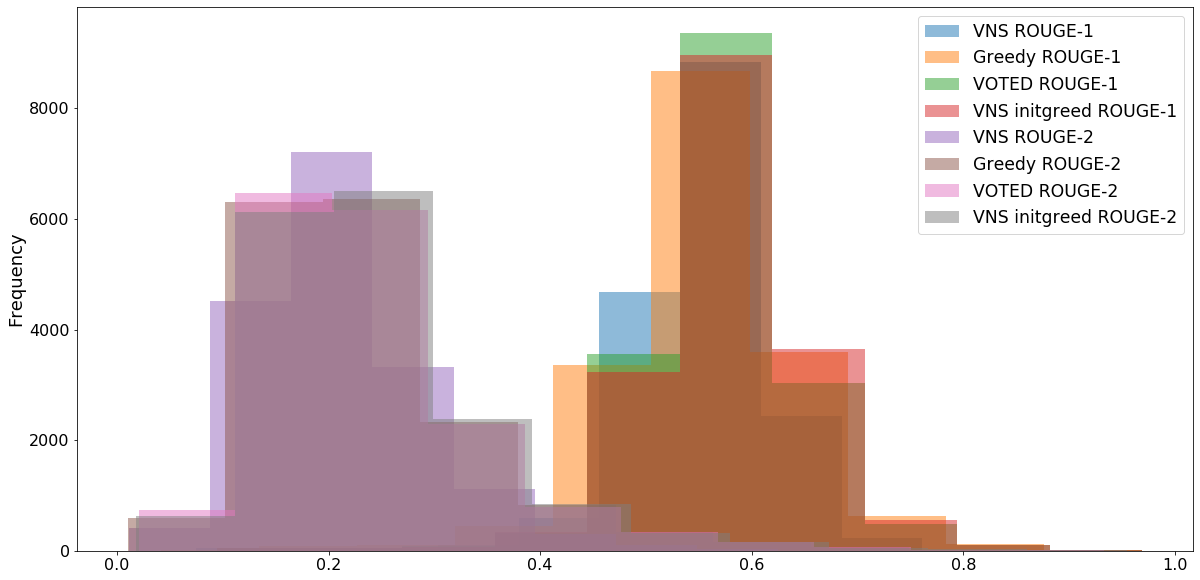

In [50]:
ds_merged['best_rouge1_vns'].plot.hist(figsize=(20, 10), alpha=0.5)
ds_merged['best_rouge1_wih'].plot.hist(figsize=(20, 10), alpha=0.5)
ds_merged['voted_r1'].plot.hist(figsize=(20, 10), alpha=0.5)
ds_merged['best_rouge1_vns_initgreed'].plot.hist(figsize=(20, 10), alpha=0.5)
ds_merged['best_rouge2_vns'].plot.hist(figsize=(20, 10), alpha=0.5)
ds_merged['best_rouge2_wih'].plot.hist(figsize=(20, 10), alpha=0.5)
ds_merged['voted_r2'].plot.hist(figsize=(20, 10), alpha=0.5)
ds_merged['best_rouge2_vns_initgreed'].plot.hist(figsize=(20, 10), alpha=0.5)
plt.legend(['VNS ROUGE-1', 'Greedy ROUGE-1', 'VOTED ROUGE-1', 'VNS initgreed ROUGE-1', 'VNS ROUGE-2', 'Greedy ROUGE-2', 'VOTED ROUGE-2', 'VNS initgreed ROUGE-2'], fontsize='xx-large')
plt.ylabel('Frequency', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

In [51]:
save_obj(ds_merged, 'ds_merged')